# GluonTS - Transfer Learning Approach (quarterly) 

- Two datasets: A and B
- Dataset A: Dataset subsetted by frequency, i.e. `m4_yearly_atm`
- Dataset B: Dataset subsetted by frequency and by domain, i.e. `m4_yearly_industry`
- Network A: Trained on dataset A
- Network B: Trained on dataset B
- Both networks are evaluated on dataset B. 

- Adjust epochs to account for different size of the datasets

Goal: Check TZ1: "Does the network learn from time series of the same domain or is it helpful to use time series from other domains?"

- Both networks are trained for ten trials (deepar) or three trials (deepstate)

Note that there are already results where a network is trained on `m4_frequency_domain` and evaluated on the same network.

In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.7MB/s  eta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 47.6MB/s ta 0:00:01
    100% |████████████████████████████████| 10.4MB 4.7MB/s  eta 0:00:01
    100% |████████████████████████████████| 7.3MB 6.6MB/s  eta 0:00:01
    100% |████████████████████████████████| 194kB 60.3MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 38.1MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 92kB 56.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1f/fd/3a/f29866dc23dada18f25e9837477c82bbd7952aeef86fa46f11
Successfully built ujson holidays
  Found existing installation: python-dateut

## Imports



In [3]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [4]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

In [6]:
dataset = get_dataset("m4_weekly", regenerate=False)

INFO:root:downloading and processing m4_weekly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json


### mv the data

Before moving on: Move the respective data according the required folder structure. In AWS:

- `mv [dataname] ../../.mxnet/gluon-ts/datasets/`

## Check the data

In [7]:
dataname_a = "m4_yearly"
dataset_a = get_dataset(dataname_a, regenerate=False)
len(dataset_a.train)

INFO:root:downloading and processing m4_yearly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly/test/data.json


23000

In [8]:
dataname_b1 = "m4_yearly_macro"
dataset_b1 = get_dataset(dataname_b1, regenerate=False)
len(dataset_b1.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.


3903

In [9]:
dataname_b2 = "m4_yearly_micro"
dataset_b2 = get_dataset(dataname_b2, regenerate=False)
len(dataset_b2.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.


6538

In [10]:
dataname_b3 = "m4_yearly_other"
dataset_b3 = get_dataset(dataname_b3, regenerate=False)
len(dataset_b3.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.


1236

### Dataset A


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 23000
length test: 23000

start:
 1750-01-31 00:00:00
target:
 [5172.1 5133.5 5186.9 5084.6 5182.  5414.3 5576.2 5752.9 5955.2 6087.8]
feat_static_cat:
 [0]


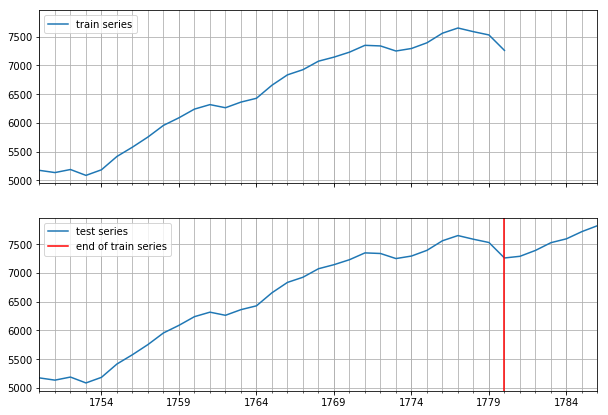

In [11]:
train_entry_a = next(iter(dataset_a.train))
test_entry_a = next(iter(dataset_a.test))

print(train_entry_a.keys())
print(test_entry_a.keys())
print("length train:", len(dataset_a.train))
print("length test:", len(dataset_a.test))


print("\nstart:\n",train_entry_a["start"])
print("target:\n", train_entry_a["target"][:10])
print("feat_static_cat:\n", train_entry_a["feat_static_cat"])

train_series_a = to_pandas(train_entry_a)
test_series_a = to_pandas(test_entry_a)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_a.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_a.plot(ax=ax[1])
ax[1].axvline(train_series_a.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Dataset B

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 1236
length test: 1236

start:
 1750-01-31 00:00:00
target:
 [459. 543. 512. 443. 528. 644. 493. 493. 517. 395.]
feat_static_cat:
 [1]


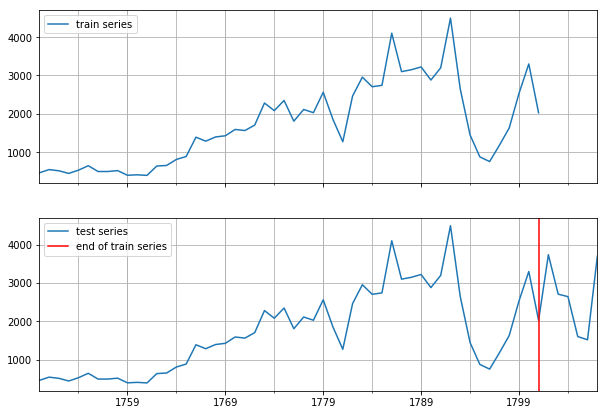

In [14]:
dataset_b = dataset_b3

train_entry_b = next(iter(dataset_b.train))
test_entry_b = next(iter(dataset_b.test))

print(train_entry_b.keys())
print(test_entry_b.keys())
print("length train:", len(dataset_b.train))
print("length test:", len(dataset_b.test))

print("\nstart:\n",train_entry_b["start"])
print("target:\n", train_entry_b["target"][:10])
print("feat_static_cat:\n", train_entry_b["feat_static_cat"])

train_series_b = to_pandas(train_entry_b)
test_series_b = to_pandas(test_entry_b)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_b.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_b.plot(ax=ax[1])
ax[1].axvline(train_series_b.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Comparison of both datasets

- Compare whether both datasets have the same length


In [15]:
# Check length
print("Length test train:", len(dataset_a.train) == len(dataset_b.train))
print("Length test test:", len(dataset_a.test) == len(dataset_b.test))

# Check frequency
print("Frequency test:",(dataset_a.metadata.freq == dataset_b.metadata.freq))


Length test train: False
Length test test: False
Frequency test: True


## Modeling: DeepAR

In [16]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [17]:
# A: dataset_a
# B: dataset_b
print(dataset_a)
print("\n", dataset_b)

TrainDatasets(metadata=MetaData(freq='12M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='23000')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=6), train=<gluonts.dataset.common.FileDataset object at 0x7f956462ac88>, test=<gluonts.dataset.common.FileDataset object at 0x7f956462ab38>)

 TrainDatasets(metadata=MetaData(freq='12M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='1236')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=6), train=<gluonts.dataset.common.FileDataset object at 0x7f956462a518>, test=<gluonts.dataset.common.FileDataset object at 0x7f9564eae518>)


In [18]:
print(dataname_a)
print(dataname_b1)

m4_yearly
m4_yearly_macro


In [19]:
def deepar_train_eval(dataname_a, dataname_b, seed=42, epochs=100, num_batches=100):
    """
    Function that trains a network using data from dataset B and evaluates the trained network on dataset A.
    Dataset A is the dataset of interest for our analysis. 
    """    
    
    dataset_a = get_dataset(dataname_a, regenerate=False)
    dataset_b = get_dataset(dataname_b, regenerate=False)
    
    # Assert checks
    assert (dataset_a.metadata.freq == dataset_b.metadata.freq)
#     assert ( len(dataset_a.train)==len(dataset_b.train) )
#     assert ( len(dataset_a.test)==len(dataset_b.test))
    
    mx.random.seed(seed)
    np.random.seed(seed)

    # define trainer
    trainer=Trainer(
        ctx=mx.cpu(),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
    )

    estimator=DeepAREstimator(
        trainer=trainer,
        context_length=dataset_a.metadata.prediction_length,
        prediction_length=dataset_a.metadata.prediction_length,
        freq=dataset_a.metadata.freq,
        use_feat_static_cat=False,
    )
    
#     estimator = DeepAREstimator(
#         trainer=trainer,
#         cardinality= [
#             feat_static_cat.cardinality 
#             for feat_static_cat in dataset_a.metadata.feat_static_cat
#         ],
#         context_length=dataset_a.metadata.prediction_length,
#         prediction_length=dataset_a.metadata.prediction_length,
#         freq=dataset_a.metadata.freq,
#         use_feat_static_cat=True
#     )
    
    # predictor trained on dataset_a, evaluated on dataset_b
    predictor_a=estimator.train(training_data=dataset_a.train)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset_b.test, predictor=predictor_a, num_samples=100
    )
    
    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series = len(dataset_b.test))
    
    metrics=["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    
    output["seed"]=seed
    output["epochs"]=epochs
    output["num_batches"]=num_batches
    output["train data"]=dataname_a
    output["eval data"]=dataname_b
    
    df=pd.DataFrame([output])

    return df

    

## Subsets

In [20]:
print(dataname_a)
print(dataname_b1)

m4_yearly
m4_yearly_macro


## Study 1: `m4_yearly` vs. `m4_yearly_macro` trained network

- Alternating between Run I - 10 trials A:B vs. 
- Run II - 10 trials of B:B


In [21]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_macro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 21884
100%|██████████| 50/50 [00:00<00:00, 58.21it/s, avg_epoch_loss=8.5]
INFO:root:Epoch[0] Elapsed time 0.861 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.504471
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.43it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 0.766 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.886298
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.28it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 0.694 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.110143
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.96it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 0.738 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.389315
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.32it/s, avg_epoch_loss=6.52]
INFO:

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 83.32it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[37] Elapsed time 0.602 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.376101
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.40it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[38] Elapsed time 0.683 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.207918
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.17it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 0.633 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.731974
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.26it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.619 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.960153
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.69it/s, avg_epoch_loss=7.24]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.873822  0.169934  98.471798            0.157983            0.095998   

   seed  epochs  num_batches train data        eval data  
0    42     100           50  m4_yearly  m4_yearly_macro  
Next seed: 43


100%|██████████| 50/50 [00:00<00:00, 63.06it/s, avg_epoch_loss=8.36]
INFO:root:Epoch[0] Elapsed time 0.795 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.361025
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.42it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 0.631 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.887139
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.99it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[2] Elapsed time 0.590 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.117778
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.72it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.629 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.468842
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.24it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[4] Elapsed time 0.694 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 74.71it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[37] Elapsed time 0.671 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.516047
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 77.92it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[38] Elapsed time 0.643 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.276766
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 76.77it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[39] Elapsed time 0.653 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.862285
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.72it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[40] Elapsed time 0.629 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.148069
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.23it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[41] Elapsed time 0.666 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.025125
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.71it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[74] Elapsed time 0.690 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.142846
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 75.92it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[75] Elapsed time 0.661 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.197944
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 67.38it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 0.744 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.675696
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 66.90it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[77] Elapsed time 0.749 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.257240
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  4.42774  0.167826  87.146765            0.155703            0.111971    43   

   epochs  num_batches train data        eval data  
0     100           50  m4_yearly  m4_yearly_macro  
Next seed: 44


100%|██████████| 50/50 [00:00<00:00, 74.32it/s, avg_epoch_loss=8.39]
INFO:root:Epoch[0] Elapsed time 0.674 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.390623
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.41it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[1] Elapsed time 0.623 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.837493
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.24it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 0.649 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.131030
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.72it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.637 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.474072
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.52it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[4] Elapsed time 0.721 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 81.74it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[37] Elapsed time 0.613 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.535886
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.13it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[38] Elapsed time 0.685 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.199467
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.67it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[39] Elapsed time 0.741 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.890546
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 69.30it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 0.725 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.893149
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.93it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[41] Elapsed time 0.727 seconds
I

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.745886  0.151625  60.038955            0.143596            0.100495   

   seed  epochs  num_batches train data        eval data  
0    44     100           50  m4_yearly  m4_yearly_macro  
Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 64.12it/s, avg_epoch_loss=8.35]
INFO:root:Epoch[0] Elapsed time 0.782 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.351627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.05it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[1] Elapsed time 0.642 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.021420
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.69it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 0.709 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.218781
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.63it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.710 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.558501
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.68it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.671 seconds
INFO:root:Epoch[4] Ev

KeyboardInterrupt: 

In [22]:
results

MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.873822  0.169934  98.471798            0.157983            0.095998   
0  4.427740  0.167826  87.146765            0.155703            0.111971   
0  3.745886  0.151625  60.038955            0.143596            0.100495   

   seed  epochs  num_batches train data        eval data  
0    42     100           50  m4_yearly  m4_yearly_macro  
0    43     100           50  m4_yearly  m4_yearly_macro  
0    44     100           50  m4_yearly  m4_yearly_macro

In [23]:
results = pd.DataFrame()

for i in range(45,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_macro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 65.86it/s, avg_epoch_loss=8.35]
INFO:root:Epoch[0] Elapsed time 0.761 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.351627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.46it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[1] Elapsed time 0.683 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.021420
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.83it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 0.653 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.218781
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.32it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.649 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.558501
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.75it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.629 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 81.94it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[37] Elapsed time 0.612 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.663585
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 87.79it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[38] Elapsed time 0.571 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.352268
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 78.60it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.638 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.060494
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.95it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 0.749 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.071069
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.96it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[41] Elapsed time 0.612 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.073140
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 75.89it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[74] Elapsed time 0.661 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.169389
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.38it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[75] Elapsed time 0.733 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.203270
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.43it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[76] Elapsed time 0.734 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.642127
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 73.88it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[77] Elapsed time 0.679 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.315003
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.836294  0.159838  65.677807            0.152487            0.107728   

   seed  epochs  num_batches train data        eval data  
0    45     100           50  m4_yearly  m4_yearly_macro  
Next seed: 46


100%|██████████| 50/50 [00:00<00:00, 74.26it/s, avg_epoch_loss=8.45]
INFO:root:Epoch[0] Elapsed time 0.675 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.454084
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.70it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[1] Elapsed time 0.762 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.777933
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.23it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.099694
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.45it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.601 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.469341
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.75it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[4] Elapsed time 0.708 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 73.79it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[37] Elapsed time 0.680 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.572787
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.86it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[38] Elapsed time 0.679 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.222297
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.69it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[39] Elapsed time 0.752 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.835304
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.80it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[40] Elapsed time 0.739 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.937070
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 65.87it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[41] Elapsed time 0.762 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.144706
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 70.78it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[74] Elapsed time 0.708 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.354326
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.76it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[75] Elapsed time 0.689 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.107741
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 81.39it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 0.616 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.508827
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.84it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[77] Elapsed time 0.646 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.150474
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.194961  0.158159  61.299902            0.147884            0.093843   

   seed  epochs  num_batches train data        eval data  
0    46     100           50  m4_yearly  m4_yearly_macro  
Next seed: 47


100%|██████████| 50/50 [00:00<00:00, 67.01it/s, avg_epoch_loss=8.3]
INFO:root:Epoch[0] Elapsed time 0.748 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.300957
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.68it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[1] Elapsed time 0.730 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.953688
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.90it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 0.697 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.185384
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.59it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[3] Elapsed time 0.691 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.618228
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.92it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[4] Elapsed time 0.717 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 72.45it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[37] Elapsed time 0.692 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.542198
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.96it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[38] Elapsed time 0.707 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.310337
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 64.40it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[39] Elapsed time 0.778 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.857199
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.49it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[40] Elapsed time 0.754 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.966600
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.75it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[41] Elapsed time 0.729 seconds


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.919448  0.154117  58.202187            0.146222             0.09572   

   seed  epochs  num_batches train data        eval data  
0    47     100           50  m4_yearly  m4_yearly_macro  
Next seed: 48


100%|██████████| 50/50 [00:00<00:00, 63.70it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 0.787 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.259591
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.52it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[1] Elapsed time 0.701 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.809849
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 85.57it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 0.586 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.096091
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 86.86it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 0.577 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.460881
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.24it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[4] Elapsed time 0.694 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 85.62it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[37] Elapsed time 0.586 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.604694
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.98it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[38] Elapsed time 0.660 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.310488
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.10it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[39] Elapsed time 0.747 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.830231
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 76.03it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.659 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.962990
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 72.23it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[41] Elapsed time 0.694 seconds
I

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.063190
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 85.60it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[74] Elapsed time 0.586 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.209669
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 86.49it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[75] Elapsed time 0.580 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.085264
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.47it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[76] Elapsed time 0.648 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.411025
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.21it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[77] Elapsed time 0.735 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.138513
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.572974  0.149084  57.436386            0.142474            0.100498   

   seed  epochs  num_batches train data        eval data  
0    48     100           50  m4_yearly  m4_yearly_macro  
Next seed: 49


100%|██████████| 50/50 [00:00<00:00, 75.30it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 0.666 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.047287
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.40it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[1] Elapsed time 0.631 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.824245
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.08it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 0.603 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.147297
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.56it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[3] Elapsed time 0.615 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.529483
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.17it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[4] Elapsed time 0.633 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 69.46it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[37] Elapsed time 0.722 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.662529
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 72.73it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[38] Elapsed time 0.689 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.508654
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 66.85it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[39] Elapsed time 0.749 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.264403
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 69.52it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[40] Elapsed time 0.721 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.157419
INFO:root:Epoch[41] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 79.80it/s, avg_epoch_loss

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.127874
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 80.32it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[74] Elapsed time 0.624 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.301678
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.65it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[75] Elapsed time 0.646 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.235435
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 75.91it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 0.661 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.847978
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 71.40it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[77] Elapsed time 0.702 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.381353
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  4.526131  0.17208  79.288044            0.159145            0.104804    49   

   epochs  num_batches train data        eval data  
0     100           50  m4_yearly  m4_yearly_macro  
Next seed: 50


100%|██████████| 50/50 [00:01<00:00, 47.83it/s, avg_epoch_loss=8.7]
INFO:root:Epoch[0] Elapsed time 1.047 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.698136
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.46it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[1] Elapsed time 0.993 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.967265
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.86it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 0.930 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.261159
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.11it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.736 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.563689
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.56it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.608 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 82.25it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[37] Elapsed time 0.610 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.581845
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 85.36it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[38] Elapsed time 0.587 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.355415
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.88it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.661 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.056478
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.10it/s, avg_epoch_loss=7]
INFO:root:Epoch[40] Elapsed time 0.686 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.003124
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.72it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[41] Elapsed time 0.710 seconds
INF

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.167244
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.86it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[74] Elapsed time 0.644 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.716728
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 76.30it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 0.657 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.126387
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 70.03it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[76] Elapsed time 0.716 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.293392
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.49it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[77] Elapsed time 0.691 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.030072
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.138342  0.158813  63.096871            0.148078            0.102241   

   seed  epochs  num_batches train data        eval data  
0    50     100           50  m4_yearly  m4_yearly_macro  
Next seed: 51


100%|██████████| 50/50 [00:00<00:00, 64.85it/s, avg_epoch_loss=8.27]
INFO:root:Epoch[0] Elapsed time 0.773 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.266300
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.60it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[1] Elapsed time 0.630 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.862214
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.72it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 0.599 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.180719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.41it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[3] Elapsed time 0.594 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.548719
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.69it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[4] Elapsed time 0.629 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 88.82it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[37] Elapsed time 0.566 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.420615
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.90it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[38] Elapsed time 0.630 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.273554
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 80.01it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.627 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.811695
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.34it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 0.666 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.068080
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 78.37it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[41] Elapsed time 0.640 seconds


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.280086  0.164888  73.323555            0.153623            0.114102   

   seed  epochs  num_batches train data        eval data  
0    51     100           50  m4_yearly  m4_yearly_macro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.836294  0.159838  65.677807            0.152487            0.107728   
0  4.194961  0.158159  61.299902            0.147884            0.093843   
0  3.919448  0.154117  58.202187            0.146222            0.095720   
0  3.572974  0.149084  57.436386            0.142474            0.100498   
0  4.526131  0.172080  79.288044            0.159145            0.104804   
0  4.138342  0.158813  63.096871            0.148078            0.102241   
0  4.280086  0.164888  73.323555            0.153623            0.114102   

   seed  epochs  num_batches train data        eval data  
0    45     100           50  m4_yearly  m4_yearly_macro  
0    46     100           50  m4_yearly  m4_yearly_macro  
0    47     100           50  m4_yearly  m4_yearly_macro  
0    48     100           50  m4_yearly  m4_yearly_macro  
0    49     100           50  m4_yearly  m4_yearly_macro  
0    50     100           50  m4_yearly  m4_yearly_macro  
0    51     100           50  m4_yearly  m4_yearly_macro

In [24]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_macro", dataname_b="m4_yearly_macro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 50/50 [00:01<00:00, 39.82it/s, avg_epoch_loss=8.5]
INFO:root:Epoch[0] Elapsed time 1.265 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.504471
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.61it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 1.238 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.886298
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.97it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[2] Elapsed time 1.288 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.528871
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.83it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 1.229 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.243482
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.99it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[4] Elapsed time 1.142 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.80it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[38] Elapsed time 1.029 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.855072
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.74it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[39] Elapsed time 1.101 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.500729
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.00it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[40] Elapsed time 1.121 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.847092
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.28it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 1.043 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.626360
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.24it/s, avg_epoch_loss=6.64]
INFO:root:Epo

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.546456
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.84it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[75] Elapsed time 1.011 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.733102
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 44.06it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 1.142 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.549674
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.18it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 1.023 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.734246
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 46.76it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[78] Elapsed time 1.076 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.606805
INFO:root:Epoch[79] Learning rate is 0.000125
100%|█

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.590866  0.149578  43.737675            0.144425            0.090885   

   seed  epochs  num_batches       train data        eval data  
0    42     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 43


100%|██████████| 50/50 [00:01<00:00, 39.46it/s, avg_epoch_loss=8.36]
INFO:root:Epoch[0] Elapsed time 1.277 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.361025
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 39.52it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 1.272 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.887139
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.51it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[2] Elapsed time 1.182 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.617197
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 39.71it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[3] Elapsed time 1.263 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.389342
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.99it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[4] Elapsed time 1.222 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.74it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[38] Elapsed time 0.999 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.787858
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.92it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 1.072 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.615798
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.14it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[40] Elapsed time 1.089 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.763866
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.15it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 1.046 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.658478
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.88it/s, avg_epoch_loss=6.64]
INFO:root:Ep

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 46.54it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[75] Elapsed time 1.077 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.645158
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 44.85it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[76] Elapsed time 1.117 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.625839
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 48.56it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[77] Elapsed time 1.032 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.717467
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 46.56it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[78] Elapsed time 1.079 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.610165
INFO:root:Loading parameters from best epoch (68)
INFO:root:Epoch[79] Learning rate is 0.000125
100%|██████████| 50/

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.081259  0.158196  44.795925            0.150643            0.092845   

   seed  epochs  num_batches       train data        eval data  
0    43     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 44


100%|██████████| 50/50 [00:01<00:00, 38.76it/s, avg_epoch_loss=8.39]
INFO:root:Epoch[0] Elapsed time 1.296 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.390623
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.17it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[1] Elapsed time 1.136 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.837493
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.02it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[2] Elapsed time 1.168 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.550150
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.70it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[3] Elapsed time 1.151 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.354536
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.19it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[4] Elapsed time 1.087 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.21it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[38] Elapsed time 0.944 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.716108
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.43it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 1.159 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.616909
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.61it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[40] Elapsed time 1.039 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.811277
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 45.93it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[41] Elapsed time 1.096 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.565581
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:0

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.832858  0.154452  44.549895            0.145451             0.09271   

   seed  epochs  num_batches       train data        eval data  
0    44     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 45


100%|██████████| 50/50 [00:01<00:00, 38.84it/s, avg_epoch_loss=8.35]
INFO:root:Epoch[0] Elapsed time 1.293 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.351627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.31it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[1] Elapsed time 1.218 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.021420
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.54it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[2] Elapsed time 1.210 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.674155
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.37it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[3] Elapsed time 1.245 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.340696
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.33it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[4] Elapsed time 1.086 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 51.10it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[38] Elapsed time 0.984 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.755956
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.62it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[39] Elapsed time 1.075 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.534364
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.03it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[40] Elapsed time 1.046 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.780971
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.21it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[41] Elapsed time 1.044 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.595433
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.37it/s, avg_epoch_loss=6.59]
INFO:root:Epo

100%|██████████| 50/50 [00:01<00:00, 47.83it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[75] Elapsed time 1.051 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.655850
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 50.05it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[76] Elapsed time 1.001 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.607532
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 45.63it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 1.101 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.730082
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 46.52it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[78] Elapsed time 1.080 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.535313
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 44.48it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[79] Elapsed time 1.126 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.188881  0.144695  40.008877            0.139085            0.093087   

   seed  epochs  num_batches       train data        eval data  
0    45     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 46


100%|██████████| 50/50 [00:01<00:00, 38.54it/s, avg_epoch_loss=8.45]
INFO:root:Epoch[0] Elapsed time 1.307 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.454084
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.71it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[1] Elapsed time 1.202 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.777933
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.29it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[2] Elapsed time 1.131 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.519982
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.72it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[3] Elapsed time 1.203 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.360375
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.57it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[4] Elapsed time 1.153 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.91it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[38] Elapsed time 1.073 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.832847
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.05it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[39] Elapsed time 1.117 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.542996
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.66it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[40] Elapsed time 1.102 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.763059
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.89it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[41] Elapsed time 1.051 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.695802
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 52.61it/s, avg_epoch_loss=6.56]
INFO:root:Epo

INFO:root:Loading parameters from best epoch (44)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.49it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[75] Elapsed time 1.014 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.638952
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 48.69it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 1.032 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.551478
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 51.96it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 0.966 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.729809
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 45.04it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[78] Elapsed time 1.116 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.500993
INFO:root:Epoch[79] Learning rate is 0.000125
100%|██████████| 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  5.004783  0.173669  51.742147            0.166835            0.094568   

   seed  epochs  num_batches       train data        eval data  
0    46     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 47


100%|██████████| 50/50 [00:01<00:00, 40.72it/s, avg_epoch_loss=8.3]
INFO:root:Epoch[0] Elapsed time 1.238 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.300957
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.58it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[1] Elapsed time 1.209 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.953688
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.30it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[2] Elapsed time 1.163 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.678887
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.14it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[3] Elapsed time 1.252 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.495128
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.63it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[4] Elapsed time 1.055 seconds
INFO:root:Epoch[4] Eval

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.715062
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 41.52it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[38] Elapsed time 1.206 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.846320
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 45.50it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[39] Elapsed time 1.101 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.705190
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.38it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[40] Elapsed time 1.015 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.818907
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.94it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 1.006 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.659842
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████|

100%|██████████| 50/50 [00:01<00:00, 45.71it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[74] Elapsed time 1.097 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.716671
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 51.70it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[75] Elapsed time 0.972 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.752691
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 41.38it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 1.218 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.650317
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 45.55it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[77] Elapsed time 1.103 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.860934
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 44.46it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[78] Elapsed time 1.133 secon

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.596029  0.165968  45.946124            0.152793              0.0916   

   seed  epochs  num_batches       train data        eval data  
0    47     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 48


100%|██████████| 50/50 [00:01<00:00, 39.62it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 1.268 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.259591
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.22it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[1] Elapsed time 1.164 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.809850
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.18it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[2] Elapsed time 1.136 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.480297
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.28it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[3] Elapsed time 1.186 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.284674
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.14it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[4] Elapsed time 1.137 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.30it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[38] Elapsed time 1.137 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.826883
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.36it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[39] Elapsed time 1.217 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.541915
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.97it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[40] Elapsed time 1.068 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.765311
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.58it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 0.939 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.628874
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.96it/s, avg_epoch_loss=6.6]
INFO:root:Epo

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.626361
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 48.65it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[75] Elapsed time 1.033 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.632448
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 54.24it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 0.932 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.546485
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 58.40it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[77] Elapsed time 0.862 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.772388
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 55.83it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[78] Elapsed time 0.902 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.481043
INFO:root:Epoch[79] Learning rate is 0.000125
100%|█

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.213648  0.161166  46.280665            0.154653            0.091641   

   seed  epochs  num_batches       train data        eval data  
0    48     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 49


100%|██████████| 50/50 [00:01<00:00, 39.27it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 1.278 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.047287
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.79it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[1] Elapsed time 1.231 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.824245
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.49it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[2] Elapsed time 1.179 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.558052
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.87it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[3] Elapsed time 1.171 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.451529
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.05it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[4] Elapsed time 1.165 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.78it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[38] Elapsed time 1.125 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.773589
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.85it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[39] Elapsed time 1.202 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.586556
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.40it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[40] Elapsed time 1.211 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.810405
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.58it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[41] Elapsed time 1.123 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.592515
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.59it/s, avg_epoch_loss=6.69]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 53.19it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 0.946 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.556395
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.69it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[76] Elapsed time 1.013 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.643206
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 46.55it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[77] Elapsed time 1.081 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.605855
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 41.97it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[78] Elapsed time 1.196 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.580163
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 49.20it/s, avg_epoch_loss=6.78

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.934547  0.154647  43.659883            0.150907            0.092473   

   seed  epochs  num_batches       train data        eval data  
0    49     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 50


100%|██████████| 50/50 [00:01<00:00, 40.03it/s, avg_epoch_loss=8.7]
INFO:root:Epoch[0] Elapsed time 1.261 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.698136
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.64it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[1] Elapsed time 1.307 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.967265
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.99it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[2] Elapsed time 1.170 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.706051
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.75it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[3] Elapsed time 1.232 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.478264
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.80it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[4] Elapsed time 1.175 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.80it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[38] Elapsed time 1.122 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.771320
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.98it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[39] Elapsed time 1.143 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.677053
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.52it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[40] Elapsed time 1.155 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.689990
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.10it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[41] Elapsed time 1.093 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.701246
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.27it/s, avg_epoch_loss=6.66]
INFO:root:Epo

INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.08it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[75] Elapsed time 1.026 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.847404
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 50.07it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[76] Elapsed time 1.003 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.536902
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 46.26it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[77] Elapsed time 1.086 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.697777
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 46.59it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[78] Elapsed time 1.079 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.767573
INFO:root:Epoch[79] Learning rate is 0.000125
100%|██████████| 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.315619  0.162161  48.859384            0.153887            0.090162   

   seed  epochs  num_batches       train data        eval data  
0    50     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 51


100%|██████████| 50/50 [00:01<00:00, 38.88it/s, avg_epoch_loss=8.27]
INFO:root:Epoch[0] Elapsed time 1.293 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.266300
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.19it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[1] Elapsed time 1.247 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.862214
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.41it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[2] Elapsed time 1.158 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.582373
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.19it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[3] Elapsed time 1.248 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.380957
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.44it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[4] Elapsed time 1.103 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.29it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[38] Elapsed time 1.085 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.689464
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.87it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[39] Elapsed time 1.201 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.552888
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.97it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[40] Elapsed time 1.198 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.713320
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.80it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[41] Elapsed time 1.175 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.562104
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.98it/s, avg_epoch_loss=6.64]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 52.66it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[75] Elapsed time 0.953 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.620134
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 45.59it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 1.101 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.505375
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 50.42it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 0.996 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.683092
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 44.68it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[78] Elapsed time 1.127 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.512639
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 53.40it/s, avg_epoch_loss=6.73

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.376449  0.14771  40.443079            0.144548            0.094532    51   

   epochs  num_batches       train data        eval data  
0     100           50  m4_yearly_macro  m4_yearly_macro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.590866  0.149578  43.737675            0.144425            0.090885   
0  4.081259  0.158196  44.795925            0.150643            0.092845   
0  3.832858  0.154452  44.549895            0.145451            0.092710   
0  3.188881  0.144695  40.008877            0.139085            0.093087   
0  5.004783  0.173669  51.742147            0.166835            0.094568   
0  4.596029  0.165968  45.946124            0.152793            0.091600   
0  4.213648  0.161166  46.280665            0.154653            0.091641   
0  3.934547  0.154647  43.659883            0.150907            0.092473   
0  4.315619  0.162161  48.859384            0.153887            0.090162   
0  3.376449  0.147710  40.443079            0.144548            0.094532   

   seed  epochs  num_batches       train data        eval data  
0    42     100           50  m4_yearly_macro  m4_yearly_macro  
0    43     100           50  m4_yearly_macro  m4_yearly_macro  
0    44     100           50  m4_yearly_macro  m4_yearly_macro  
0    45     100           50  m4_yearly_macro  m4_yearly_macro  
0    46     100           50  m4_yearly_macro  m4_yearly_macro  
0    47     100           50  m4_yearly_macro  m4_yearly_macro  
0    48     100           50  m4_yearly_macro  m4_yearly_macro  
0    49     100           50  m4_yearly_macro  m4_yearly_macro  
0    50     100           50  m4_yearly_macro  m4_yearly_macro  
0    51     100           50  m4_yearly_macro  m4_yearly_macro

In [25]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_macro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 100/100 [00:02<00:00, 41.25it/s, avg_epoch_loss=8.2]
INFO:root:Epoch[0] Elapsed time 2.429 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.195385
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.00it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[1] Elapsed time 2.279 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.749729
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.92it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 2.396 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.795460
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.70it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[3] Elapsed time 2.348 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.165579
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.65it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[4] Elapsed time 2.198 seconds
INFO:root:Epo

100%|██████████| 100/100 [00:02<00:00, 43.33it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[73] Elapsed time 2.315 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.657541
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 41.33it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[74] Elapsed time 2.422 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.468874
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.53it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[75] Elapsed time 2.306 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.741548
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 44.47it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[76] Elapsed time 2.256 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.952458
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.59it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.42it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[146] Elapsed time 2.362 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.650787
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.62it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[147] Elapsed time 2.248 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.976717
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.99it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[148] Elapsed time 2.329 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.526281
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.26it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[149] Elapsed time 2.620 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.648389
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.53it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.651590
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.62it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 2.296 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.994181
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.93it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[184] Elapsed time 2.282 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.495339
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.75it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[185] Elapsed time 2.460 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.645863
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.74it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[186] Elapsed time 2.288 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.512363
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.501718  0.146834  48.319234            0.141425            0.086382   

   seed  epochs  num_batches train data        eval data  
0    42     200          100  m4_yearly  m4_yearly_macro  
Next seed: 43


100%|██████████| 100/100 [00:02<00:00, 39.34it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 2.555 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.124082
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.45it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 2.255 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.793310
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.64it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 2.409 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.821315
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.42it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 2.312 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.267989
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.96it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[4] Elapsed time 2.182 seconds
INFO:root:E

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.743175
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 47.91it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[74] Elapsed time 2.092 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.301377
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 45.12it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[75] Elapsed time 2.218 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.621441
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 47.06it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[76] Elapsed time 2.127 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.047398
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 51.05it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 1.966 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.502181

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.703893
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.59it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[110] Elapsed time 2.530 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.422305
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.11it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[111] Elapsed time 2.440 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.620251
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.68it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[112] Elapsed time 2.297 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.120241
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.38it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[113] Elapsed time 2.482 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.391793
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.55it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[183] Elapsed time 2.472 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.775569
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.81it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[184] Elapsed time 2.344 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.881042
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.40it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[185] Elapsed time 2.422 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.403960
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.37it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[186] Elapsed time 2.311 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.702215
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.51it/s, avg_epoch_lo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.742196  0.150972  47.989475            0.145367            0.085819   

   seed  epochs  num_batches train data        eval data  
0    43     200          100  m4_yearly  m4_yearly_macro  
Next seed: 44


100%|██████████| 100/100 [00:02<00:00, 45.97it/s, avg_epoch_loss=8.11]
INFO:root:Epoch[0] Elapsed time 2.180 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.114058
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.96it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[1] Elapsed time 2.009 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.802551
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.27it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 2.219 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.821896
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.38it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 2.116 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.268796
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.10it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 2.042 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 49.60it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 2.018 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.728518
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 49.57it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[74] Elapsed time 2.024 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.448713
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 47.79it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[75] Elapsed time 2.096 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.783421
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 51.48it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[76] Elapsed time 1.946 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.105011
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 46.36it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.83it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[110] Elapsed time 2.457 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.404226
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.10it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[111] Elapsed time 2.380 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.683066
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.62it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[112] Elapsed time 2.298 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.137280
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.93it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[113] Elapsed time 2.643 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.475974
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.54it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.490671
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.29it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[147] Elapsed time 2.315 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.851865
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.81it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[148] Elapsed time 2.237 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.880718
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.18it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[149] Elapsed time 2.436 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.447984
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.13it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[150] Elapsed time 2.773 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.747568
INFO:root:Epoch[151] Learning rate is 5e-05

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.50901  0.149383  48.593414            0.142382            0.088369    44   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  
Next seed: 45


100%|██████████| 100/100 [00:03<00:00, 33.01it/s, avg_epoch_loss=8.19]
INFO:root:Epoch[0] Elapsed time 3.032 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.186523
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.78it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[1] Elapsed time 2.963 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.888641
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.95it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[2] Elapsed time 2.448 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.871945
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.87it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[3] Elapsed time 2.393 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.246537
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.41it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 2.258 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 44.49it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[73] Elapsed time 2.255 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.676639
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 42.75it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 2.346 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.525117
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.55it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[75] Elapsed time 2.302 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.843646
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 42.64it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 2.353 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.850339
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.81it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 2

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.98it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[146] Elapsed time 2.334 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.599794
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.78it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[147] Elapsed time 2.291 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.969478
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.28it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[148] Elapsed time 2.427 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.498815
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.61it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[149] Elapsed time 2.476 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.682779
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.10it/s, avg_epoch_lo

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.568087
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.37it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 2.263 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.989152
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.42it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[184] Elapsed time 2.364 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.480838
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.76it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[185] Elapsed time 2.399 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.655889
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.65it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[186] Elapsed time 2.353 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.457838
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.636366  0.14917  48.013786            0.142394            0.089356    45   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  
Next seed: 46


100%|██████████| 100/100 [00:02<00:00, 39.98it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 2.510 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.116008
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.75it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[1] Elapsed time 2.292 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.784518
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.69it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[2] Elapsed time 2.244 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.839188
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.43it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[3] Elapsed time 2.308 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.180859
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.74it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[4] Elapsed time 2.237 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 43.64it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 2.294 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.741237
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.08it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 2.383 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.491678
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 39.92it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[75] Elapsed time 2.513 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.735371
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 46.31it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[76] Elapsed time 2.165 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.122875
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 40.32it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.53it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 2.111 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.542078
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.54it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[111] Elapsed time 2.068 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.882424
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.87it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[112] Elapsed time 1.899 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.955219
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.56it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[113] Elapsed time 2.250 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.510298
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.62it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.574891
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.31it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[147] Elapsed time 2.314 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.917297
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.15it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[148] Elapsed time 2.270 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.747150
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.57it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 2.356 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.538855
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.69it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[150] Elapsed time 2.296 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.710595
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.568813  0.146905  50.51127            0.140171            0.088513    46   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  
Next seed: 47


100%|██████████| 100/100 [00:02<00:00, 40.88it/s, avg_epoch_loss=8.13]
INFO:root:Epoch[0] Elapsed time 2.455 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.127322
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.69it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 2.349 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.901806
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.14it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[2] Elapsed time 2.376 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.907745
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.83it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 2.460 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.289396
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.93it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[4] Elapsed time 2.238 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 42.99it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 2.329 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.739732
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.73it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[74] Elapsed time 2.463 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.431800
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.88it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[75] Elapsed time 2.453 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.755296
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 45.24it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 2.216 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.080871
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 39.95it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.49it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[146] Elapsed time 2.417 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.466303
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.28it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 2.427 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.842920
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.19it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[148] Elapsed time 2.376 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.973103
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.04it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 2.500 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.439603
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.21it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.560647
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.21it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[183] Elapsed time 2.320 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.946163
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.45it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[184] Elapsed time 2.310 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.717903
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.85it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[185] Elapsed time 2.397 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.498462
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.60it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[186] Elapsed time 2.356 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.687427
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.643597  0.147938  47.643079            0.140415            0.087459   

   seed  epochs  num_batches train data        eval data  
0    47     200          100  m4_yearly  m4_yearly_macro  
Next seed: 48


100%|██████████| 100/100 [00:02<00:00, 42.53it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[0] Elapsed time 2.357 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.034720
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.82it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[1] Elapsed time 2.142 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.778486
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.53it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 2.250 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.797674
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.16it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 2.220 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.212166
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.21it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 2.271 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 44.87it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 2.237 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.726165
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.28it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 2.427 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.412592
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.85it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 2.395 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.686547
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 45.34it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[76] Elapsed time 2.210 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.104077
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.62it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[77] Elapsed time 2

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.58it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[110] Elapsed time 2.354 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.487466
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.27it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[111] Elapsed time 2.318 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.735982
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.04it/s, avg_epoch_loss=7]
INFO:root:Epoch[112] Elapsed time 2.275 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.000775
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.81it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[113] Elapsed time 2.458 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.473320
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.59it/s, avg_epoch_los

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.527668
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.49it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 2.064 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.840223
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.69it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[148] Elapsed time 2.022 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.931899
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.98it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 2.089 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.441401
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.25it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[150] Elapsed time 2.035 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.730272
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.576671  0.147349  48.668499            0.141468            0.088626   

   seed  epochs  num_batches train data        eval data  
0    48     200          100  m4_yearly  m4_yearly_macro  
Next seed: 49


100%|██████████| 100/100 [00:02<00:00, 41.95it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 2.394 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.935766
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.21it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 2.168 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.838390
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.03it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[2] Elapsed time 2.228 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.893024
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.20it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 2.494 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.239480
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.91it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[4] Elapsed time 2.185 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 45.06it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[73] Elapsed time 2.225 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.718448
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.92it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[74] Elapsed time 2.336 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.439780
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.82it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[75] Elapsed time 2.399 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.771750
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 46.16it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 2.174 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.082440
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.13it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.18it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[110] Elapsed time 2.434 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.469590
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.71it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[111] Elapsed time 2.346 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.762115
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.68it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[112] Elapsed time 2.247 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.080757
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.01it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[113] Elapsed time 2.445 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.444091
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.65it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.527776
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.37it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[147] Elapsed time 2.116 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.875745
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.85it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[148] Elapsed time 2.098 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.918396
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.81it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 2.146 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.478219
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.60it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[150] Elapsed time 2.062 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.717753
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.354129  0.14342  47.571261            0.137825            0.090612    49   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  
Next seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 21884
100%|██████████| 100/100 [00:02<00:00, 38.29it/s, avg_epoch_loss=8.33]
INFO:root:Epoch[0] Elapsed time 2.624 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.332700
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.81it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[1] Elapsed time 2.340 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.912424
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.10it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[2] Elapsed time 2.441 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.868806
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.20it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 2.434 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.262900
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.14it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:02<00:00, 42.68it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[37] Elapsed time 2.346 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.958707
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.86it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[38] Elapsed time 2.338 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.180485
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.44it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 2.478 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.725206
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.29it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 2.315 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.068090
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 40.81it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:02<00:00, 43.58it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[109] Elapsed time 2.298 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.816506
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.87it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[110] Elapsed time 2.454 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.370803
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.80it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[111] Elapsed time 2.400 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.597171
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.18it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[112] Elapsed time 2.269 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.095878
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.79it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[113] Elapsed time 2

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.41it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[146] Elapsed time 2.163 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.420072
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.86it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 2.187 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.671108
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.55it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[148] Elapsed time 1.910 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.102893
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.89it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 2.187 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.444185
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.98it/s, avg_epoch_l

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.478447
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.81it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[183] Elapsed time 2.192 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.802549
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.95it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[184] Elapsed time 2.183 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.973452
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.52it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[185] Elapsed time 2.304 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.425504
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.17it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[186] Elapsed time 2.270 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.732933
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.479146  0.146632  47.502652            0.142639            0.085848   

   seed  epochs  num_batches train data        eval data  
0    50     200          100  m4_yearly  m4_yearly_macro  
Next seed: 51


100%|██████████| 100/100 [00:02<00:00, 42.39it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 2.361 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.064257
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.29it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 2.163 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.864719
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.77it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[2] Elapsed time 2.341 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.855146
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.31it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 2.424 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.232735
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.55it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[4] Elapsed time 2.254 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 44.52it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 2.250 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.730577
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.28it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 2.374 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.413955
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.15it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[75] Elapsed time 2.377 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.730231
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.38it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[76] Elapsed time 2.313 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.085302
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 39.75it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.96it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[110] Elapsed time 2.570 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.526979
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.64it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[111] Elapsed time 2.353 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.815124
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.01it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[112] Elapsed time 2.280 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.962103
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.00it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[113] Elapsed time 2.571 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.461750
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.06it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.629533
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.94it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[147] Elapsed time 2.334 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.933004
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.29it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[148] Elapsed time 2.367 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.731088
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.87it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 2.453 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.537554
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.44it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[150] Elapsed time 2.206 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.639926
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.324741  0.142988  47.44065            0.138021            0.089509    51   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.501718  0.146834  48.319234            0.141425            0.086382   
0  3.742196  0.150972  47.989475            0.145367            0.085819   
0  3.509010  0.149383  48.593414            0.142382            0.088369   
0  3.636366  0.149170  48.013786            0.142394            0.089356   
0  3.568813  0.146905  50.511270            0.140171            0.088513   
0  3.643597  0.147938  47.643079            0.140415            0.087459   
0  3.576671  0.147349  48.668499            0.141468            0.088626   
0  3.354129  0.143420  47.571261            0.137825            0.090612   
0  3.479146  0.146632  47.502652            0.142639            0.085848   
0  3.324741  0.142988  47.440650            0.138021            0.089509   

   seed  epochs  num_batches train data        eval data  
0    42     200          100  m4_yearly  m4_yearly_macro  
0    43     200          100  m4_yearly  m4_yearly_macro  
0    44     200          100  m4_yearly  m4_yearly_macro  
0    45     200          100  m4_yearly  m4_yearly_macro  
0    46     200          100  m4_yearly  m4_yearly_macro  
0    47     200          100  m4_yearly  m4_yearly_macro  
0    48     200          100  m4_yearly  m4_yearly_macro  
0    49     200          100  m4_yearly  m4_yearly_macro  
0    50     200          100  m4_yearly  m4_yearly_macro  
0    51     200          100  m4_yearly  m4_yearly_macro

In [26]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_macro", dataname_b="m4_yearly_macro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 100/100 [00:02<00:00, 40.33it/s, avg_epoch_loss=8.2]
INFO:root:Epoch[0] Elapsed time 2.490 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.195385
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.79it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 2.290 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.386176
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.76it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 2.240 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.134958
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.67it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[3] Elapsed time 2.296 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.025120
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.65it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[4] Elapsed time 2.242 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 42.93it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[74] Elapsed time 2.334 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.438849
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.16it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[75] Elapsed time 2.322 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.491773
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.91it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[76] Elapsed time 2.339 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.484247
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.83it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[77] Elapsed time 2.398 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.432979
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.65it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[78] Elapsed time 2.593 second

INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.381948
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.37it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[146] Elapsed time 2.313 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.424516
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.35it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[147] Elapsed time 2.366 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.416344
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.68it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[148] Elapsed time 2.405 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.476679
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.22it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[149] Elapsed time 2.375 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.385178
INFO:root:Epoch[150] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.368817  0.145886  37.487511            0.141783            0.085291   

   seed  epochs  num_batches       train data        eval data  
0    42     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 43


100%|██████████| 100/100 [00:02<00:00, 40.50it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 2.476 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.124082
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.35it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[1] Elapsed time 2.368 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.503270
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.48it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[2] Elapsed time 2.361 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.197041
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.21it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[3] Elapsed time 2.271 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.098925
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.25it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[4] Elapsed time 2.373 seconds
INFO:root:Epoc

100%|██████████| 100/100 [00:02<00:00, 41.87it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[73] Elapsed time 2.394 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.571469
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 42.96it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 2.333 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.492849
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.49it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[75] Elapsed time 2.305 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.654848
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.62it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[76] Elapsed time 2.298 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.575285
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.04it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.24it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[146] Elapsed time 2.371 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.572074
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.16it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[147] Elapsed time 2.437 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.565754
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.83it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[148] Elapsed time 2.396 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.558924
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.97it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[149] Elapsed time 2.508 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.580753
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.18it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.564874
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.95it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[183] Elapsed time 2.184 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.484030
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.54it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[184] Elapsed time 2.202 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.569265
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.31it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[185] Elapsed time 2.119 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.565089
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.08it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[186] Elapsed time 1.888 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.566898
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.488028  0.149214  40.419436            0.143831            0.090179   

   seed  epochs  num_batches       train data        eval data  
0    43     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 44


100%|██████████| 100/100 [00:02<00:00, 40.06it/s, avg_epoch_loss=8.11]
INFO:root:Epoch[0] Elapsed time 2.503 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.114058
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.39it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 2.366 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.452343
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.15it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[2] Elapsed time 2.272 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.234132
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.15it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[3] Elapsed time 2.376 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.069614
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.28it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[4] Elapsed time 2.371 seconds
INFO:root:E

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.597461
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 41.99it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 2.385 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.579247
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.41it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[75] Elapsed time 2.308 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.494816
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.08it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 2.329 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.513858
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 42.82it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[77] Elapsed time 2.339 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.590976
INFO:root:Epoch[78] Learning rate is 0.00025
100

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.522224
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.10it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[110] Elapsed time 2.385 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.525314
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.39it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[111] Elapsed time 2.421 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.586429
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.18it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[112] Elapsed time 2.437 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.562892
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.81it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[113] Elapsed time 2.456 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.543709
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.51it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[183] Elapsed time 2.154 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.578544
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.07it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[184] Elapsed time 2.082 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.552726
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.68it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[185] Elapsed time 2.062 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.605474
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.69it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[186] Elapsed time 2.146 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.500878
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.26it/s, avg_epoch_l

     MASE    sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.2386  0.14731  37.77913            0.141649             0.09194    44   

   epochs  num_batches       train data        eval data  
0     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 45


100%|██████████| 100/100 [00:02<00:00, 40.09it/s, avg_epoch_loss=8.19]
INFO:root:Epoch[0] Elapsed time 2.499 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.186523
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.24it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[1] Elapsed time 2.375 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.507425
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.84it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[2] Elapsed time 2.396 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.203968
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.44it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[3] Elapsed time 2.479 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.148030
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.71it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[4] Elapsed time 2.401 seconds
INFO:root:Ep

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.498184
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 41.51it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[74] Elapsed time 2.417 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.559644
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.02it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[75] Elapsed time 2.332 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.592477
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.04it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 2.329 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.549924
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.47it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[77] Elapsed time 2.304 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.566415
INFO:root:Loading parameters from best epoch (67

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.563423
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.50it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 2.414 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.612849
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.05it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[111] Elapsed time 2.384 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.540890
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.16it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[112] Elapsed time 2.322 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.494676
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.28it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[113] Elapsed time 2.318 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.533835
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.81it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[183] Elapsed time 2.236 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.464553
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.53it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[184] Elapsed time 2.154 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.450246
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.57it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[185] Elapsed time 2.022 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.524723
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.11it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[186] Elapsed time 2.175 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.527777
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.12it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.429016  0.148383  39.115205            0.142218             0.08797   

   seed  epochs  num_batches       train data        eval data  
0    45     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 46


100%|██████████| 100/100 [00:02<00:00, 40.65it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 2.469 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.116008
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.61it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 2.247 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.440179
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.59it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 2.300 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.220828
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.90it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[3] Elapsed time 2.337 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.109044
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.43it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[4] Elapsed time 2.363 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 42.16it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[37] Elapsed time 2.373 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.678235
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 43.14it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[38] Elapsed time 2.325 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.630832
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 41.89it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 2.390 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.615567
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 41.25it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[40] Elapsed time 2.429 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.601848
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 42.43it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[41] Elapsed time 2.366 sec

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 42.19it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 2.377 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.578343
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 42.61it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[75] Elapsed time 2.353 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.591091
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.36it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[76] Elapsed time 2.315 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.612673
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.28it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[77] Elapsed time 2.317 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.643052
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 40.95it/s, avg_epoch_los

100%|██████████| 100/100 [00:02<00:00, 41.88it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[110] Elapsed time 2.394 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.633057
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.40it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[111] Elapsed time 2.426 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.541056
INFO:root:Loading parameters from best epoch (101)
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.02it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[112] Elapsed time 2.331 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.521025
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.21it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[113] Elapsed time 2.321 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.583404
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.72it/s, 

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.578983
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.73it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[147] Elapsed time 2.291 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.538027
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.05it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[148] Elapsed time 2.276 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.614019
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.17it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[149] Elapsed time 2.376 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.561978
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.95it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[150] Elapsed time 2.332 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.487700
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.191792  0.144903  41.978798            0.140816            0.091765   

   seed  epochs  num_batches       train data        eval data  
0    46     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 21884
100%|██████████| 100/100 [00:02<00:00, 39.44it/s, avg_epoch_loss=8.13]
INFO:root:Epoch[0] Elapsed time 2.544 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.127322
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.90it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 2.389 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.587008
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.95it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[2] Elapsed time 2.333 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.318067
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.74it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[3] Elapsed time 2.293 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.157747
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.07it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 45.84it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[37] Elapsed time 2.187 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.676831
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 43.77it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[38] Elapsed time 2.291 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.701573
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.11it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[39] Elapsed time 2.331 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.643823
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 41.46it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[40] Elapsed time 2.419 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.632231
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████|

100%|██████████| 100/100 [00:02<00:00, 40.77it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[73] Elapsed time 2.461 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.655433
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.74it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[74] Elapsed time 2.346 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.644885
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.11it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 2.328 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.691856
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.10it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 2.327 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.649844
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.64it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.62it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[110] Elapsed time 2.355 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.695148
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.97it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[111] Elapsed time 2.388 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.626034
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.77it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[112] Elapsed time 2.457 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.676426
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.04it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[113] Elapsed time 2.329 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.647970
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.87it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.597538
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.56it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[147] Elapsed time 2.251 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.640818
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.12it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[148] Elapsed time 2.327 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.680896
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.87it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[149] Elapsed time 2.286 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.671057
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.30it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[150] Elapsed time 2.426 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.737092
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.239398  0.145077  40.580033            0.142664            0.091297   

   seed  epochs  num_batches       train data        eval data  
0    47     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 48


100%|██████████| 100/100 [00:02<00:00, 40.57it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[0] Elapsed time 2.485 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.034720
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.29it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[1] Elapsed time 2.315 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.382485
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.70it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 2.244 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.208022
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.27it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[3] Elapsed time 2.371 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.159845
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.28it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[4] Elapsed time 2.315 seconds
INFO:root:E

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.490605
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 41.33it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[74] Elapsed time 2.427 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.524197
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 41.79it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 2.399 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.546144
INFO:root:Loading parameters from best epoch (45)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.69it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 2.466 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.556852
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 41.51it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[77] Elapsed time 2.416 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.584

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.611606
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.45it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[110] Elapsed time 2.415 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.548741
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.87it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[111] Elapsed time 2.391 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.536555
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.12it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[112] Elapsed time 2.385 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.494164
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.80it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[113] Elapsed time 2.344 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.524944
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.57it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[183] Elapsed time 2.671 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.508412
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.16it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[184] Elapsed time 2.272 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.436778
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.97it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[185] Elapsed time 2.331 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.499955
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.43it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[186] Elapsed time 2.304 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.559536
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.93it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.471761  0.148971  39.231596             0.14411            0.092541   

   seed  epochs  num_batches       train data        eval data  
0    48     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 49


100%|██████████| 100/100 [00:02<00:00, 48.15it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 2.089 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.935766
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.72it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[1] Elapsed time 1.938 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.504791
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.10it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[2] Elapsed time 2.125 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.350543
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.12it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[3] Elapsed time 2.124 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.199803
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.03it/s, avg_epoch_loss=7]
INFO:root:Epoch[4] Elapsed time 2.084 seconds
INFO:root:Epoch[

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 42.45it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[74] Elapsed time 2.361 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.476915
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 40.26it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[75] Elapsed time 2.486 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.490081
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 40.22it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[76] Elapsed time 2.495 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.517327
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 43.09it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[77] Elapsed time 2.328 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.508603
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 44.02it/s, avg_epoch_loss=6.4

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.11it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[110] Elapsed time 2.326 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.508223
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.13it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[111] Elapsed time 2.436 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.595145
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.69it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[112] Elapsed time 2.345 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.413056
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.54it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[113] Elapsed time 2.299 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.464933
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.48it

100%|██████████| 100/100 [00:02<00:00, 41.58it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[146] Elapsed time 2.411 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.450215
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.47it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[147] Elapsed time 2.601 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.461598
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.69it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[148] Elapsed time 2.348 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.542274
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.82it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[149] Elapsed time 2.287 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.502562
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.01it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.69it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[183] Elapsed time 2.403 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.491285
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.36it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[184] Elapsed time 2.612 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.476670
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.21it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[185] Elapsed time 2.321 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.495919
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.31it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[186] Elapsed time 2.486 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.454172
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.92it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.257929  0.143956  37.314488            0.139022            0.085313   

   seed  epochs  num_batches       train data        eval data  
0    49     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 50


100%|██████████| 100/100 [00:02<00:00, 45.01it/s, avg_epoch_loss=8.33]
INFO:root:Epoch[0] Elapsed time 2.225 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.332700
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.20it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 2.121 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.592158
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.33it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[2] Elapsed time 2.071 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.313430
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.72it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[3] Elapsed time 2.193 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.103967
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.23it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[4] Elapsed time 2.217 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 43.84it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[74] Elapsed time 2.285 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.563354
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 43.44it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 2.305 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.561125
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 42.25it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[76] Elapsed time 2.374 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.526828
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.40it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[77] Elapsed time 2.311 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.488719
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.00it/s, avg_epoch_

100%|██████████| 100/100 [00:02<00:00, 42.37it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[110] Elapsed time 2.365 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.520674
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 40.82it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[111] Elapsed time 2.455 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.470884
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.30it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[112] Elapsed time 2.316 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.493595
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.47it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[113] Elapsed time 2.303 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.579934
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.45it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[114] 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.83it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[183] Elapsed time 2.286 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.493224
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.01it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[184] Elapsed time 2.388 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.569484
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.12it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[185] Elapsed time 2.378 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.506992
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.89it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[186] Elapsed time 2.340 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.540122
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.72it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.572528  0.150209  40.125922            0.144423            0.088104   

   seed  epochs  num_batches       train data        eval data  
0    50     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 51


100%|██████████| 100/100 [00:02<00:00, 44.19it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 2.265 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.064257
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.94it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[1] Elapsed time 2.181 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.481665
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.52it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[2] Elapsed time 2.068 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.141130
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.98it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[3] Elapsed time 2.182 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.058624
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.86it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[4] Elapsed time 2.140 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 42.68it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[73] Elapsed time 2.350 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.549200
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 41.62it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[74] Elapsed time 2.408 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.514100
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.73it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[75] Elapsed time 2.292 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.518396
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 45.69it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 2.196 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.557306
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 45.69it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.00it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[146] Elapsed time 2.331 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.499920
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.35it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[147] Elapsed time 2.421 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.544756
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.31it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[148] Elapsed time 2.368 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.559883
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.72it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 2.590 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.480730
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.95it/s, avg_epoch_l

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.554535
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.93it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[183] Elapsed time 2.391 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.546415
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.69it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[184] Elapsed time 2.344 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.525927
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.85it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[185] Elapsed time 2.400 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.432068
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.47it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[186] Elapsed time 2.306 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.529206
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.304092  0.145225  37.205162            0.138866            0.089406   

   seed  epochs  num_batches       train data        eval data  
0    51     200          100  m4_yearly_macro  m4_yearly_macro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.368817  0.145886  37.487511            0.141783            0.085291   
0  3.488028  0.149214  40.419436            0.143831            0.090179   
0  3.238600  0.147310  37.779130            0.141649            0.091940   
0  3.429016  0.148383  39.115205            0.142218            0.087970   
0  3.191792  0.144903  41.978798            0.140816            0.091765   
0  3.239398  0.145077  40.580033            0.142664            0.091297   
0  3.471761  0.148971  39.231596            0.144110            0.092541   
0  3.257929  0.143956  37.314488            0.139022            0.085313   
0  3.572528  0.150209  40.125922            0.144423            0.088104   
0  3.304092  0.145225  37.205162            0.138866            0.089406   

   seed  epochs  num_batches       train data        eval data  
0    42     200          100  m4_yearly_macro  m4_yearly_macro  
0    43     200          100  m4_yearly_macro  m4_yearly_macro  
0    44     200          100  m4_yearly_macro  m4_yearly_macro  
0    45     200          100  m4_yearly_macro  m4_yearly_macro  
0    46     200          100  m4_yearly_macro  m4_yearly_macro  
0    47     200          100  m4_yearly_macro  m4_yearly_macro  
0    48     200          100  m4_yearly_macro  m4_yearly_macro  
0    49     200          100  m4_yearly_macro  m4_yearly_macro  
0    50     200          100  m4_yearly_macro  m4_yearly_macro  
0    51     200          100  m4_yearly_macro  m4_yearly_macro

In [27]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_macro", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 200/200 [00:04<00:00, 43.79it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[0] Elapsed time 4.573 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.472557
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.90it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[1] Elapsed time 4.362 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.980519
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.65it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[2] Elapsed time 4.202 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.087220
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.27it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 4.421 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.950964
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.63it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[4] Elapsed time 4.201 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 41.36it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[73] Elapsed time 4.843 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.716807
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 41.28it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[74] Elapsed time 4.852 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.501380
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 43.06it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[75] Elapsed time 4.650 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.312409
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 43.00it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[76] Elapsed time 4.656 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.109647
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 42.67it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 4

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.46it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[146] Elapsed time 4.949 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.427855
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.29it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[147] Elapsed time 4.627 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.148345
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.81it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[148] Elapsed time 4.679 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.214456
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.95it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[149] Elapsed time 4.556 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.627709
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.41it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.468707
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.89it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[183] Elapsed time 4.561 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.150182
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.18it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[184] Elapsed time 4.639 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.150246
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.25it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[185] Elapsed time 4.524 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.619140
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.60it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[186] Elapsed time 4.701 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.442881
INFO:root:Epoch[187] Learning rate is 5e-05

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.38it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[256] Elapsed time 4.317 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.286365
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.82it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[257] Elapsed time 3.940 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.583467
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.27it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[258] Elapsed time 4.629 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.461902
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.51it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[259] Elapsed time 4.501 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.845619
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.20it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.285253
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.67it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[293] Elapsed time 4.691 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.541518
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.27it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[294] Elapsed time 4.851 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.462343
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.06it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[295] Elapsed time 4.875 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.834291
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.49it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[296] Elapsed time 4.946 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.670467
INFO:root:Epoch[297] Learning rate is 5e-05

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.68it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[366] Elapsed time 4.293 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.443689
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.02it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[367] Elapsed time 3.778 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.817733
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.79it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[368] Elapsed time 4.019 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.641913
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.99it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[369] Elapsed time 4.351 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.371314
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.57it/s, avg_epoch_

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.200737  0.142779  36.78267            0.138007            0.080906    42   

   epochs  num_batches train data        eval data  
0     400          200  m4_yearly  m4_yearly_macro  
Next seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 21884
100%|██████████| 200/200 [00:04<00:00, 40.69it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[0] Elapsed time 4.931 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.458696
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.45it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[1] Elapsed time 4.951 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.044652
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.79it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 4.792 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.186033
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.45it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[3] Elapsed time 4.719 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.022661
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 43.31it/s, avg_epoch_loss=

100%|██████████| 200/200 [00:04<00:00, 43.20it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[37] Elapsed time 4.635 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.416388
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.97it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[38] Elapsed time 4.774 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.713214
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.53it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[39] Elapsed time 4.940 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.598427
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 42.27it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[40] Elapsed time 4.735 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.971729
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 43.34it/s, avg_epoch_loss=

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.436176
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.57it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[110] Elapsed time 4.817 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.686597
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.60it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[111] Elapsed time 5.055 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.577315
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.46it/s, avg_epoch_loss=6]
INFO:root:Epoch[112] Elapsed time 4.826 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.997657
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.33it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[113] Elapsed time 4.727 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.762544
INFO:root:Epoch[114] Learning rate is 5e-05
10

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.63it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[183] Elapsed time 4.699 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.376515
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.93it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[184] Elapsed time 4.777 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.070078
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.39it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[185] Elapsed time 4.724 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.757182
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.54it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[186] Elapsed time 4.705 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.486576
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.91it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.322359
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.67it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[220] Elapsed time 4.804 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.086669
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.06it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[221] Elapsed time 4.652 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.698912
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.28it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[222] Elapsed time 4.736 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.437809
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.74it/s, avg_epoch_loss=6]
INFO:root:Epoch[223] Elapsed time 4.580 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.999532
INFO:root:Epoch[224] Learning rate is 5e-05
100

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.78it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[293] Elapsed time 4.794 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.604923
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.36it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[294] Elapsed time 4.843 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.499076
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.47it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[295] Elapsed time 4.948 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.876380
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.81it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[296] Elapsed time 4.681 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.683812
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.17it/s, avg_epoch_lo

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.595485
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.68it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[330] Elapsed time 4.803 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.468336
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.63it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[331] Elapsed time 4.697 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.895155
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.90it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[332] Elapsed time 4.778 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.675535
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.37it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[333] Elapsed time 4.960 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.483302
INFO:root:Epoch[334] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.282373  0.143893  38.193265            0.137665            0.085523   

   seed  epochs  num_batches train data        eval data  
0    43     400          200  m4_yearly  m4_yearly_macro  
Next seed: 44


100%|██████████| 200/200 [00:04<00:00, 40.58it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[0] Elapsed time 4.933 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.458305
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.03it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[1] Elapsed time 4.762 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.045346
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 43.08it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 4.645 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.146327
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.05it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 4.765 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.945766
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 43.74it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[4] Elapsed time 4.579 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 41.34it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[37] Elapsed time 4.845 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.587670
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 42.19it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[38] Elapsed time 4.747 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.728704
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 41.44it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 4.835 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.727643
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 41.96it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[40] Elapsed time 4.774 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.015541
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 44.27it/s, avg_epoch_

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.64it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[73] Elapsed time 4.928 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.684211
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.64it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[74] Elapsed time 4.809 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.677317
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.31it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 4.850 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.693600
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.55it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[76] Elapsed time 4.938 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.112494
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.28it/s, avg_epoch_loss=6.9]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.90it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 4.780 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.608383
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.26it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[111] Elapsed time 4.740 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.555792
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.74it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[112] Elapsed time 4.580 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.086898
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.70it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[113] Elapsed time 4.482 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.863207
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.94it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.618986
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.93it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[147] Elapsed time 4.665 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.318660
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.72it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[148] Elapsed time 4.687 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.218536
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.30it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[149] Elapsed time 4.622 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.817953
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.12it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[150] Elapsed time 4.753 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.590032
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.56it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[220] Elapsed time 4.702 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.187414
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.97it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[221] Elapsed time 4.772 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.748122
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.45it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[222] Elapsed time 4.952 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.565884
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.14it/s, avg_epoch_loss=6]
INFO:root:Epoch[223] Elapsed time 4.642 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.001161
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.52it/s, avg_epoch_los

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.181936
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.05it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[257] Elapsed time 4.761 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.708400
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.45it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[258] Elapsed time 4.831 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.558325
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.60it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[259] Elapsed time 4.702 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.005640
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.37it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[260] Elapsed time 4.959 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.706177
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.68it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[330] Elapsed time 4.694 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.502587
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.04it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[331] Elapsed time 4.547 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.940562
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.62it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[332] Elapsed time 4.698 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.643235
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.95it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[333] Elapsed time 4.774 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.517589
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.26it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.505325
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.89it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[367] Elapsed time 4.559 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.926778
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.02it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[368] Elapsed time 4.447 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.704713
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.31it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[369] Elapsed time 4.851 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.482490
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.91it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[370] Elapsed time 4.666 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.303286
INFO:root:Epoch[371] Learning rate is 5e-05
1

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.284903  0.145586  37.449966            0.140454            0.090755   

   seed  epochs  num_batches train data        eval data  
0    44     400          200  m4_yearly  m4_yearly_macro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.200737  0.142779  36.782670            0.138007            0.080906   
0  3.282373  0.143893  38.193265            0.137665            0.085523   
0  3.284903  0.145586  37.449966            0.140454            0.090755   

   seed  epochs  num_batches train data        eval data  
0    42     400          200  m4_yearly  m4_yearly_macro  
0    43     400          200  m4_yearly  m4_yearly_macro  
0    44     400          200  m4_yearly  m4_yearly_macro

In [28]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_macro", dataname_b="m4_yearly_macro", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 21884
100%|██████████| 200/200 [00:05<00:00, 39.79it/s, avg_epoch_loss=7.79]
INFO:root:Epoch[0] Elapsed time 5.039 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.790780
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.76it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[1] Elapsed time 4.914 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.080039
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.91it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[2] Elapsed time 4.669 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.910163
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 43.37it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[3] Elapsed time 4.618 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.823795
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.36it/s, avg_epoch_loss=

100%|██████████| 200/200 [00:04<00:00, 42.16it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[37] Elapsed time 4.750 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.465311
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.40it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[38] Elapsed time 4.835 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.458613
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 43.07it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[39] Elapsed time 4.648 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.433618
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.21it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[40] Elapsed time 4.745 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.450596
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.96it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[41] Elapsed time 4.661 second

100%|██████████| 200/200 [00:03<00:00, 56.20it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[110] Elapsed time 3.561 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.288017
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.75it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[111] Elapsed time 4.195 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.316391
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 46.10it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[112] Elapsed time 4.347 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.292720
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 48.78it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[113] Elapsed time 4.108 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.375574
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.16it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[114] E

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.06it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[146] Elapsed time 4.760 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.289809
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.32it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[147] Elapsed time 4.844 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.324393
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.97it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[148] Elapsed time 4.888 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.298255
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.89it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[149] Elapsed time 4.898 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.263339
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.53it/s, avg_epoch_l

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.275367
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.00it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[183] Elapsed time 4.884 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.325993
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.96it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[184] Elapsed time 4.888 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.268723
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.87it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[185] Elapsed time 4.781 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.297976
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.05it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[186] Elapsed time 4.879 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.319949
INFO:root:Epoch[187] Learning rate is 5e-05


INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.80it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[256] Elapsed time 4.793 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.271398
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.24it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[257] Elapsed time 4.743 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.326058
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.04it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[258] Elapsed time 5.264 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.276839
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.08it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[259] Elapsed time 4.651 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.302081
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.83it/s, avg_epoch_l

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.282189
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.97it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[293] Elapsed time 4.890 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.310035
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.31it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[294] Elapsed time 4.848 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.239345
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.37it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[295] Elapsed time 4.838 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.278236
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.47it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[296] Elapsed time 4.828 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.318783
INFO:root:Epoch[297] Learning rate is 5e-05

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.58it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[366] Elapsed time 2.837 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.258447
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.85it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[367] Elapsed time 2.908 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.309977
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.31it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[368] Elapsed time 2.730 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.236477
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.14it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[369] Elapsed time 2.699 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.256935
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.76it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.227359  0.142094  36.284622             0.13715            0.076985   

   seed  epochs  num_batches       train data        eval data  
0    42     400          200  m4_yearly_macro  m4_yearly_macro  
Next seed: 43


100%|██████████| 200/200 [00:02<00:00, 74.90it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[0] Elapsed time 2.672 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.813676
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 73.39it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[1] Elapsed time 2.727 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.147983
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 72.38it/s, avg_epoch_loss=7]
INFO:root:Epoch[2] Elapsed time 2.765 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.000734
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 74.13it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[3] Elapsed time 2.700 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.822740
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 79.05it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[4] Elapsed time 2.532 seconds
INFO:root:Epoc

100%|██████████| 200/200 [00:02<00:00, 74.89it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[74] Elapsed time 2.673 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.372751
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 74.50it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[75] Elapsed time 2.687 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.313355
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 71.31it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[76] Elapsed time 2.807 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.350854
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 78.67it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[77] Elapsed time 2.544 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.366362
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 75.68it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[78] Elapsed time 2.644 se

100%|██████████| 200/200 [00:02<00:00, 80.44it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[146] Elapsed time 2.488 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.332743
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.83it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[147] Elapsed time 2.605 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.299483
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.04it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[148] Elapsed time 2.778 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.335009
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.28it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[149] Elapsed time 2.847 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.331933
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.27it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.65it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[183] Elapsed time 2.682 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.302357
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.22it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[184] Elapsed time 2.734 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.346078
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.84it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[185] Elapsed time 2.866 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.301786
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 67.05it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[186] Elapsed time 2.984 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.314235
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.04it/s, avg_epoch_lo

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.284461
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.14it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[220] Elapsed time 2.774 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.329331
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.24it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[221] Elapsed time 2.770 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.263328
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.57it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[222] Elapsed time 2.484 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.329996
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.15it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[223] Elapsed time 2.594 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.353574
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.46it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[293] Elapsed time 2.762 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.285447
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.26it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[294] Elapsed time 2.591 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.257181
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 78.21it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[295] Elapsed time 2.560 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.356841
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.68it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[296] Elapsed time 2.512 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.255363
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.54it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.247263
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.73it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[330] Elapsed time 2.791 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.295836
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.65it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[331] Elapsed time 2.833 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.293120
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.83it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[332] Elapsed time 2.640 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.237159
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.95it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[333] Elapsed time 2.567 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.311190
INFO:root:Epoch[334] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.231598  0.142561  38.123125             0.13863            0.078624   

   seed  epochs  num_batches       train data        eval data  
0    43     400          200  m4_yearly_macro  m4_yearly_macro  
Next seed: 44


100%|██████████| 200/200 [00:02<00:00, 67.60it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[0] Elapsed time 2.960 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.783201
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 73.02it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[1] Elapsed time 2.740 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.151873
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.81it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[2] Elapsed time 2.787 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.936317
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.62it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[3] Elapsed time 2.875 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.833386
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 74.34it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[4] Elapsed time 2.692 seconds
INFO:root:E

100%|██████████| 200/200 [00:02<00:00, 81.63it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[74] Elapsed time 2.453 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.324295
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 78.52it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[75] Elapsed time 2.549 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.385409
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 80.49it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[76] Elapsed time 2.486 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.359811
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 80.05it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[77] Elapsed time 2.502 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.333383
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 77.40it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[78] Elapsed time 2.587 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.296030
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 72.14it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[111] Elapsed time 2.774 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.338560
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 67.64it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[112] Elapsed time 2.959 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.338010
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 74.49it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[113] Elapsed time 2.689 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.331329
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 68.59it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[114] Elapsed time 2.918 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.345248
INFO:root:Epoch[115] Learning rate 

100%|██████████| 200/200 [00:02<00:00, 72.53it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[182] Elapsed time 2.760 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.255312
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.45it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[183] Elapsed time 2.654 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.309156
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.72it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[184] Elapsed time 2.576 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.318516
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.65it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[185] Elapsed time 2.513 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.271048
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.23it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[186] Elapsed time

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.34it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[219] Elapsed time 2.730 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.294253
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.86it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[220] Elapsed time 2.748 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.329110
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.45it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[221] Elapsed time 2.688 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.241487
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.73it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[222] Elapsed time 2.608 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.320836
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.54it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=6.314730
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.20it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[256] Elapsed time 2.772 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.313025
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.42it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[257] Elapsed time 2.726 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.230570
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.11it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[258] Elapsed time 2.855 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.299156
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.34it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[259] Elapsed time 2.766 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.300072
INFO:root:Epoch[260] Learning rate is 5e-05
1

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.46it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[329] Elapsed time 2.617 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.256642
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.72it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[330] Elapsed time 2.790 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.269228
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.05it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[331] Elapsed time 2.857 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.294835
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.00it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[332] Elapsed time 2.742 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.198843
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.82it/s, avg_epoch_l

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=6.214558
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.06it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[366] Elapsed time 2.500 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.278681
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 78.56it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[367] Elapsed time 2.548 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.304423
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.85it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[368] Elapsed time 2.507 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.226359
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.78it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[369] Elapsed time 2.573 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.290515
INFO:root:Epoch[370] Learning rate is 5e-05


       MASE    sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.329812  0.14623  38.96011            0.140285            0.079678    44   

   epochs  num_batches       train data        eval data  
0     400          200  m4_yearly_macro  m4_yearly_macro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.227359  0.142094  36.284622            0.137150            0.076985   
0  3.231598  0.142561  38.123125            0.138630            0.078624   
0  3.329812  0.146230  38.960110            0.140285            0.079678   

   seed  epochs  num_batches       train data        eval data  
0    42     400          200  m4_yearly_macro  m4_yearly_macro  
0    43     400          200  m4_yearly_macro  m4_yearly_macro  
0    44     400          200  m4_yearly_macro  m4_yearly_macro

## Study 2: `m4_yearly` vs. `m4_yearly_micro` trained network

- Alternating between A:B and B:B

In [29]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_micro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 50/50 [00:00<00:00, 64.29it/s, avg_epoch_loss=8.5]
INFO:root:Epoch[0] Elapsed time 0.780 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.504471
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.61it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 0.800 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.886298
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.96it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 0.748 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.110143
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.49it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 0.631 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.389315
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.41it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[4] Elapsed time 0.767 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 79.82it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[37] Elapsed time 0.629 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.376101
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 71.30it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[38] Elapsed time 0.703 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.207918
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.28it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 0.757 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.731974
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.61it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.741 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.960153
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 77.72it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[41] Elapsed time 0.645 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.037563
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 81.08it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[74] Elapsed time 0.619 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.026823
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 70.50it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[75] Elapsed time 0.712 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.097772
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 67.72it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[76] Elapsed time 0.740 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.450733
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 66.44it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[77] Elapsed time 0.755 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.128091
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.637325  0.142957  81.668853            0.138157            0.080609   

   seed  epochs  num_batches train data        eval data  
0    42     100           50  m4_yearly  m4_yearly_micro  
Next seed: 43


100%|██████████| 50/50 [00:00<00:00, 68.12it/s, avg_epoch_loss=8.36]
INFO:root:Epoch[0] Elapsed time 0.736 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.361025
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.02it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 0.737 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.887139
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.75it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[2] Elapsed time 0.751 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.117778
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.96it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.652 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.468842
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.29it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[4] Elapsed time 0.693 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 75.70it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[37] Elapsed time 0.662 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.516047
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.57it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[38] Elapsed time 0.753 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.276766
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.04it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[39] Elapsed time 0.759 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.862285
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 74.40it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[40] Elapsed time 0.674 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.148069
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.34it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[41] Elapsed time 0.734 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.025125
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 81.94it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[74] Elapsed time 0.614 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.142846
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 82.64it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[75] Elapsed time 0.607 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.197944
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 70.18it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 0.714 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.675696
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 66.78it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[77] Elapsed time 0.750 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.257240
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.969691  0.131582  69.970343             0.13197            0.097195   

   seed  epochs  num_batches train data        eval data  
0    43     100           50  m4_yearly  m4_yearly_micro  
Next seed: 44


100%|██████████| 50/50 [00:00<00:00, 61.01it/s, avg_epoch_loss=8.39]
INFO:root:Epoch[0] Elapsed time 0.822 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.390623
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.20it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[1] Elapsed time 0.633 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.837493
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.34it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 0.648 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.131030
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.16it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.667 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.474072
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.67it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[4] Elapsed time 0.681 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 70.70it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[37] Elapsed time 0.709 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.535886
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.37it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[38] Elapsed time 0.665 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.199467
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 63.68it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[39] Elapsed time 0.787 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.890546
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 74.02it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 0.678 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.893149
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.17it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[41] Elapsed time 0.667 seconds
I

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.418523  0.118418  48.682342            0.121169            0.084253   

   seed  epochs  num_batches train data        eval data  
0    44     100           50  m4_yearly  m4_yearly_micro  
Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 64.77it/s, avg_epoch_loss=8.35]
INFO:root:Epoch[0] Elapsed time 0.774 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.351627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 64.54it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[1] Elapsed time 0.777 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.021420
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.02it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 0.627 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.218781
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.13it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.626 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.558501
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.28it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.703 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 69.42it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[37] Elapsed time 0.722 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.663585
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 72.61it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[38] Elapsed time 0.690 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.352268
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 77.32it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.648 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.060494
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.27it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 0.756 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.071069
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.97it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[41] Elapsed time 0.728 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.073140
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 81.39it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[74] Elapsed time 0.618 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.169389
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 82.78it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[75] Elapsed time 0.608 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.203270
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 78.40it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[76] Elapsed time 0.641 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.642127
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 76.81it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[77] Elapsed time 0.653 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.315003
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.585299  0.125062  54.578137            0.129948            0.092757   

   seed  epochs  num_batches train data        eval data  
0    45     100           50  m4_yearly  m4_yearly_micro  
Next seed: 46


100%|██████████| 50/50 [00:00<00:00, 73.11it/s, avg_epoch_loss=8.45]
INFO:root:Epoch[0] Elapsed time 0.686 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.454084
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.23it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[1] Elapsed time 0.684 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.777933
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 86.05it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 0.583 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.099694
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.35it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.609 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.469341
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.73it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[4] Elapsed time 0.662 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 69.00it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[37] Elapsed time 0.726 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.572787
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 69.47it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[38] Elapsed time 0.721 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.222297
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.09it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[39] Elapsed time 0.686 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.835304
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.27it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[40] Elapsed time 0.734 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.937070
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.21it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[41] Elapsed time 0.746 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.144706
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 84.82it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[74] Elapsed time 0.591 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.354326
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 84.39it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[75] Elapsed time 0.594 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.107741
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 76.73it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 0.653 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.508827
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.82it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[77] Elapsed time 0.689 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.150474
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.878047  0.127531  48.412587            0.124968            0.078169   

   seed  epochs  num_batches train data        eval data  
0    46     100           50  m4_yearly  m4_yearly_micro  
Next seed: 47


100%|██████████| 50/50 [00:00<00:00, 64.49it/s, avg_epoch_loss=8.3]
INFO:root:Epoch[0] Elapsed time 0.777 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.300957
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.03it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[1] Elapsed time 0.696 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.953688
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.74it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 0.699 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.185384
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.97it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[3] Elapsed time 0.738 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.618228
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.92it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[4] Elapsed time 0.717 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 83.66it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[37] Elapsed time 0.599 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.542198
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 86.04it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[38] Elapsed time 0.583 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.310337
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.82it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[39] Elapsed time 0.728 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.857199
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.83it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[40] Elapsed time 0.729 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.966600
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.35it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[41] Elapsed time 0.713 seconds


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.745329  0.125611  48.505733            0.125515            0.081337   

   seed  epochs  num_batches train data        eval data  
0    47     100           50  m4_yearly  m4_yearly_micro  
Next seed: 48


100%|██████████| 50/50 [00:00<00:00, 64.47it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 0.778 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.259591
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.24it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[1] Elapsed time 0.625 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.809849
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.19it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 0.610 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.096091
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.51it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 0.655 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.460881
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.85it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[4] Elapsed time 0.591 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 82.86it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[37] Elapsed time 0.605 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.604694
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.31it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[38] Elapsed time 0.666 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.310488
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 65.83it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[39] Elapsed time 0.761 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.830231
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 64.73it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.774 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.962990
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 72.66it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[41] Elapsed time 0.691 seconds
I

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.063190
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 69.89it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[74] Elapsed time 0.718 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.209669
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 69.71it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[75] Elapsed time 0.719 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.085264
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 74.90it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[76] Elapsed time 0.669 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.411025
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 79.60it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[77] Elapsed time 0.630 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.138513
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.344929  0.117254  47.036597            0.120675            0.084068   

   seed  epochs  num_batches train data        eval data  
0    48     100           50  m4_yearly  m4_yearly_micro  
Next seed: 49


100%|██████████| 50/50 [00:00<00:00, 72.87it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 0.688 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.047287
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.24it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[1] Elapsed time 0.649 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.824245
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.43it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 0.601 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.147297
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.36it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[3] Elapsed time 0.693 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.529483
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.71it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[4] Elapsed time 0.752 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 87.11it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[37] Elapsed time 0.576 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.662529
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 83.55it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[38] Elapsed time 0.600 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.508654
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 74.08it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[39] Elapsed time 0.677 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.264403
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 73.75it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[40] Elapsed time 0.680 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.157419
INFO:root:Epoch[41] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 68.85it/s, avg_epoch_loss

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.127874
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 70.56it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[74] Elapsed time 0.711 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.301678
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 74.74it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[75] Elapsed time 0.672 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.235435
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 73.28it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 0.684 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.847978
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 69.05it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[77] Elapsed time 0.727 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.381353
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.144395  0.136594  65.775624            0.136826            0.092077   

   seed  epochs  num_batches train data        eval data  
0    49     100           50  m4_yearly  m4_yearly_micro  
Next seed: 50


100%|██████████| 50/50 [00:00<00:00, 62.99it/s, avg_epoch_loss=8.7]
INFO:root:Epoch[0] Elapsed time 0.796 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.698136
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.30it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[1] Elapsed time 0.675 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.967265
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.96it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 0.644 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.261159
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.67it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.593 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.563689
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.22it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.625 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 82.71it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[37] Elapsed time 0.607 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.581845
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 80.47it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[38] Elapsed time 0.624 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.355415
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.81it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.628 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.056478
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 80.68it/s, avg_epoch_loss=7]
INFO:root:Epoch[40] Elapsed time 0.622 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.003124
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.33it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[41] Elapsed time 0.617 seconds
INF

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.167244
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 83.89it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[74] Elapsed time 0.598 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.716728
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 79.45it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 0.631 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.126387
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.30it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[76] Elapsed time 0.649 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.293392
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 69.24it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[77] Elapsed time 0.724 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.030072
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.84814  0.127858  50.623081            0.126901            0.088538    50   

   epochs  num_batches train data        eval data  
0     100           50  m4_yearly  m4_yearly_micro  
Next seed: 51


100%|██████████| 50/50 [00:00<00:00, 72.38it/s, avg_epoch_loss=8.27]
INFO:root:Epoch[0] Elapsed time 0.693 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.266300
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.39it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[1] Elapsed time 0.665 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.862214
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.30it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.180719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.35it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[3] Elapsed time 0.594 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.548719
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.90it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[4] Elapsed time 0.678 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 85.38it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[37] Elapsed time 0.588 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.420615
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.65it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[38] Elapsed time 0.730 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.273554
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 65.24it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.769 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.811695
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.04it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 0.716 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.068080
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.18it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[41] Elapsed time 0.746 seconds


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.036591  0.133785  61.681411            0.135022            0.101228   

   seed  epochs  num_batches train data        eval data  
0    51     100           50  m4_yearly  m4_yearly_micro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.637325  0.142957  81.668853            0.138157            0.080609   
0  3.969691  0.131582  69.970343            0.131970            0.097195   
0  3.418523  0.118418  48.682342            0.121169            0.084253   
0  3.585299  0.125062  54.578137            0.129948            0.092757   
0  3.878047  0.127531  48.412587            0.124968            0.078169   
0  3.745329  0.125611  48.505733            0.125515            0.081337   
0  3.344929  0.117254  47.036597            0.120675            0.084068   
0  4.144395  0.136594  65.775624            0.136826            0.092077   
0  3.848140  0.127858  50.623081            0.126901            0.088538   
0  4.036591  0.133785  61.681411            0.135022            0.101228   

   seed  epochs  num_batches train data        eval data  
0    42     100           50  m4_yearly  m4_yearly_micro  
0    43     100           50  m4_yearly  m4_yearly_micro  
0    44     100           50  m4_yearly  m4_yearly_micro  
0    45     100           50  m4_yearly  m4_yearly_micro  
0    46     100           50  m4_yearly  m4_yearly_micro  
0    47     100           50  m4_yearly  m4_yearly_micro  
0    48     100           50  m4_yearly  m4_yearly_micro  
0    49     100           50  m4_yearly  m4_yearly_micro  
0    50     100           50  m4_yearly  m4_yearly_micro  
0    51     100           50  m4_yearly  m4_yearly_micro

In [30]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_micro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 50/50 [00:00<00:00, 65.71it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[0] Elapsed time 0.763 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.946607
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.13it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[1] Elapsed time 0.635 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.937267
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.04it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 0.686 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.214969
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.77it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[3] Elapsed time 0.762 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.459555
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.98it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[4] Elapsed time 0.669 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.00it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[38] Elapsed time 0.619 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.119341
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 67.93it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[39] Elapsed time 0.738 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.893743
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 73.32it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[40] Elapsed time 0.684 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.006731
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.14it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[41] Elapsed time 0.704 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.796786
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:0

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.740871
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.87it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[75] Elapsed time 0.728 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.109774
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 68.92it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 0.727 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.811726
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 76.89it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[77] Elapsed time 0.652 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.969288
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 85.48it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[78] Elapsed time 0.587 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.671809
INF

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.152189  0.111528  41.382251            0.113992            0.071467   

   seed  epochs  num_batches       train data        eval data  
0    42     100           50  m4_yearly_micro  m4_yearly_micro  
Next seed: 43


100%|██████████| 50/50 [00:00<00:00, 69.97it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[0] Elapsed time 0.716 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.797831
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.35it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 0.632 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.895839
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.41it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[2] Elapsed time 0.665 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.155736
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 64.59it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[3] Elapsed time 0.776 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.651297
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.24it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[4] Elapsed time 0.713 seconds
INFO:root:Epoch[4] Evalu

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.52it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[38] Elapsed time 0.615 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.153669
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.10it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[39] Elapsed time 0.676 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.870995
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.79it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[40] Elapsed time 0.752 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.962986
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.33it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[41] Elapsed time 0.745 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.746497
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.61it/s, avg_epoch_loss=6.05]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 69.63it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[75] Elapsed time 0.722 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.219594
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.08it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[76] Elapsed time 0.737 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.887581
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.00it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[77] Elapsed time 0.688 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.743699
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.84it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[78] Elapsed time 0.730 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.803571
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.80it/s, avg_epoch_loss=6.11

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.078873  0.130251  47.943122            0.131371            0.071218   

   seed  epochs  num_batches       train data        eval data  
0    43     100           50  m4_yearly_micro  m4_yearly_micro  
Next seed: 44


100%|██████████| 50/50 [00:00<00:00, 71.33it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[0] Elapsed time 0.703 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.823091
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 64.25it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 0.780 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.855622
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.60it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 0.753 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.262406
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.92it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[3] Elapsed time 0.784 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.520227
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.99it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[4] Elapsed time 0.706 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.01it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[38] Elapsed time 0.737 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.159574
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.17it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[39] Elapsed time 0.757 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.803521
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.91it/s, avg_epoch_loss=6]
INFO:root:Epoch[40] Elapsed time 0.697 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.003895
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.31it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[41] Elapsed time 0.602 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.778363
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.87it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[

100%|██████████| 50/50 [00:00<00:00, 74.58it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[75] Elapsed time 0.672 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.283273
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 79.04it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[76] Elapsed time 0.634 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.757331
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 83.88it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[77] Elapsed time 0.598 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.718085
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 84.63it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[78] Elapsed time 0.592 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.815869
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.75it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[79] Elapsed time 0.709 seconds
INFO

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.68312  0.122043  45.806909            0.122455            0.070188    44   

   epochs  num_batches       train data        eval data  
0     100           50  m4_yearly_micro  m4_yearly_micro  
Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 73.59it/s, avg_epoch_loss=7.85]
INFO:root:Epoch[0] Elapsed time 0.681 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.847398
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.59it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[1] Elapsed time 0.672 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.963348
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.32it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 0.703 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.222371
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.67it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[3] Elapsed time 0.654 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.551478
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.75it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[4] Elapsed time 0.663 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.38it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[38] Elapsed time 0.632 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.143087
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.50it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.722 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.806805
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.86it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[40] Elapsed time 0.688 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.012103
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.39it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[41] Elapsed time 0.601 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.827828
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.10it/s, avg_epoch_loss=6.07]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 64.11it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[75] Elapsed time 0.783 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.055401
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 67.82it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 0.739 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.807687
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.83it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[77] Elapsed time 0.699 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.789723
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.43it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[78] Elapsed time 0.713 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.764937
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 78.18it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[79] Elapsed time 0.643 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.939068  0.108654  42.507178            0.113749            0.076094   

   seed  epochs  num_batches       train data        eval data  
0    45     100           50  m4_yearly_micro  m4_yearly_micro  
Next seed: 46


100%|██████████| 50/50 [00:00<00:00, 66.95it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 0.749 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.861177
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.08it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[1] Elapsed time 0.659 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.942119
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.99it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 0.643 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.258965
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.14it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[3] Elapsed time 0.705 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.617996
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 64.91it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[4] Elapsed time 0.772 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.903810
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 56.39it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[74] Elapsed time 0.889 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.021509
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 50.24it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[75] Elapsed time 0.997 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.428366
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 69.05it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[76] Elapsed time 0.726 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.073091
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 84.57it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[77] Elapsed time 0.593 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.937030
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.139412  0.111981  40.546409            0.113904            0.075469   

   seed  epochs  num_batches       train data        eval data  
0    46     100           50  m4_yearly_micro  m4_yearly_micro  
Next seed: 47


100%|██████████| 50/50 [00:00<00:00, 69.96it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[0] Elapsed time 0.717 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.681906
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.93it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[1] Elapsed time 0.738 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.015032
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.72it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 0.740 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.327656
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.72it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[3] Elapsed time 0.689 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.542900
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.89it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[4] Elapsed time 0.627 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.939528
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 68.51it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[74] Elapsed time 0.731 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.809736
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 71.59it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[75] Elapsed time 0.700 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.237957
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 65.28it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[76] Elapsed time 0.768 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.910225
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 69.33it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[77] Elapsed time 0.723 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.979180
INFO:root:Loading parameters from best epoch (37)
IN

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.010651  0.11066  45.305189            0.119725            0.086242    47   

   epochs  num_batches       train data        eval data  
0     100           50  m4_yearly_micro  m4_yearly_micro  
Next seed: 48


100%|██████████| 50/50 [00:00<00:00, 64.03it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[0] Elapsed time 0.782 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.586788
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.61it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[1] Elapsed time 0.622 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.699408
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.11it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 0.650 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.105451
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.94it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[3] Elapsed time 0.620 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.530393
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.97it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[4] Elapsed time 0.605 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.89it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[38] Elapsed time 0.612 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.968528
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.92it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[39] Elapsed time 0.697 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.576263
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.62it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[40] Elapsed time 0.607 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.389852
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.59it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[41] Elapsed time 0.615 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.811550
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.54it/s, avg_epoch_loss=5.94]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 67.59it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[75] Elapsed time 0.741 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.968976
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.29it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 0.703 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.683747
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 76.25it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[77] Elapsed time 0.658 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.968996
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 82.26it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[78] Elapsed time 0.609 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.733532
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 78.54it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[79] Elapsed time 0.638 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.022419  0.129598  51.882523            0.131457            0.068545   

   seed  epochs  num_batches       train data        eval data  
0    48     100           50  m4_yearly_micro  m4_yearly_micro  
Next seed: 49


100%|██████████| 50/50 [00:00<00:00, 73.97it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 0.678 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.401513
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.42it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1] Elapsed time 0.631 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.820393
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.65it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[2] Elapsed time 0.741 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.173540
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.98it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[3] Elapsed time 0.760 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.401133
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.37it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[4] Elapsed time 0.733 seconds
INFO:root:Epoch[4] Eval

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.00it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[38] Elapsed time 0.748 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.131355
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.21it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.685 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.809234
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.36it/s, avg_epoch_loss=6]
INFO:root:Epoch[40] Elapsed time 0.609 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.002447
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.76it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[41] Elapsed time 0.680 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.802621
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.31it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[4

100%|██████████| 50/50 [00:00<00:00, 68.44it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[75] Elapsed time 0.733 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.253586
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 80.60it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[76] Elapsed time 0.622 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.822559
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.16it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[77] Elapsed time 0.714 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.639769
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 74.23it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[78] Elapsed time 0.676 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.854777
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 76.77it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[79] Elapsed time 0.653 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.562591  0.119425  43.740501            0.123541            0.070294   

   seed  epochs  num_batches       train data        eval data  
0    49     100           50  m4_yearly_micro  m4_yearly_micro  
Next seed: 50


100%|██████████| 50/50 [00:00<00:00, 68.09it/s, avg_epoch_loss=8.17]
INFO:root:Epoch[0] Elapsed time 0.736 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.167543
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.68it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[1] Elapsed time 0.671 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.101726
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.04it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[2] Elapsed time 0.795 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.292273
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.07it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[3] Elapsed time 0.770 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.636461
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.82it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[4] Elapsed time 0.689 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.47it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[38] Elapsed time 0.789 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.155117
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.97it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.760 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.808333
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.37it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[40] Elapsed time 0.702 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.075491
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.46it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[41] Elapsed time 0.721 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.810952
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.35it/s, avg_epoch_loss=6.1]
INFO:root:Epo

100%|██████████| 50/50 [00:00<00:00, 79.59it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[75] Elapsed time 0.630 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.077654
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 77.83it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 0.644 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.813979
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 78.27it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[77] Elapsed time 0.640 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.890197
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.91it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[78] Elapsed time 0.698 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.720811
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 80.33it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[79] Elapsed time 0.624 seconds
INFO

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  4.570053  0.139763  57.79007            0.141057            0.071878    50   

   epochs  num_batches       train data        eval data  
0     100           50  m4_yearly_micro  m4_yearly_micro  
Next seed: 51


100%|██████████| 50/50 [00:00<00:00, 66.21it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[0] Elapsed time 0.757 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.615453
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.60it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[1] Elapsed time 0.690 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.893310
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.42it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[2] Elapsed time 0.648 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.117782
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.96it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[3] Elapsed time 0.738 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.456012
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.97it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[4] Elapsed time 0.605 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.03it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[38] Elapsed time 0.771 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.198570
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.04it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[39] Elapsed time 0.715 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.850506
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 73.19it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[40] Elapsed time 0.685 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.016647
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 72.27it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[41] Elapsed time 0.693 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.795380
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:00

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.111352  0.110745  40.315821            0.115918            0.070774   

   seed  epochs  num_batches       train data        eval data  
0    51     100           50  m4_yearly_micro  m4_yearly_micro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.152189  0.111528  41.382251            0.113992            0.071467   
0  4.078873  0.130251  47.943122            0.131371            0.071218   
0  3.683120  0.122043  45.806909            0.122455            0.070188   
0  2.939068  0.108654  42.507178            0.113749            0.076094   
0  3.139412  0.111981  40.546409            0.113904            0.075469   
0  3.010651  0.110660  45.305189            0.119725            0.086242   
0  4.022419  0.129598  51.882523            0.131457            0.068545   
0  3.562591  0.119425  43.740501            0.123541            0.070294   
0  4.570053  0.139763  57.790070            0.141057            0.071878   
0  3.111352  0.110745  40.315821            0.115918            0.070774   

   seed  epochs  num_batches       train data        eval data  
0    42     100           50  m4_yearly_micro  m4_yearly_micro  
0    43     100           50  m4_yearly_micro  m4_yearly_micro  
0    44     100           50  m4_yearly_micro  m4_yearly_micro  
0    45     100           50  m4_yearly_micro  m4_yearly_micro  
0    46     100           50  m4_yearly_micro  m4_yearly_micro  
0    47     100           50  m4_yearly_micro  m4_yearly_micro  
0    48     100           50  m4_yearly_micro  m4_yearly_micro  
0    49     100           50  m4_yearly_micro  m4_yearly_micro  
0    50     100           50  m4_yearly_micro  m4_yearly_micro  
0    51     100           50  m4_yearly_micro  m4_yearly_micro

In [31]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_micro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 100/100 [00:01<00:00, 73.96it/s, avg_epoch_loss=8.2]
INFO:root:Epoch[0] Elapsed time 1.354 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.195385
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.05it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[1] Elapsed time 1.390 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.749729
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.69it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 1.418 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.795460
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.01it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[3] Elapsed time 1.410 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.165579
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 75.22it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[4] Elapsed time 1.331 seconds
INFO:root:Epo

100%|██████████| 100/100 [00:01<00:00, 84.39it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[73] Elapsed time 1.188 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.657541
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 66.67it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[74] Elapsed time 1.502 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.468874
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 73.81it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[75] Elapsed time 1.357 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.741548
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 72.54it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[76] Elapsed time 1.380 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.952458
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 68.35it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 65.49it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[146] Elapsed time 1.529 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.650787
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.25it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[147] Elapsed time 1.349 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.976717
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.40it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[148] Elapsed time 1.402 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.526281
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.71it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[149] Elapsed time 1.436 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.648389
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.48it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.651590
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.82it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 1.414 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.994181
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.65it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[184] Elapsed time 1.290 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.495339
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.58it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[185] Elapsed time 1.308 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.645863
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.10it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[186] Elapsed time 1.220 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.512363
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.520635  0.119508  40.846935            0.121126             0.06892   

   seed  epochs  num_batches train data        eval data  
0    42     200          100  m4_yearly  m4_yearly_micro  
Next seed: 43


100%|██████████| 100/100 [00:01<00:00, 71.94it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 1.392 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.124082
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 76.41it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 1.310 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.793310
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.98it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 1.372 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.821315
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.73it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.458 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.267989
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.67it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[4] Elapsed time 1.437 seconds
INFO:root:E

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.743175
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 75.82it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[74] Elapsed time 1.321 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.301377
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 67.10it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[75] Elapsed time 1.494 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.621441
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.32it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[76] Elapsed time 1.232 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.047398
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 68.90it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 1.453 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.502181

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.703893
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 64.98it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[110] Elapsed time 1.540 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.422305
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.38it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[111] Elapsed time 1.443 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.620251
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.71it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[112] Elapsed time 1.212 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.120241
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.75it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[113] Elapsed time 1.340 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.391793
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.57it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[183] Elapsed time 1.213 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.775569
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.92it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[184] Elapsed time 1.238 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.881042
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.44it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[185] Elapsed time 1.346 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.403960
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.94it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[186] Elapsed time 1.318 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.702215
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.47it/s, avg_epoch_lo

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.576553  0.120788  38.71231            0.123369            0.068951    43   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_micro  
Next seed: 44


100%|██████████| 100/100 [00:01<00:00, 75.31it/s, avg_epoch_loss=8.11]
INFO:root:Epoch[0] Elapsed time 1.330 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.114058
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.45it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[1] Elapsed time 1.441 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.802551
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.41it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 1.442 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.821896
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.43it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.293 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.268796
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 76.96it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 1.301 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 76.77it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 1.304 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.728518
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.72it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[74] Elapsed time 1.416 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.448713
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 79.53it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[75] Elapsed time 1.259 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.783421
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 82.50it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[76] Elapsed time 1.214 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.105011
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.40it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.63it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[110] Elapsed time 1.459 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.404226
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.67it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[111] Elapsed time 1.397 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.683066
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.14it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[112] Elapsed time 1.234 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.137280
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.69it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[113] Elapsed time 1.397 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.475974
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.66it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.490671
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.92it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[147] Elapsed time 1.453 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.851865
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.85it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[148] Elapsed time 1.374 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.880718
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.84it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[149] Elapsed time 1.321 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.447984
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.39it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[150] Elapsed time 1.346 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.747568
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.434885  0.118449  39.618568            0.121816            0.069734   

   seed  epochs  num_batches train data        eval data  
0    44     200          100  m4_yearly  m4_yearly_micro  
Next seed: 45


100%|██████████| 100/100 [00:01<00:00, 74.99it/s, avg_epoch_loss=8.19]
INFO:root:Epoch[0] Elapsed time 1.335 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.186523
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 79.33it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[1] Elapsed time 1.262 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.888641
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 79.25it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[2] Elapsed time 1.264 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.871945
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.78it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[3] Elapsed time 1.376 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.246537
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.50it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 1.381 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 82.82it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[73] Elapsed time 1.209 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.676639
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 80.59it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 1.242 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.525117
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 81.29it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[75] Elapsed time 1.232 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.843646
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 77.29it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 1.296 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.850339
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.96it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 1

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.68it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[146] Elapsed time 1.359 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.599794
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.07it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[147] Elapsed time 1.237 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.969478
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.34it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[148] Elapsed time 1.247 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.498815
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.88it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[149] Elapsed time 1.270 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.682779
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.28it/s, avg_epoch_lo

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.568087
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.98it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 1.353 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.989152
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.70it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[184] Elapsed time 1.358 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.480838
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.16it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[185] Elapsed time 1.351 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.655889
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.71it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[186] Elapsed time 1.305 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.457838
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.512887  0.119595  39.506248            0.121602            0.070278   

   seed  epochs  num_batches train data        eval data  
0    45     200          100  m4_yearly  m4_yearly_micro  
Next seed: 46


100%|██████████| 100/100 [00:01<00:00, 61.68it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 1.623 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.116008
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 74.12it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[1] Elapsed time 1.351 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.784518
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.54it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[2] Elapsed time 1.400 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.839188
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 79.74it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[3] Elapsed time 1.256 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.180859
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.63it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[4] Elapsed time 1.227 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 80.14it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 1.250 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.741237
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 74.05it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 1.352 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.491678
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 75.37it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[75] Elapsed time 1.328 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.735371
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 86.03it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[76] Elapsed time 1.164 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.122875
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 73.12it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.49it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 1.244 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.542078
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.95it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[111] Elapsed time 1.284 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.882424
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.94it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[112] Elapsed time 1.319 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.955219
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.43it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[113] Elapsed time 1.402 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.510298
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.11it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.574891
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.55it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[147] Elapsed time 1.309 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.917297
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.85it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[148] Elapsed time 1.224 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.747150
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.49it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 1.244 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.538855
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.30it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[150] Elapsed time 1.347 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.710595
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.474737  0.118178  41.407868            0.118477            0.070281   

   seed  epochs  num_batches train data        eval data  
0    46     200          100  m4_yearly  m4_yearly_micro  
Next seed: 47


100%|██████████| 100/100 [00:01<00:00, 72.83it/s, avg_epoch_loss=8.13]
INFO:root:Epoch[0] Elapsed time 1.375 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.127322
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 79.87it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 1.254 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.901806
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.91it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[2] Elapsed time 1.238 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.907745
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 79.17it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 1.265 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.289396
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 85.88it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[4] Elapsed time 1.166 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 77.62it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 1.290 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.739732
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 69.24it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[74] Elapsed time 1.446 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.431800
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 65.85it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[75] Elapsed time 1.521 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.755296
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 75.72it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 1.323 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.080871
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 66.38it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.59it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[146] Elapsed time 1.461 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.466303
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.98it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 1.392 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.842920
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.70it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[148] Elapsed time 1.379 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.973103
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.37it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 1.278 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.439603
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.01it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.560647
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.30it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[183] Elapsed time 1.232 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.946163
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.40it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[184] Elapsed time 1.215 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.717903
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.70it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[185] Elapsed time 1.359 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.498462
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.95it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[186] Elapsed time 1.269 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.687427
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.415219  0.117183  38.656004            0.117069            0.069249   

   seed  epochs  num_batches train data        eval data  
0    47     200          100  m4_yearly  m4_yearly_micro  
Next seed: 48


100%|██████████| 100/100 [00:01<00:00, 73.50it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[0] Elapsed time 1.362 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.034720
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.11it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[1] Elapsed time 1.282 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.778486
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 67.92it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 1.474 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.797674
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.95it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 1.222 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.212166
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.30it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 1.366 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 77.97it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 1.285 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.726165
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 77.37it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 1.295 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.412592
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.71it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 1.398 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.686547
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 74.17it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[76] Elapsed time 1.351 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.104077
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.27it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[77] Elapsed time 1

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.44it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[110] Elapsed time 1.484 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.487466
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.66it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[111] Elapsed time 1.325 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.735982
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.30it/s, avg_epoch_loss=7]
INFO:root:Epoch[112] Elapsed time 1.234 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.000775
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.31it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[113] Elapsed time 1.404 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.473320
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.89it/s, avg_epoch_los

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.527668
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.60it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 1.242 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.840223
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.33it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[148] Elapsed time 1.232 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.931899
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.39it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 1.464 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.441401
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.93it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[150] Elapsed time 1.392 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.730272
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.430595  0.117753  39.16625            0.118879             0.06998    48   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_micro  
Next seed: 49


100%|██████████| 100/100 [00:01<00:00, 67.81it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 1.476 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.935766
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.84it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 1.375 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.838390
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.12it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[2] Elapsed time 1.428 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.893024
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.61it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 1.243 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.239480
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.65it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[4] Elapsed time 1.212 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 85.31it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[73] Elapsed time 1.176 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.718448
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 72.64it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[74] Elapsed time 1.378 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.439780
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 78.60it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[75] Elapsed time 1.274 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.771750
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 86.03it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 1.164 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.082440
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 78.78it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.72it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[110] Elapsed time 1.274 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.469590
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.74it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[111] Elapsed time 1.211 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.762115
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.11it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[112] Elapsed time 1.219 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.080757
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.76it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[113] Elapsed time 1.287 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.444091
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.74it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.527776
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.55it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[147] Elapsed time 1.259 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.875745
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.49it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[148] Elapsed time 1.346 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.918396
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.33it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 1.296 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.478219
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.26it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[150] Elapsed time 1.297 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.717753
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.079366  0.110503  38.492875            0.112429            0.070572   

   seed  epochs  num_batches train data        eval data  
0    49     200          100  m4_yearly  m4_yearly_micro  
Next seed: 50


100%|██████████| 100/100 [00:01<00:00, 77.50it/s, avg_epoch_loss=8.33]
INFO:root:Epoch[0] Elapsed time 1.292 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.332700
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 85.27it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[1] Elapsed time 1.174 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.912424
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 66.74it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[2] Elapsed time 1.500 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.868806
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.61it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 1.438 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.262900
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 74.23it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[4] Elapsed time 1.349 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 73.67it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[73] Elapsed time 1.360 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.949510
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 72.25it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[74] Elapsed time 1.387 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.169852
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.73it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 1.396 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.691537
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.97it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[76] Elapsed time 1.392 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.094031
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.53it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.72it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[146] Elapsed time 1.273 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.420072
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.32it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 1.312 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.671108
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.03it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[148] Elapsed time 1.269 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.102893
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.17it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 1.370 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.444185
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.46it/s, avg_epoch_l

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.478447
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.78it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[183] Elapsed time 1.287 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.802549
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.91it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[184] Elapsed time 1.223 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.973452
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.96it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[185] Elapsed time 1.374 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.425504
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.54it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[186] Elapsed time 1.441 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.732933
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.430884  0.118533  38.992514            0.121104            0.069479   

   seed  epochs  num_batches train data        eval data  
0    50     200          100  m4_yearly  m4_yearly_micro  
Next seed: 51


100%|██████████| 100/100 [00:01<00:00, 68.58it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 1.460 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.064257
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 74.99it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 1.335 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.864719
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 76.36it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[2] Elapsed time 1.311 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.855146
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.96it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 1.372 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.232735
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.92it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[4] Elapsed time 1.354 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 71.21it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 1.406 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.730577
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 72.28it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 1.385 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.413955
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 74.34it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[75] Elapsed time 1.347 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.730231
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 73.98it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[76] Elapsed time 1.353 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.085302
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 77.71it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 66.72it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[110] Elapsed time 1.501 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.526979
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.09it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[111] Elapsed time 1.370 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.815124
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.17it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[112] Elapsed time 1.176 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.962103
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.76it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[113] Elapsed time 1.255 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.461750
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.06it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.629533
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.75it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[147] Elapsed time 1.225 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.933004
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.61it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[148] Elapsed time 1.398 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.731088
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.72it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 1.416 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.537554
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.35it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[150] Elapsed time 1.443 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.639926
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.052855  0.109796  37.124029            0.112985            0.070085   

   seed  epochs  num_batches train data        eval data  
0    51     200          100  m4_yearly  m4_yearly_micro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.520635  0.119508  40.846935            0.121126            0.068920   
0  3.576553  0.120788  38.712310            0.123369            0.068951   
0  3.434885  0.118449  39.618568            0.121816            0.069734   
0  3.512887  0.119595  39.506248            0.121602            0.070278   
0  3.474737  0.118178  41.407868            0.118477            0.070281   
0  3.415219  0.117183  38.656004            0.117069            0.069249   
0  3.430595  0.117753  39.166250            0.118879            0.069980   
0  3.079366  0.110503  38.492875            0.112429            0.070572   
0  3.430884  0.118533  38.992514            0.121104            0.069479   
0  3.052855  0.109796  37.124029            0.112985            0.070085   

   seed  epochs  num_batches train data        eval data  
0    42     200          100  m4_yearly  m4_yearly_micro  
0    43     200          100  m4_yearly  m4_yearly_micro  
0    44     200          100  m4_yearly  m4_yearly_micro  
0    45     200          100  m4_yearly  m4_yearly_micro  
0    46     200          100  m4_yearly  m4_yearly_micro  
0    47     200          100  m4_yearly  m4_yearly_micro  
0    48     200          100  m4_yearly  m4_yearly_micro  
0    49     200          100  m4_yearly  m4_yearly_micro  
0    50     200          100  m4_yearly  m4_yearly_micro  
0    51     200          100  m4_yearly  m4_yearly_micro

In [32]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_micro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 100/100 [00:01<00:00, 75.82it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[0] Elapsed time 1.321 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.441937
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 79.09it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[1] Elapsed time 1.266 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.337262
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.39it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[2] Elapsed time 1.187 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.233984
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.81it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[3] Elapsed time 1.287 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.874391
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.18it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[4] Elapsed time 1.281 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 82.75it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[37] Elapsed time 1.210 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.936118
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.75it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[38] Elapsed time 1.225 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.378564
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 80.20it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[39] Elapsed time 1.249 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.877776
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.20it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[40] Elapsed time 1.235 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.350718
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.92it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 84.69it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[73] Elapsed time 1.183 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.090108
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 81.21it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[74] Elapsed time 1.233 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.183884
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 80.79it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 1.239 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.128124
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.71it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[76] Elapsed time 1.377 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.078330
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.39it/s, avg_epoch_

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.87it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[110] Elapsed time 1.194 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.760506
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.30it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[111] Elapsed time 1.330 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.395802
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.54it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[112] Elapsed time 1.362 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.824828
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.87it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[113] Elapsed time 1.393 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.410271
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.02it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.392827
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.29it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[147] Elapsed time 1.281 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.788996
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.82it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[148] Elapsed time 1.434 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.414958
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.98it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[149] Elapsed time 1.473 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.744003
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.43it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[150] Elapsed time 1.293 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.492126
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.421301  0.117355  39.06259            0.119752            0.069037    42   

   epochs  num_batches       train data        eval data  
0     200          100  m4_yearly_micro  m4_yearly_micro  
Next seed: 43


100%|██████████| 100/100 [00:01<00:00, 65.20it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 1.535 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.346835
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 64.72it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[1] Elapsed time 1.547 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.403517
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.82it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[2] Elapsed time 1.394 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.410023
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.46it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[3] Elapsed time 1.838 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.037419
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.30it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[4] Elapsed time 1.445 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 73.44it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[37] Elapsed time 1.363 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.011939
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 82.85it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[38] Elapsed time 1.209 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.308379
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 76.43it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[39] Elapsed time 1.310 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.974727
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 80.09it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[40] Elapsed time 1.251 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.300334
INFO:root:Loading parameters from best epoch (20)
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 77.49it/s, avg_epoch_lo

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.32it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[110] Elapsed time 1.279 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.873455
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.54it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[111] Elapsed time 1.259 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.274675
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.61it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[112] Elapsed time 1.325 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.914982
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.06it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[113] Elapsed time 1.267 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.158292
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.25it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.552497
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.57it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[147] Elapsed time 1.361 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.716783
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.10it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[148] Elapsed time 1.316 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.465176
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.14it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[149] Elapsed time 1.190 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.755046
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.21it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[150] Elapsed time 1.491 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.493414
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.617849  0.121175  41.602428            0.124105            0.069988   

   seed  epochs  num_batches       train data        eval data  
0    43     200          100  m4_yearly_micro  m4_yearly_micro  
Next seed: 44


100%|██████████| 100/100 [00:01<00:00, 72.53it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 1.381 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.339357
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.15it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 1.388 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.391317
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.46it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[2] Elapsed time 1.383 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.400719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 66.91it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 1.496 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.940626
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.72it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[4] Elapsed time 1.377 seconds
INFO:root:Ep

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 78.69it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[37] Elapsed time 1.273 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.072227
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 76.26it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[38] Elapsed time 1.313 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.284023
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 79.54it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[39] Elapsed time 1.260 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.099178
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.41it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[40] Elapsed time 1.231 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.303421
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 82.63it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:01<00:00, 70.59it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[73] Elapsed time 1.419 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.793430
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 73.29it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[74] Elapsed time 1.366 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.477228
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 82.67it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[75] Elapsed time 1.211 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.858947
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.21it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[76] Elapsed time 1.447 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.426194
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.94it/s, avg_epoch_

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.58it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[110] Elapsed time 1.213 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.792391
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.59it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[111] Elapsed time 1.258 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.563307
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.74it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[112] Elapsed time 1.225 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.739030
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.50it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[113] Elapsed time 1.420 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.496902
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.14it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.175883
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.60it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[147] Elapsed time 1.242 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.043013
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.07it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[148] Elapsed time 1.220 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.183579
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.77it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[149] Elapsed time 1.255 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.053287
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.30it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[150] Elapsed time 1.279 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.209156
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.213065  0.112921  39.611835            0.114685             0.07107   

   seed  epochs  num_batches       train data        eval data  
0    44     200          100  m4_yearly_micro  m4_yearly_micro  
Next seed: 45


100%|██████████| 100/100 [00:01<00:00, 78.17it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 1.281 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.405373
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.73it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 1.272 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.386924
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 74.02it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[2] Elapsed time 1.353 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.373664
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 75.41it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[3] Elapsed time 1.328 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.987813
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.46it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[4] Elapsed time 1.364 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 78.10it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[37] Elapsed time 1.282 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.015736
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 79.91it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[38] Elapsed time 1.254 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.379676
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 74.20it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[39] Elapsed time 1.350 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.992888
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 76.99it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[40] Elapsed time 1.300 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.467414
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 65.48it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 79.31it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[73] Elapsed time 1.264 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.048040
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 75.83it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[74] Elapsed time 1.321 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.220198
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 81.05it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 1.237 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.126345
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.07it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[76] Elapsed time 1.283 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.261041
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.08it/s, avg_epoch_

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.56it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[110] Elapsed time 1.228 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.805577
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.24it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[111] Elapsed time 1.282 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.505485
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.29it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[112] Elapsed time 1.232 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.784852
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.82it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[113] Elapsed time 1.305 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.496312
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.24it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.424710
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.80it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[147] Elapsed time 1.239 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.813126
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.31it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 1.247 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.461142
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.72it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[149] Elapsed time 1.213 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.744325
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.79it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[150] Elapsed time 1.358 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.514262
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.515582  0.119328  40.861531            0.124965            0.070275   

   seed  epochs  num_batches       train data        eval data  
0    45     200          100  m4_yearly_micro  m4_yearly_micro  
Next seed: 46


100%|██████████| 100/100 [00:01<00:00, 76.17it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 1.315 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.401648
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.09it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 1.299 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.438481
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.15it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[2] Elapsed time 1.251 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.352489
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.19it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[3] Elapsed time 1.387 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.960892
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 75.84it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[4] Elapsed time 1.321 seconds
INFO:root:Ep

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 82.48it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[37] Elapsed time 1.214 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.066286
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 72.89it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[38] Elapsed time 1.374 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.341882
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.82it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[39] Elapsed time 1.413 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.007206
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 72.35it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[40] Elapsed time 1.384 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.352532
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 77.22it/s, avg_epoch_los

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.398201
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.46it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[110] Elapsed time 1.215 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.835020
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.73it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[111] Elapsed time 1.289 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.441915
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.32it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[112] Elapsed time 1.249 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.769679
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.88it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[113] Elapsed time 1.286 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.536523
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.63it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[183] Elapsed time 1.227 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.070114
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.60it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[184] Elapsed time 1.441 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.085271
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.52it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[185] Elapsed time 1.420 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.128675
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.95it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[186] Elapsed time 1.336 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.105994
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.96it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.261143  0.113733  37.935274            0.116447            0.069775   

   seed  epochs  num_batches       train data        eval data  
0    46     200          100  m4_yearly_micro  m4_yearly_micro  
Next seed: 47


100%|██████████| 100/100 [00:01<00:00, 72.56it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 1.380 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.348469
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 66.90it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 1.496 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.435278
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.68it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[2] Elapsed time 1.359 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.388193
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.11it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[3] Elapsed time 1.428 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.072381
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.14it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[4] Elapsed time 1.205 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.99it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[37] Elapsed time 1.221 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.968905
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 82.73it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[38] Elapsed time 1.211 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.394772
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 80.94it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[39] Elapsed time 1.237 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.934615
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 77.54it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[40] Elapsed time 1.292 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.412545
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.93it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 79.18it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[73] Elapsed time 1.265 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.188150
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 74.49it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[74] Elapsed time 1.344 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.057460
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 76.38it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[75] Elapsed time 1.311 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.280799
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.74it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[76] Elapsed time 1.256 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.049617
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.61it/s, avg_epoch_

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.60it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[110] Elapsed time 1.460 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.070282
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.29it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[111] Elapsed time 1.446 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.211618
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.19it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[112] Elapsed time 1.333 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.128216
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.29it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[113] Elapsed time 1.330 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.221058
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.09it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.458990
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.36it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[147] Elapsed time 1.403 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.739548
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.96it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[148] Elapsed time 1.411 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.575730
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.15it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[149] Elapsed time 1.234 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.713932
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.47it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[150] Elapsed time 1.245 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.504790
INFO:root:Epoch[151] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.406916  0.117025  38.592761            0.119405            0.070951   

   seed  epochs  num_batches       train data        eval data  
0    47     200          100  m4_yearly_micro  m4_yearly_micro  
Next seed: 48


100%|██████████| 100/100 [00:01<00:00, 73.72it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[0] Elapsed time 1.358 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.143098
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.19it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[1] Elapsed time 1.468 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.317922
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.90it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[2] Elapsed time 1.374 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.303307
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 67.41it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[3] Elapsed time 1.485 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.988216
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 67.28it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[4] Elapsed time 1.488 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 71.29it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[37] Elapsed time 1.404 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.860397
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 79.12it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[38] Elapsed time 1.266 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.366539
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.89it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[39] Elapsed time 1.393 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.879881
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 67.60it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[40] Elapsed time 1.482 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.343312
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 68.96it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[41] Elapsed time 1.453 se

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.105815
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 76.24it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[74] Elapsed time 1.314 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.050325
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 77.10it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[75] Elapsed time 1.299 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.151476
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 68.35it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[76] Elapsed time 1.465 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.027881
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 78.67it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[77] Elapsed time 1.273 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.156886
INFO:root:Epoch[78] Learning rate is 0.00012

100%|██████████| 100/100 [00:01<00:00, 80.92it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[110] Elapsed time 1.238 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.698311
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.90it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[111] Elapsed time 1.475 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.483469
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.44it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[112] Elapsed time 1.383 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.696719
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.87it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[113] Elapsed time 1.413 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.529048
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.53it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[114] Elapsed time 1

INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.69it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[147] Elapsed time 1.257 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.861412
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.18it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[148] Elapsed time 1.298 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.339622
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.53it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[149] Elapsed time 1.199 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.792688
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.61it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[150] Elapsed time 1.275 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.357199
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.20it/s, avg_epoch_

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.144280
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.23it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[184] Elapsed time 1.331 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.971680
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.60it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[185] Elapsed time 1.342 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.199933
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 66.93it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[186] Elapsed time 1.497 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.934950
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.70it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[187] Elapsed time 1.361 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.235233
INFO:root:Epoch[188] Learning rate is 5e-05


       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  4.156372  0.132017  48.20983             0.13343            0.069593    48   

   epochs  num_batches       train data        eval data  
0     200          100  m4_yearly_micro  m4_yearly_micro  
Next seed: 49


100%|██████████| 100/100 [00:01<00:00, 70.29it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[0] Elapsed time 1.425 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.110953
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.09it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 1.428 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.287337
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.10it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[2] Elapsed time 1.408 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.315524
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.16it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[3] Elapsed time 1.427 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.029365
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.53it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[4] Elapsed time 1.199 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 73.99it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[37] Elapsed time 1.353 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.027741
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 74.09it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[38] Elapsed time 1.351 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.241985
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 76.47it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[39] Elapsed time 1.309 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.006675
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 76.68it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[40] Elapsed time 1.306 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.284795
INFO:root:Loading parameters from best epoch (20)
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 67.90it/s, avg_epoch_l

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.64it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[110] Elapsed time 1.737 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.753811
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 66.49it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[111] Elapsed time 1.506 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.425542
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.39it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[112] Elapsed time 1.216 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.809684
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.29it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[113] Elapsed time 1.263 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.510709
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.60it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.402010
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.92it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[147] Elapsed time 1.223 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.750368
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.43it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[148] Elapsed time 1.262 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.541568
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.15it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[149] Elapsed time 1.266 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.694530
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.57it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[150] Elapsed time 1.439 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.513982
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.148332  0.111609  37.780112            0.115652            0.069016   

   seed  epochs  num_batches       train data        eval data  
0    49     200          100  m4_yearly_micro  m4_yearly_micro  
Next seed: 50


100%|██████████| 100/100 [00:01<00:00, 68.99it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[0] Elapsed time 1.451 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.634635
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.67it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[1] Elapsed time 1.458 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.464367
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 67.25it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[2] Elapsed time 1.489 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.427193
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 64.88it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 1.543 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.984270
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 67.79it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[4] Elapsed time 1.477 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.73it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[37] Elapsed time 1.457 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.028291
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 74.53it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[38] Elapsed time 1.344 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.444349
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.36it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[39] Elapsed time 1.231 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.971018
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 75.30it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[40] Elapsed time 1.330 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.403915
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.69it/s, avg_epoch_loss

100%|██████████| 100/100 [00:01<00:00, 81.46it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[73] Elapsed time 1.230 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.205381
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.76it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[74] Elapsed time 1.241 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.228203
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.62it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[75] Elapsed time 1.420 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.207466
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.66it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[76] Elapsed time 1.573 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.063764
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.30it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[77] Elapsed time 1.406 seconds

100%|██████████| 100/100 [00:01<00:00, 80.57it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[110] Elapsed time 1.243 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.945683
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.52it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[111] Elapsed time 1.420 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.406788
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.69it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[112] Elapsed time 1.306 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.009065
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.86it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[113] Elapsed time 1.413 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.284364
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.35it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[114] Elapsed time

INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.89it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[147] Elapsed time 1.356 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.756856
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.25it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[148] Elapsed time 1.248 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.591991
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.17it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[149] Elapsed time 1.191 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.767658
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.20it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[150] Elapsed time 1.249 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.588016
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.58it/s, avg_epoch_

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.493417
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.34it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[184] Elapsed time 1.384 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.753916
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.57it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[185] Elapsed time 1.419 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.477388
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.97it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[186] Elapsed time 1.318 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.782484
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.32it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[187] Elapsed time 1.406 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.571576
INFO:root:Epoch[188] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.532741  0.119404  39.26619            0.122664            0.071521    50   

   epochs  num_batches       train data        eval data  
0     200          100  m4_yearly_micro  m4_yearly_micro  
Next seed: 51


100%|██████████| 100/100 [00:01<00:00, 78.42it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 1.277 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.254381
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.19it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 1.447 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.286897
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.00it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[2] Elapsed time 1.430 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.278265
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.34it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[3] Elapsed time 1.842 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.896100
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.91it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[4] Elapsed time 1.618 seconds
INFO:root:Ep

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 79.11it/s, avg_epoch_loss=6]
INFO:root:Epoch[37] Elapsed time 1.266 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.998610
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 76.77it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[38] Elapsed time 1.305 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.413533
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.62it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[39] Elapsed time 1.227 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.949882
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 67.10it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[40] Elapsed time 1.492 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.404458
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 76.29it/s, avg_epoch_loss=5.

100%|██████████| 100/100 [00:01<00:00, 80.63it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[73] Elapsed time 1.242 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.192813
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 67.34it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[74] Elapsed time 1.487 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.051789
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 80.96it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[75] Elapsed time 1.237 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.256905
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 82.25it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[76] Elapsed time 1.217 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.016441
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 81.76it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.52it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[110] Elapsed time 1.420 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.139027
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.47it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[111] Elapsed time 1.421 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.116481
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.74it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[112] Elapsed time 1.415 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.165490
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.91it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[113] Elapsed time 1.373 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.099195
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.05it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.422748
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.20it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[147] Elapsed time 1.265 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.761534
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.74it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[148] Elapsed time 1.342 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.443037
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.54it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[149] Elapsed time 1.244 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.814178
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.36it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[150] Elapsed time 1.367 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.385320
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.247757  0.113656  37.713075            0.120928            0.070427   

   seed  epochs  num_batches       train data        eval data  
0    51     200          100  m4_yearly_micro  m4_yearly_micro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.421301  0.117355  39.062590            0.119752            0.069037   
0  3.617849  0.121175  41.602428            0.124105            0.069988   
0  3.213065  0.112921  39.611835            0.114685            0.071070   
0  3.515582  0.119328  40.861531            0.124965            0.070275   
0  3.261143  0.113733  37.935274            0.116447            0.069775   
0  3.406916  0.117025  38.592761            0.119405            0.070951   
0  4.156372  0.132017  48.209830            0.133430            0.069593   
0  3.148332  0.111609  37.780112            0.115652            0.069016   
0  3.532741  0.119404  39.266190            0.122664            0.071521   
0  3.247757  0.113656  37.713075            0.120928            0.070427   

   seed  epochs  num_batches       train data        eval data  
0    42     200          100  m4_yearly_micro  m4_yearly_micro  
0    43     200          100  m4_yearly_micro  m4_yearly_micro  
0    44     200          100  m4_yearly_micro  m4_yearly_micro  
0    45     200          100  m4_yearly_micro  m4_yearly_micro  
0    46     200          100  m4_yearly_micro  m4_yearly_micro  
0    47     200          100  m4_yearly_micro  m4_yearly_micro  
0    48     200          100  m4_yearly_micro  m4_yearly_micro  
0    49     200          100  m4_yearly_micro  m4_yearly_micro  
0    50     200          100  m4_yearly_micro  m4_yearly_micro  
0    51     200          100  m4_yearly_micro  m4_yearly_micro

In [33]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_micro", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 200/200 [00:02<00:00, 74.43it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[0] Elapsed time 2.689 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.472557
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 78.94it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[1] Elapsed time 2.535 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.980519
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 77.48it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[2] Elapsed time 2.583 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.087220
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.07it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 2.856 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.950964
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 74.29it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[4] Elapsed time 2.694 seconds
INFO:root:E

100%|██████████| 200/200 [00:02<00:00, 72.48it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[73] Elapsed time 2.764 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.716807
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 70.20it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[74] Elapsed time 2.853 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.501380
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 77.41it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[75] Elapsed time 2.586 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.312409
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 67.30it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[76] Elapsed time 2.974 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.109647
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 75.04it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 2

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.48it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[146] Elapsed time 2.725 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.427855
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.31it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[147] Elapsed time 2.847 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.148345
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 78.17it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[148] Elapsed time 2.561 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.214456
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.06it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[149] Elapsed time 2.501 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.627709
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.59it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.468707
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.37it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[183] Elapsed time 2.765 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.150182
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 78.52it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[184] Elapsed time 2.549 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.150246
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.71it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[185] Elapsed time 2.754 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.619140
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.76it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[186] Elapsed time 2.751 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.442881
INFO:root:Epoch[187] Learning rate is 5e-05

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.37it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[256] Elapsed time 2.885 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.286365
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.16it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[257] Elapsed time 2.699 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.583467
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 66.39it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[258] Elapsed time 3.014 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.461902
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.46it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[259] Elapsed time 2.801 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.845619
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.66it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.285253
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.13it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[293] Elapsed time 2.854 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.541518
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.04it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[294] Elapsed time 2.598 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.462343
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 78.32it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[295] Elapsed time 2.555 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.834291
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 84.06it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[296] Elapsed time 2.381 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.670467
INFO:root:Epoch[297] Learning rate is 5e-05

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.39it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[366] Elapsed time 2.765 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.443689
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.07it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[367] Elapsed time 2.856 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.817733
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.63it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[368] Elapsed time 2.833 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.641913
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 67.75it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[369] Elapsed time 2.955 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.371314
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.08it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.405414  0.118005  33.096013            0.120453            0.067556   

   seed  epochs  num_batches train data        eval data  
0    42     400          200  m4_yearly  m4_yearly_micro  
Next seed: 43


100%|██████████| 200/200 [00:02<00:00, 69.66it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[0] Elapsed time 2.873 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.458696
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 65.37it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[1] Elapsed time 3.062 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.044652
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.94it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 2.862 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.186033
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 73.93it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[3] Elapsed time 2.707 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.022661
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 72.40it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[4] Elapsed time 2.765 seconds
INFO:root:E

100%|██████████| 200/200 [00:02<00:00, 78.11it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[73] Elapsed time 2.564 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.591543
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 81.03it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[74] Elapsed time 2.470 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.629949
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 80.16it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 2.497 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.547333
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 81.29it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[76] Elapsed time 2.462 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.007661
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 78.30it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.436176
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.41it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[110] Elapsed time 2.587 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.686597
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.31it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[111] Elapsed time 2.768 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.577315
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.88it/s, avg_epoch_loss=6]
INFO:root:Epoch[112] Elapsed time 2.638 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.997657
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.39it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[113] Elapsed time 2.620 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.762544
INFO:root:Epoch[114] Learning rate is 5e-05
10

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.18it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[183] Elapsed time 2.698 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.376515
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.26it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[184] Elapsed time 2.493 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.070078
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 82.37it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[185] Elapsed time 2.430 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.757182
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.62it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[186] Elapsed time 2.756 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.486576
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.81it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.322359
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.18it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[220] Elapsed time 2.528 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.086669
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.86it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[221] Elapsed time 2.747 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.698912
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.52it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[222] Elapsed time 2.582 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.437809
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.52it/s, avg_epoch_loss=6]
INFO:root:Epoch[223] Elapsed time 2.520 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.999532
INFO:root:Epoch[224] Learning rate is 5e-05
100

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.81it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[293] Elapsed time 2.642 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.604923
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.57it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[294] Elapsed time 2.877 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.499076
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.75it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[295] Elapsed time 2.512 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.876380
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.23it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[296] Elapsed time 2.495 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.683812
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.32it/s, avg_epoch_lo

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.595485
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.10it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[330] Elapsed time 2.530 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.468336
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.25it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[331] Elapsed time 2.526 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.895155
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.89it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[332] Elapsed time 2.571 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.675535
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.46it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[333] Elapsed time 2.586 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.483302
INFO:root:Epoch[334] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.331653  0.117123  32.801888            0.118058            0.070589   

   seed  epochs  num_batches train data        eval data  
0    43     400          200  m4_yearly  m4_yearly_micro  
Next seed: 44


100%|██████████| 200/200 [00:02<00:00, 72.41it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[0] Elapsed time 2.764 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.458305
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.44it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[1] Elapsed time 2.882 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.045346
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 74.90it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 2.672 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.146327
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.30it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 2.888 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.945766
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 67.61it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[4] Elapsed time 2.960 seconds
INFO:root:E

100%|██████████| 200/200 [00:02<00:00, 74.00it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[37] Elapsed time 2.706 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.587670
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 75.14it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[38] Elapsed time 2.665 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.728704
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 78.88it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 2.537 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.727643
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 79.89it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[40] Elapsed time 2.505 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.015541
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 84.12it/s, avg_epoch_

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.26it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[73] Elapsed time 2.890 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.684211
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.46it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[74] Elapsed time 2.762 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.677317
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.56it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 2.684 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.693600
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.17it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[76] Elapsed time 2.893 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.112494
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.99it/s, avg_epoch_loss=6.9]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.97it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 2.567 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.608383
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.02it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[111] Elapsed time 2.501 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.555792
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.47it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[112] Elapsed time 2.688 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.086898
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.12it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[113] Elapsed time 2.596 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.863207
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 78.42it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.618986
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.39it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[147] Elapsed time 2.522 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.318660
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.63it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[148] Elapsed time 2.513 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.218536
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.72it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[149] Elapsed time 2.790 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.817953
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.27it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[150] Elapsed time 2.591 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.590032
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.86it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[220] Elapsed time 2.674 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.187414
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.82it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[221] Elapsed time 2.828 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.748122
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.90it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[222] Elapsed time 2.602 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.565884
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.40it/s, avg_epoch_loss=6]
INFO:root:Epoch[223] Elapsed time 2.690 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.001161
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 66.52it/s, avg_epoch_los

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.181936
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.15it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[257] Elapsed time 2.628 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.708400
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.49it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[258] Elapsed time 2.653 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.558325
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.12it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[259] Elapsed time 2.776 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.005640
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.41it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[260] Elapsed time 2.489 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.706177
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.68it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[330] Elapsed time 2.645 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.502587
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.96it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[331] Elapsed time 2.860 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.940562
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.39it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[332] Elapsed time 2.843 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.643235
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.32it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[333] Elapsed time 2.694 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.517589
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.24it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.505325
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.90it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[367] Elapsed time 2.636 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.926778
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.70it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[368] Elapsed time 2.609 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.704713
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.62it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[369] Elapsed time 2.682 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.482490
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.44it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[370] Elapsed time 2.489 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.303286
INFO:root:Epoch[371] Learning rate is 5e-05
1

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.446299  0.11987  32.605826            0.123236            0.074434    44   

   epochs  num_batches train data        eval data  
0     400          200  m4_yearly  m4_yearly_micro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.405414  0.118005  33.096013            0.120453            0.067556   
0  3.331653  0.117123  32.801888            0.118058            0.070589   
0  3.446299  0.119870  32.605826            0.123236            0.074434   

   seed  epochs  num_batches train data        eval data  
0    42     400          200  m4_yearly  m4_yearly_micro  
0    43     400          200  m4_yearly  m4_yearly_micro  
0    44     400          200  m4_yearly  m4_yearly_micro

In [34]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_micro", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 200/200 [00:03<00:00, 60.63it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[0] Elapsed time 3.300 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.389599
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.45it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 2.842 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.554187
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.13it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[2] Elapsed time 2.814 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.406154
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 76.54it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 2.615 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.359115
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 71.47it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[4] Elapsed time 2.800 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:02<00:00, 70.77it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[74] Elapsed time 2.828 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.831272
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 76.73it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[75] Elapsed time 2.609 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.863403
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 74.52it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[76] Elapsed time 2.685 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.832500
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 76.27it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[77] Elapsed time 2.624 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.862949
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 72.16it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[78] Elapsed time 2.774 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 74.83it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[111] Elapsed time 2.674 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.752774
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 70.27it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[112] Elapsed time 2.848 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.775032
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 75.83it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[113] Elapsed time 2.641 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.771459
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 80.52it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[114] Elapsed time 2.486 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.763821
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 77.94it/s, avg_e

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.778952
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 69.80it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[147] Elapsed time 2.867 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.793618
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 70.12it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[148] Elapsed time 2.854 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.795876
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 72.51it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[149] Elapsed time 2.760 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.781540
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 78.52it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[150] Elapsed time 2.549 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.771160
INFO:root:Epoch[151] Learning ra

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.22it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[183] Elapsed time 2.735 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.789392
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 81.12it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[184] Elapsed time 2.469 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.780404
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.63it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[185] Elapsed time 2.482 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.778142
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.63it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[186] Elapsed time 2.482 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.799472
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.57it/s, avg_epoch_l

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.732394
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.53it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[220] Elapsed time 2.837 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.785887
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.67it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[221] Elapsed time 2.832 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.775960
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.24it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[222] Elapsed time 2.809 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.767539
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.73it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[223] Elapsed time 2.574 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.726812
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.44it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[293] Elapsed time 2.584 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.747072
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.60it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[294] Elapsed time 2.835 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.771820
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.92it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[295] Elapsed time 2.745 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.741477
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.96it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[296] Elapsed time 2.820 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.753697
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.21it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.733090
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 78.76it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[330] Elapsed time 2.542 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.742567
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.70it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[331] Elapsed time 2.681 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.732120
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 78.40it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[332] Elapsed time 2.553 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.762018
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.87it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[333] Elapsed time 2.748 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.761775
INFO:root:Epoch[334] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.334017  0.116602  33.785327            0.118367            0.064657   

   seed  epochs  num_batches       train data        eval data  
0    42     400          200  m4_yearly_micro  m4_yearly_micro  
Next seed: 43


100%|██████████| 200/200 [00:02<00:00, 72.01it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[0] Elapsed time 2.779 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.375176
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.86it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[1] Elapsed time 2.824 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.723721
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 68.77it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[2] Elapsed time 2.910 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.578969
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 74.94it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 2.671 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.414138
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 78.79it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[4] Elapsed time 2.540 seconds
INFO:root:E

100%|██████████| 200/200 [00:02<00:00, 77.72it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[74] Elapsed time 2.576 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.957415
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 80.34it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[75] Elapsed time 2.492 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.981679
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 81.00it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[76] Elapsed time 2.473 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.949290
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 73.66it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[77] Elapsed time 2.717 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.970129
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 79.70it/s, avg_epoch_

100%|██████████| 200/200 [00:02<00:00, 77.45it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[110] Elapsed time 2.584 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.924363
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 79.43it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[111] Elapsed time 2.520 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.906888
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 80.03it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[112] Elapsed time 2.501 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.947098
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 80.43it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[113] Elapsed time 2.489 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.941181
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 78.66it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[114] 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.51it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[183] Elapsed time 2.723 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.912628
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.74it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[184] Elapsed time 3.190 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.936991
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.07it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[185] Elapsed time 2.703 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.945756
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.55it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[186] Elapsed time 2.685 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.922250
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.26it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.896454
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.85it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[220] Elapsed time 2.571 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.930530
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.77it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[221] Elapsed time 2.789 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.910859
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 72.03it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[222] Elapsed time 2.779 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.917400
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 80.52it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[223] Elapsed time 2.485 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.908784
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.36it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[293] Elapsed time 2.524 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.910767
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.28it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[294] Elapsed time 2.731 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.907224
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.92it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[295] Elapsed time 2.783 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.904251
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.04it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[296] Elapsed time 2.532 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.870503
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.97it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.891787
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.75it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[330] Elapsed time 2.642 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.874834
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.66it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[331] Elapsed time 2.613 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.862455
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.24it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[332] Elapsed time 2.696 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.920340
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.84it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[333] Elapsed time 2.572 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.882318
INFO:root:Epoch[334] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.233539  0.115885  31.715009            0.118774             0.07109   

   seed  epochs  num_batches       train data        eval data  
0    43     400          200  m4_yearly_micro  m4_yearly_micro  
Next seed: 44


100%|██████████| 200/200 [00:02<00:00, 77.06it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[0] Elapsed time 2.597 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.365337
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 81.15it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[1] Elapsed time 2.467 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.670673
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 79.36it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[2] Elapsed time 2.522 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.448567
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.70it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[3] Elapsed time 2.831 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.369142
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.95it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[4] Elapsed time 2.821 seconds
INFO:root:E

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 77.35it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[74] Elapsed time 2.589 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.953171
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 82.82it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[75] Elapsed time 2.417 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.944777
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 69.40it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[76] Elapsed time 2.884 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.926013
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 82.51it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[77] Elapsed time 2.426 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.929343
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 70.92it/s, avg_epoch_loss=5.9

INFO:root:Epoch[146] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 73.12it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[146] Elapsed time 2.737 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.944019
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 78.27it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[147] Elapsed time 2.557 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.898681
INFO:root:Loading parameters from best epoch (117)
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.56it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[148] Elapsed time 2.580 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.895638
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.33it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[149] Elapsed time 2.523 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.910244
INFO:root:Epoch[150] Learning rate is 5e-05
100%|

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.56it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[219] Elapsed time 2.798 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.897088
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.04it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[220] Elapsed time 2.859 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.845516
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 76.29it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[221] Elapsed time 2.624 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.853714
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.16it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[222] Elapsed time 2.595 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.865044
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.77it/s, avg_epoch_l

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.853168
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.75it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[256] Elapsed time 2.789 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.841352
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.10it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[257] Elapsed time 2.701 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.851532
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 77.23it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[258] Elapsed time 2.592 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.869710
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 73.42it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[259] Elapsed time 2.726 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.832240
INFO:root:Epoch[260] Learning rate is 5e-05

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 74.62it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[329] Elapsed time 2.682 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.846987
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.85it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[330] Elapsed time 2.825 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.850416
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.45it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[331] Elapsed time 2.925 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.877059
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.70it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[332] Elapsed time 2.793 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.838947
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.09it/s, avg_epoch_

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.835291
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 79.99it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[366] Elapsed time 2.502 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.852909
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 75.48it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[367] Elapsed time 2.653 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.835854
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 81.02it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[368] Elapsed time 2.472 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.869856
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.57it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[369] Elapsed time 2.796 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.858810
INFO:root:Epoch[370] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.600876  0.122985  34.252772            0.127668            0.070708   

   seed  epochs  num_batches       train data        eval data  
0    44     400          200  m4_yearly_micro  m4_yearly_micro  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.334017  0.116602  33.785327            0.118367            0.064657   
0  3.233539  0.115885  31.715009            0.118774            0.071090   
0  3.600876  0.122985  34.252772            0.127668            0.070708   

   seed  epochs  num_batches       train data        eval data  
0    42     400          200  m4_yearly_micro  m4_yearly_micro  
0    43     400          200  m4_yearly_micro  m4_yearly_micro  
0    44     400          200  m4_yearly_micro  m4_yearly_micro

## Study 3: `m4_yearly` vs `m4_yearly_other`

- Alternating between A:B and B:B

In [35]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_other", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 50/50 [00:00<00:00, 63.67it/s, avg_epoch_loss=8.5]
INFO:root:Epoch[0] Elapsed time 0.788 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.504471
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.35it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 0.674 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.886298
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.51it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 0.701 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.110143
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.12it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 0.618 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.389315
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.02it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[4] Elapsed time 0.668 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 86.01it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[37] Elapsed time 0.583 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.376101
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 83.50it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[38] Elapsed time 0.601 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.207918
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 77.26it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 0.649 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.731974
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 77.88it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.644 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.960153
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 80.32it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[41] Elapsed time 0.625 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.037563
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 79.58it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[74] Elapsed time 0.630 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.026823
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 73.50it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[75] Elapsed time 0.682 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.097772
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 79.50it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[76] Elapsed time 0.631 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.450733
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 64.95it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[77] Elapsed time 0.772 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.128091
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.999281  0.164418  84.612538            0.143785            0.084702   

   seed  epochs  num_batches train data        eval data  
0    42     100           50  m4_yearly  m4_yearly_other  
Next seed: 43


100%|██████████| 50/50 [00:00<00:00, 61.41it/s, avg_epoch_loss=8.36]
INFO:root:Epoch[0] Elapsed time 0.816 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.361025
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.80it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 0.750 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.887139
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.54it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[2] Elapsed time 0.631 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.117778
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.46it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.608 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.468842
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.67it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[4] Elapsed time 0.629 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 71.22it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[37] Elapsed time 0.704 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.516047
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 78.58it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[38] Elapsed time 0.638 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.276766
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 80.06it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[39] Elapsed time 0.626 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.862285
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 69.97it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[40] Elapsed time 0.717 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.148069
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.74it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[41] Elapsed time 0.731 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.025125
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 73.45it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[74] Elapsed time 0.683 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.142846
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.75it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[75] Elapsed time 0.689 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.197944
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 69.32it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 0.723 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.675696
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 80.16it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[77] Elapsed time 0.625 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.257240
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.695643  0.163958  74.34187            0.141891            0.097226    43   

   epochs  num_batches train data        eval data  
0     100           50  m4_yearly  m4_yearly_other  
Next seed: 44


100%|██████████| 50/50 [00:00<00:00, 67.80it/s, avg_epoch_loss=8.39]
INFO:root:Epoch[0] Elapsed time 0.739 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.390623
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.96it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[1] Elapsed time 0.748 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.837493
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 64.87it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 0.773 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.131030
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.26it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.713 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.474072
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.93it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[4] Elapsed time 0.749 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 84.59it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[37] Elapsed time 0.593 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.535886
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 88.35it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[38] Elapsed time 0.568 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.199467
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 65.94it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[39] Elapsed time 0.761 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.890546
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.06it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 0.748 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.893149
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 71.94it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[41] Elapsed time 0.697 seconds
I

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.024825  0.145583  47.954594             0.12726             0.08347   

   seed  epochs  num_batches train data        eval data  
0    44     100           50  m4_yearly  m4_yearly_other  
Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 73.84it/s, avg_epoch_loss=8.35]
INFO:root:Epoch[0] Elapsed time 0.679 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.351627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.26it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[1] Elapsed time 0.641 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.021420
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.57it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 0.600 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.218781
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.13it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.725 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.558501
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.70it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.637 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 72.26it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[37] Elapsed time 0.694 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.663585
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 89.57it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[38] Elapsed time 0.560 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.352268
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.28it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.756 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.060494
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 76.92it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 0.653 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.071069
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 77.46it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[41] Elapsed time 0.649 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.073140
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 78.41it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[74] Elapsed time 0.639 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.169389
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 85.30it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[75] Elapsed time 0.590 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.203270
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.07it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[76] Elapsed time 0.652 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.642127
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 66.06it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[77] Elapsed time 0.760 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.315003
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.287976  0.156528  57.771855            0.141407            0.098982   

   seed  epochs  num_batches train data        eval data  
0    45     100           50  m4_yearly  m4_yearly_other  
Next seed: 46


100%|██████████| 50/50 [00:00<00:00, 68.39it/s, avg_epoch_loss=8.45]
INFO:root:Epoch[0] Elapsed time 0.734 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.454084
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.02it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[1] Elapsed time 0.642 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.777933
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.51it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 0.691 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.099694
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.60it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.600 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.469341
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.27it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[4] Elapsed time 0.595 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 87.62it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[37] Elapsed time 0.572 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.572787
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 87.70it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[38] Elapsed time 0.573 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.222297
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 65.55it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[39] Elapsed time 0.764 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.835304
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 65.16it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[40] Elapsed time 0.769 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.937070
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.95it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[41] Elapsed time 0.738 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.144706
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 84.43it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[74] Elapsed time 0.594 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.354326
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 78.09it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[75] Elapsed time 0.642 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.107741
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 64.35it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 0.780 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.508827
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.72it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[77] Elapsed time 0.730 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.150474
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.386567  0.152108  50.040808            0.133502            0.079532   

   seed  epochs  num_batches train data        eval data  
0    46     100           50  m4_yearly  m4_yearly_other  
Next seed: 47


100%|██████████| 50/50 [00:00<00:00, 72.94it/s, avg_epoch_loss=8.3]
INFO:root:Epoch[0] Elapsed time 0.687 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.300957
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.92it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[1] Elapsed time 0.652 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.953688
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.12it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 0.634 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.185384
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.57it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[3] Elapsed time 0.691 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.618228
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.19it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[4] Elapsed time 0.704 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 82.74it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[37] Elapsed time 0.606 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.542198
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 83.32it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[38] Elapsed time 0.602 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.310337
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.73it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[39] Elapsed time 0.740 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.857199
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 72.83it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[40] Elapsed time 0.689 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.966600
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.12it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[41] Elapsed time 0.618 seconds


       MASE    sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.244816  0.14973  47.89783            0.134136            0.083429    47   

   epochs  num_batches train data        eval data  
0     100           50  m4_yearly  m4_yearly_other  
Next seed: 48


100%|██████████| 50/50 [00:00<00:00, 61.53it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 0.814 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.259591
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.62it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[1] Elapsed time 0.630 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.809849
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.40it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 0.703 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.096091
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.95it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 0.590 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.460881
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.21it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[4] Elapsed time 0.714 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 77.98it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[37] Elapsed time 0.643 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.604694
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.29it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[38] Elapsed time 0.616 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.310488
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 78.55it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[39] Elapsed time 0.638 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.830231
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.13it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.758 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.962990
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.11it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[41] Elapsed time 0.618 seconds
I

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.063190
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 61.13it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[74] Elapsed time 0.820 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.209669
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 54.97it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[75] Elapsed time 0.912 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.085264
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 69.32it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[76] Elapsed time 0.723 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.411025
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 75.89it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[77] Elapsed time 0.661 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.138513
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.010702  0.144809  47.068897            0.129133            0.086671   

   seed  epochs  num_batches train data        eval data  
0    48     100           50  m4_yearly  m4_yearly_other  
Next seed: 49


100%|██████████| 50/50 [00:00<00:00, 73.93it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 0.678 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.047287
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.60it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[1] Elapsed time 0.672 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.824245
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.19it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 0.704 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.147297
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.21it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[3] Elapsed time 0.704 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.529483
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.73it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[4] Elapsed time 0.680 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 86.64it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[37] Elapsed time 0.579 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.662529
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 86.30it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[38] Elapsed time 0.581 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.508654
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 77.85it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[39] Elapsed time 0.644 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.264403
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 71.76it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[40] Elapsed time 0.699 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.157419
INFO:root:Epoch[41] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 67.77it/s, avg_epoch_loss

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.127874
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.63it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[74] Elapsed time 0.690 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.301678
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 81.61it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[75] Elapsed time 0.615 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.235435
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.12it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 0.738 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.847978
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 75.59it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[77] Elapsed time 0.665 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.381353
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.737642  0.169255  66.738055            0.146564            0.092206   

   seed  epochs  num_batches train data        eval data  
0    49     100           50  m4_yearly  m4_yearly_other  
Next seed: 50


100%|██████████| 50/50 [00:00<00:00, 67.57it/s, avg_epoch_loss=8.7]
INFO:root:Epoch[0] Elapsed time 0.742 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.698136
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.87it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[1] Elapsed time 0.707 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.967265
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.14it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 0.758 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.261159
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.58it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.691 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.563689
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.54it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.639 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 87.61it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[37] Elapsed time 0.573 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.581845
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.87it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[38] Elapsed time 0.661 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.355415
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.46it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.754 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.056478
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.81it/s, avg_epoch_loss=7]
INFO:root:Epoch[40] Elapsed time 0.661 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.003124
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 74.10it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[41] Elapsed time 0.677 seconds
INF

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.167244
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 75.84it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[74] Elapsed time 0.661 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.716728
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.90it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 0.688 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.126387
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 74.82it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[76] Elapsed time 0.670 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.293392
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 76.23it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[77] Elapsed time 0.658 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.030072
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.563994  0.156074  57.34012            0.136659            0.090914    50   

   epochs  num_batches train data        eval data  
0     100           50  m4_yearly  m4_yearly_other  
Next seed: 51


100%|██████████| 50/50 [00:00<00:00, 73.65it/s, avg_epoch_loss=8.27]
INFO:root:Epoch[0] Elapsed time 0.681 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.266300
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.65it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[1] Elapsed time 0.646 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.862214
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.05it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 0.604 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.180719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.56it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[3] Elapsed time 0.600 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.548719
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.10it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[4] Elapsed time 0.611 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 68.92it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[37] Elapsed time 0.727 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.420615
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.99it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[38] Elapsed time 0.677 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.273554
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 69.72it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.719 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.811695
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.98it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 0.678 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.068080
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 69.25it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[41] Elapsed time 0.724 seconds


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.856638  0.164328  69.889137             0.14401            0.102332   

   seed  epochs  num_batches train data        eval data  
0    51     100           50  m4_yearly  m4_yearly_other  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.999281  0.164418  84.612538            0.143785            0.084702   
0  3.695643  0.163958  74.341870            0.141891            0.097226   
0  3.024825  0.145583  47.954594            0.127260            0.083470   
0  3.287976  0.156528  57.771855            0.141407            0.098982   
0  3.386567  0.152108  50.040808            0.133502            0.079532   
0  3.244816  0.149730  47.897830            0.134136            0.083429   
0  3.010702  0.144809  47.068897            0.129133            0.086671   
0  3.737642  0.169255  66.738055            0.146564            0.092206   
0  3.563994  0.156074  57.340120            0.136659            0.090914   
0  3.856638  0.164328  69.889137            0.144010            0.102332   

   seed  epochs  num_batches train data        eval data  
0    42     100           50  m4_yearly  m4_yearly_other  
0    43     100           50  m4_yearly  m4_yearly_other  
0    44     100           50  m4_yearly  m4_yearly_other  
0    45     100           50  m4_yearly  m4_yearly_other  
0    46     100           50  m4_yearly  m4_yearly_other  
0    47     100           50  m4_yearly  m4_yearly_other  
0    48     100           50  m4_yearly  m4_yearly_other  
0    49     100           50  m4_yearly  m4_yearly_other  
0    50     100           50  m4_yearly  m4_yearly_other  
0    51     100           50  m4_yearly  m4_yearly_other

In [36]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_other", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 50/50 [00:00<00:00, 69.84it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[0] Elapsed time 0.718 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.946607
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.18it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[1] Elapsed time 0.625 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.937267
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.59it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 0.655 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.214969
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.44it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[3] Elapsed time 0.639 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.459555
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.52it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[4] Elapsed time 0.647 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.67it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[38] Elapsed time 0.730 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.119341
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 64.95it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[39] Elapsed time 0.771 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.893743
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 74.64it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[40] Elapsed time 0.672 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.006731
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 67.01it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[41] Elapsed time 0.748 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.796786
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:0

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.740871
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.19it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[75] Elapsed time 0.714 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.109774
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 68.94it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 0.727 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.811726
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 84.29it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[77] Elapsed time 0.595 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.969288
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 82.74it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[78] Elapsed time 0.606 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.671809
INF

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.040711  0.145351  44.328067            0.129511            0.076406   

   seed  epochs  num_batches       train data        eval data  
0    42     100           50  m4_yearly_micro  m4_yearly_other  
Next seed: 43


100%|██████████| 50/50 [00:00<00:00, 50.05it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[0] Elapsed time 1.001 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.797831
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.05it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 0.808 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.895839
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.82it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[2] Elapsed time 0.728 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.155736
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.79it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[3] Elapsed time 0.698 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.651297
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.41it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[4] Elapsed time 0.602 seconds
INFO:root:Epoch[4] Evalu

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.35it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[38] Elapsed time 0.733 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.153669
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.20it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[39] Elapsed time 0.685 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.870995
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.40it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[40] Elapsed time 0.684 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.962986
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.34it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[41] Elapsed time 0.675 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.746497
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.12it/s, avg_epoch_loss=6.05]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 72.76it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[75] Elapsed time 0.689 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.219594
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 74.38it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[76] Elapsed time 0.674 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.887581
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.10it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[77] Elapsed time 0.749 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.743699
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 78.15it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[78] Elapsed time 0.642 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.803571
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 78.33it/s, avg_epoch_loss=6.11

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.391192  0.149584  50.461415            0.133864            0.074412   

   seed  epochs  num_batches       train data        eval data  
0    43     100           50  m4_yearly_micro  m4_yearly_other  
Next seed: 44


100%|██████████| 50/50 [00:00<00:00, 63.46it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[0] Elapsed time 0.789 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.823091
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.69it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 0.720 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.855622
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.63it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 0.827 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.262406
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.43it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[3] Elapsed time 0.744 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.520227
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.48it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[4] Elapsed time 0.683 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.21it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[38] Elapsed time 0.649 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.159574
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.59it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[39] Elapsed time 0.655 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.803521
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.52it/s, avg_epoch_loss=6]
INFO:root:Epoch[40] Elapsed time 0.601 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.003895
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.32it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[41] Elapsed time 0.595 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.778363
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.67it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[

100%|██████████| 50/50 [00:00<00:00, 79.33it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[75] Elapsed time 0.632 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.283273
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 73.62it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[76] Elapsed time 0.681 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.757331
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 83.35it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[77] Elapsed time 0.601 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.718085
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 83.42it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[78] Elapsed time 0.601 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.815869
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 77.90it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[79] Elapsed time 0.644 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.113325  0.144744  46.325854            0.127883            0.072871   

   seed  epochs  num_batches       train data        eval data  
0    44     100           50  m4_yearly_micro  m4_yearly_other  
Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 75.92it/s, avg_epoch_loss=7.85]
INFO:root:Epoch[0] Elapsed time 0.660 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.847398
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.36it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[1] Elapsed time 0.640 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.963348
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.03it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 0.659 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.222371
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.12it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[3] Elapsed time 0.687 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.551478
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.89it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[4] Elapsed time 0.621 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.52it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[38] Elapsed time 0.753 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.143087
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.93it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.644 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.806805
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.38it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[40] Elapsed time 0.692 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.012103
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.14it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[41] Elapsed time 0.715 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.827828
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.79it/s, avg_epoch_loss=6.07]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 78.90it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[75] Elapsed time 0.635 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.055401
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 77.36it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 0.648 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.807687
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 83.49it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[77] Elapsed time 0.600 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.789723
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 77.00it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[78] Elapsed time 0.651 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.764937
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 67.70it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[79] Elapsed time 0.741 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.076108  0.150272  47.656206            0.136036            0.089432   

   seed  epochs  num_batches       train data        eval data  
0    45     100           50  m4_yearly_micro  m4_yearly_other  
Next seed: 46


100%|██████████| 50/50 [00:00<00:00, 74.16it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 0.676 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.861177
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.75it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[1] Elapsed time 0.637 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.942119
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.75it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 0.645 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.258965
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.79it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[3] Elapsed time 0.646 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.617996
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.72it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[4] Elapsed time 0.710 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.903810
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 80.99it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[74] Elapsed time 0.619 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.021509
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 78.72it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[75] Elapsed time 0.637 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.428366
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 78.61it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[76] Elapsed time 0.638 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.073091
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 83.50it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[77] Elapsed time 0.601 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.937030
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.931085  0.142304  40.087932            0.126063            0.077746   

   seed  epochs  num_batches       train data        eval data  
0    46     100           50  m4_yearly_micro  m4_yearly_other  
Next seed: 47


100%|██████████| 50/50 [00:00<00:00, 62.25it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[0] Elapsed time 0.805 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.681906
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.92it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[1] Elapsed time 0.669 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.015032
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.05it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 0.677 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.327656
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.85it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[3] Elapsed time 0.628 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.542900
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.97it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[4] Elapsed time 0.697 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.939528
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 67.12it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[74] Elapsed time 0.747 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.809736
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 68.63it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[75] Elapsed time 0.730 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.237957
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 70.72it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[76] Elapsed time 0.708 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.910225
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 70.28it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[77] Elapsed time 0.713 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.979180
INFO:root:Loading parameters from best epoch (37)
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.974787  0.146815  47.683324            0.134625             0.09531   

   seed  epochs  num_batches       train data        eval data  
0    47     100           50  m4_yearly_micro  m4_yearly_other  
Next seed: 48


100%|██████████| 50/50 [00:00<00:00, 74.41it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[0] Elapsed time 0.674 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.586788
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.63it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[1] Elapsed time 0.622 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.699408
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.45it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 0.656 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.105451
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.93it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[3] Elapsed time 0.662 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.530393
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.73it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[4] Elapsed time 0.622 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.03it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[38] Elapsed time 0.611 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.968528
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.66it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[39] Elapsed time 0.655 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.576263
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.90it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[40] Elapsed time 0.671 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.389852
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.57it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[41] Elapsed time 0.623 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.811550
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.76it/s, avg_epoch_loss=5.94]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 78.63it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[75] Elapsed time 0.638 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.968976
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.24it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 0.704 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.683747
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 60.82it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[77] Elapsed time 0.824 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.968996
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 84.53it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[78] Elapsed time 0.593 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.733532
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 80.82it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[79] Elapsed time 0.620 seconds
INFO

       MASE   sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.260372  0.1508  50.347256             0.13255            0.071831    48   

   epochs  num_batches       train data        eval data  
0     100           50  m4_yearly_micro  m4_yearly_other  
Next seed: 49


100%|██████████| 50/50 [00:00<00:00, 68.01it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 0.737 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.401513
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.98it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1] Elapsed time 0.651 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.820393
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.66it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[2] Elapsed time 0.730 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.173540
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 64.54it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[3] Elapsed time 0.776 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.401133
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.64it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[4] Elapsed time 0.638 seconds
INFO:root:Epoch[4] Eval

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.98it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[38] Elapsed time 0.668 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.131355
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.73it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.645 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.809234
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.47it/s, avg_epoch_loss=6]
INFO:root:Epoch[40] Elapsed time 0.631 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.002447
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.58it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[41] Elapsed time 0.615 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.802621
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.05it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[4

100%|██████████| 50/50 [00:00<00:00, 74.75it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[75] Elapsed time 0.671 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.253586
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 76.06it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[76] Elapsed time 0.660 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.822559
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 84.32it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[77] Elapsed time 0.595 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.639769
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 84.24it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[78] Elapsed time 0.596 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.854777
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 77.72it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[79] Elapsed time 0.645 seconds
INFO

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.085138  0.147305  45.50182            0.132817            0.077272    49   

   epochs  num_batches       train data        eval data  
0     100           50  m4_yearly_micro  m4_yearly_other  
Next seed: 50


100%|██████████| 50/50 [00:00<00:00, 70.55it/s, avg_epoch_loss=8.17]
INFO:root:Epoch[0] Elapsed time 0.710 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.167543
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.55it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[1] Elapsed time 0.711 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.101726
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.13it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[2] Elapsed time 0.758 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.292273
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.15it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[3] Elapsed time 0.658 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.636461
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.05it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[4] Elapsed time 0.651 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.55it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[38] Elapsed time 0.631 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.155117
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.36it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.656 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.808333
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.60it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[40] Elapsed time 0.690 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.075491
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.64it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[41] Elapsed time 0.710 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.810952
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.03it/s, avg_epoch_loss=6.1]
INFO:root:Epo

100%|██████████| 50/50 [00:00<00:00, 74.07it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[75] Elapsed time 0.677 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.077654
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 70.89it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 0.707 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.813979
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 68.45it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[77] Elapsed time 0.733 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.890197
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 71.40it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[78] Elapsed time 0.704 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.720811
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 69.31it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[79] Elapsed time 0.723 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.840453  0.157997  61.434987            0.141174            0.074168   

   seed  epochs  num_batches       train data        eval data  
0    50     100           50  m4_yearly_micro  m4_yearly_other  
Next seed: 51


100%|██████████| 50/50 [00:00<00:00, 73.38it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[0] Elapsed time 0.683 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.615453
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 66.55it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[1] Elapsed time 0.754 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.893310
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.51it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[2] Elapsed time 0.766 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.117782
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.62it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[3] Elapsed time 0.870 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.456012
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.62it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[4] Elapsed time 0.710 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.84it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[38] Elapsed time 0.728 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.198570
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 68.36it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[39] Elapsed time 0.733 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.850506
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 73.97it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[40] Elapsed time 0.678 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.016647
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 76.01it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[41] Elapsed time 0.660 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.795380
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:00

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.96183  0.142857  42.510946            0.129862            0.077513    51   

   epochs  num_batches       train data        eval data  
0     100           50  m4_yearly_micro  m4_yearly_other  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.040711  0.145351  44.328067            0.129511            0.076406   
0  3.391192  0.149584  50.461415            0.133864            0.074412   
0  3.113325  0.144744  46.325854            0.127883            0.072871   
0  3.076108  0.150272  47.656206            0.136036            0.089432   
0  2.931085  0.142304  40.087932            0.126063            0.077746   
0  2.974787  0.146815  47.683324            0.134625            0.095310   
0  3.260372  0.150800  50.347256            0.132550            0.071831   
0  3.085138  0.147305  45.501820            0.132817            0.077272   
0  3.840453  0.157997  61.434987            0.141174            0.074168   
0  2.961830  0.142857  42.510946            0.129862            0.077513   

   seed  epochs  num_batches       train data        eval data  
0    42     100           50  m4_yearly_micro  m4_yearly_other  
0    43     100           50  m4_yearly_micro  m4_yearly_other  
0    44     100           50  m4_yearly_micro  m4_yearly_other  
0    45     100           50  m4_yearly_micro  m4_yearly_other  
0    46     100           50  m4_yearly_micro  m4_yearly_other  
0    47     100           50  m4_yearly_micro  m4_yearly_other  
0    48     100           50  m4_yearly_micro  m4_yearly_other  
0    49     100           50  m4_yearly_micro  m4_yearly_other  
0    50     100           50  m4_yearly_micro  m4_yearly_other  
0    51     100           50  m4_yearly_micro  m4_yearly_other

In [37]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_other", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 100/100 [00:01<00:00, 67.94it/s, avg_epoch_loss=8.2]
INFO:root:Epoch[0] Elapsed time 1.474 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.195385
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.53it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[1] Elapsed time 1.243 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.749729
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 76.77it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 1.304 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.795460
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.48it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[3] Elapsed time 1.276 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.165579
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 86.56it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[4] Elapsed time 1.158 seconds
INFO:root:Epo

100%|██████████| 100/100 [00:01<00:00, 84.01it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[73] Elapsed time 1.192 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.657541
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 78.77it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[74] Elapsed time 1.271 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.468874
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 82.20it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[75] Elapsed time 1.218 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.741548
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 83.69it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[76] Elapsed time 1.196 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.952458
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 79.72it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 66.91it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[146] Elapsed time 1.498 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.650787
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.16it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[147] Elapsed time 1.249 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.976717
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.56it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[148] Elapsed time 1.259 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.526281
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.48it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[149] Elapsed time 1.484 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.648389
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.41it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.651590
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.39it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 1.328 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.994181
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.13it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[184] Elapsed time 1.408 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.495339
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 65.29it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[185] Elapsed time 1.534 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.645863
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.41it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[186] Elapsed time 1.422 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.512363
INFO:root:Epoch[187] Learning rate is 5e-05


     MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.9194  0.142859  37.998929            0.126896            0.070605    42   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_other  
Next seed: 43


100%|██████████| 100/100 [00:01<00:00, 70.86it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 1.413 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.124082
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.94it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 1.285 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.793310
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 74.29it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 1.350 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.821315
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.79it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.456 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.267989
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.82it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[4] Elapsed time 1.357 seconds
INFO:root:E

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.743175
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.71it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[74] Elapsed time 1.396 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.301377
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 80.49it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[75] Elapsed time 1.244 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.621441
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 72.97it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[76] Elapsed time 1.372 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.047398
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 77.05it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 1.300 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.502181

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.703893
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.14it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[110] Elapsed time 1.469 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.422305
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.99it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[111] Elapsed time 1.251 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.620251
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.54it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[112] Elapsed time 1.185 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.120241
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.40it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[113] Elapsed time 1.311 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.391793
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.59it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[183] Elapsed time 1.228 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.775569
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.08it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[184] Elapsed time 1.266 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.881042
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.15it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[185] Elapsed time 1.470 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.403960
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.53it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[186] Elapsed time 1.243 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.702215
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.25it/s, avg_epoch_lo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.989126  0.143833  36.578958            0.130341            0.070753   

   seed  epochs  num_batches train data        eval data  
0    43     200          100  m4_yearly  m4_yearly_other  
Next seed: 44


100%|██████████| 100/100 [00:01<00:00, 66.24it/s, avg_epoch_loss=8.11]
INFO:root:Epoch[0] Elapsed time 1.511 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.114058
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 66.83it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[1] Elapsed time 1.498 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.802551
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.27it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 1.425 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.821896
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.83it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.357 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.268796
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.09it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 1.450 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 75.55it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 1.325 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.728518
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 77.73it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[74] Elapsed time 1.288 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.448713
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.99it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[75] Elapsed time 1.431 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.783421
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.95it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[76] Elapsed time 1.392 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.105011
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 76.90it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.43it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[110] Elapsed time 1.465 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.404226
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.01it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[111] Elapsed time 1.286 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.683066
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.14it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[112] Elapsed time 1.335 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.137280
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.76it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[113] Elapsed time 1.341 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.475974
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.18it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.490671
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.93it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[147] Elapsed time 1.269 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.851865
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.95it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[148] Elapsed time 1.223 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.880718
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.70it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[149] Elapsed time 1.324 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.447984
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.46it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[150] Elapsed time 1.442 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.747568
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.848027  0.140965  37.841248              0.1272            0.072366   

   seed  epochs  num_batches train data        eval data  
0    44     200          100  m4_yearly  m4_yearly_other  
Next seed: 45


100%|██████████| 100/100 [00:01<00:00, 71.89it/s, avg_epoch_loss=8.19]
INFO:root:Epoch[0] Elapsed time 1.393 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.186523
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.10it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[1] Elapsed time 1.235 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.888641
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.52it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[2] Elapsed time 1.362 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.871945
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.45it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[3] Elapsed time 1.245 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.246537
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 86.11it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 1.163 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 77.16it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[73] Elapsed time 1.298 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.676639
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 76.86it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 1.303 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.525117
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 80.69it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[75] Elapsed time 1.243 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.843646
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.28it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 1.407 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.850339
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 69.08it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 1

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.23it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[146] Elapsed time 1.297 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.599794
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.13it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[147] Elapsed time 1.207 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.969478
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.96it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[148] Elapsed time 1.268 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.498815
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.60it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[149] Elapsed time 1.274 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.682779
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.79it/s, avg_epoch_lo

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.568087
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.21it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 1.490 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.989152
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.23it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[184] Elapsed time 1.813 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.480838
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.42it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[185] Elapsed time 1.328 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.655889
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.46it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[186] Elapsed time 1.327 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.457838
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.956652  0.141972  37.530737            0.127147            0.072053   

   seed  epochs  num_batches train data        eval data  
0    45     200          100  m4_yearly  m4_yearly_other  
Next seed: 46


100%|██████████| 100/100 [00:01<00:00, 71.94it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 1.392 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.116008
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.94it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[1] Elapsed time 1.222 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.784518
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 76.45it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[2] Elapsed time 1.310 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.839188
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.52it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[3] Elapsed time 1.228 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.180859
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.47it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[4] Elapsed time 1.186 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 82.09it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 1.220 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.741237
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 78.07it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 1.283 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.491678
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 79.53it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[75] Elapsed time 1.259 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.735371
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 81.50it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[76] Elapsed time 1.229 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.122875
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 78.43it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.91it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 1.355 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.542078
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.78it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[111] Elapsed time 1.224 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.882424
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.26it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[112] Elapsed time 1.217 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.955219
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.49it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[113] Elapsed time 1.311 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.510298
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 65.96it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.574891
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.25it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[147] Elapsed time 1.264 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.917297
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.64it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[148] Elapsed time 1.273 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.747150
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.21it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 1.265 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.538855
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.74it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[150] Elapsed time 1.272 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.710595
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.831877  0.140634  38.597963            0.124197            0.072978   

   seed  epochs  num_batches train data        eval data  
0    46     200          100  m4_yearly  m4_yearly_other  
Next seed: 47


100%|██████████| 100/100 [00:01<00:00, 75.99it/s, avg_epoch_loss=8.13]
INFO:root:Epoch[0] Elapsed time 1.318 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.127322
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.99it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 1.221 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.901806
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.37it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[2] Elapsed time 1.294 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.907745
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.26it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 1.280 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.289396
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.36it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[4] Elapsed time 1.187 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 73.15it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 1.370 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.739732
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 66.71it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[74] Elapsed time 1.501 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.431800
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 73.30it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[75] Elapsed time 1.366 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.755296
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 74.45it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 1.345 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.080871
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 73.90it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.56it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[146] Elapsed time 1.309 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.466303
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.06it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 1.317 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.842920
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.42it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[148] Elapsed time 1.364 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.973103
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.73it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 1.305 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.439603
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.57it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.560647
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.24it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[183] Elapsed time 1.296 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.946163
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.71it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[184] Elapsed time 1.416 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.717903
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.56it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[185] Elapsed time 1.460 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.498462
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.05it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[186] Elapsed time 1.236 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.687427
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.920599  0.141244  36.837052            0.125499            0.071359   

   seed  epochs  num_batches train data        eval data  
0    47     200          100  m4_yearly  m4_yearly_other  
Next seed: 48


100%|██████████| 100/100 [00:01<00:00, 67.56it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[0] Elapsed time 1.483 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.034720
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.62it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[1] Elapsed time 1.398 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.778486
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.35it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 1.404 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.797674
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 79.35it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 1.262 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.212166
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.02it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 1.410 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 83.81it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 1.196 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.726165
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 80.03it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 1.253 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.412592
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 79.86it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 1.255 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.686547
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 75.03it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[76] Elapsed time 1.336 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.104077
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 68.27it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[77] Elapsed time 1

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.91it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[110] Elapsed time 1.454 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.487466
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.90it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[111] Elapsed time 1.223 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.735982
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.51it/s, avg_epoch_loss=7]
INFO:root:Epoch[112] Elapsed time 1.311 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.000775
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.08it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[113] Elapsed time 1.451 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.473320
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.84it/s, avg_epoch_los

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.527668
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.57it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 1.380 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.840223
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.98it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[148] Elapsed time 1.207 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.931899
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.23it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 1.248 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.441401
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.65it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[150] Elapsed time 1.273 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.730272
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.844163  0.140899  37.195158            0.125227            0.071198   

   seed  epochs  num_batches train data        eval data  
0    48     200          100  m4_yearly  m4_yearly_other  
Next seed: 49


100%|██████████| 100/100 [00:01<00:00, 67.13it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 1.492 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.935766
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.35it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 1.278 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.838390
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 67.48it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[2] Elapsed time 1.484 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.893024
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.39it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 1.383 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.239480
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.41it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[4] Elapsed time 1.188 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 83.73it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[73] Elapsed time 1.196 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.718448
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 78.93it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[74] Elapsed time 1.269 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.439780
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 75.63it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[75] Elapsed time 1.324 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.771750
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 87.24it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 1.148 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.082440
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 77.28it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.18it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[110] Elapsed time 1.447 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.469590
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.37it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[111] Elapsed time 1.367 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.762115
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.46it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[112] Elapsed time 1.365 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.080757
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.40it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[113] Elapsed time 1.279 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.444091
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.19it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.527776
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.72it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[147] Elapsed time 1.197 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.875745
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.19it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[148] Elapsed time 1.175 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.918396
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.15it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 1.298 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.478219
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.25it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[150] Elapsed time 1.330 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.717753
INFO:root:Epoch[151] Learning rate is 5e-05

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.81791  0.139751  37.454066            0.123406            0.071816    49   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_other  
Next seed: 50


100%|██████████| 100/100 [00:01<00:00, 75.34it/s, avg_epoch_loss=8.33]
INFO:root:Epoch[0] Elapsed time 1.329 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.332700
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.36it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[1] Elapsed time 1.231 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.912424
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.68it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[2] Elapsed time 1.289 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.868806
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 76.66it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 1.306 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.262900
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.88it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[4] Elapsed time 1.195 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 75.85it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[73] Elapsed time 1.320 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.949510
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 68.98it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[74] Elapsed time 1.451 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.169852
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 76.59it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 1.307 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.691537
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 76.51it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[76] Elapsed time 1.310 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.094031
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 71.80it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 66.74it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[146] Elapsed time 1.502 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.420072
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.18it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 1.334 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.671108
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.25it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[148] Elapsed time 1.176 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.102893
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.55it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 1.461 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.444185
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.03it/s, avg_epoch_l

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.478447
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.75it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[183] Elapsed time 1.256 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.802549
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.05it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[184] Elapsed time 1.192 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.973452
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.29it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[185] Elapsed time 1.312 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.425504
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.82it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[186] Elapsed time 1.209 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.732933
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.851213  0.14153  36.078481            0.128469            0.071359    50   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_other  
Next seed: 51


100%|██████████| 100/100 [00:01<00:00, 74.31it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 1.347 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.064257
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.50it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 1.199 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.864719
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 75.26it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[2] Elapsed time 1.331 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.855146
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.84it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 1.356 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.232735
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.33it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[4] Elapsed time 1.202 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 80.34it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 1.248 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.730577
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 72.12it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 1.388 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.413955
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 75.81it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[75] Elapsed time 1.320 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.730231
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 75.61it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[76] Elapsed time 1.325 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.085302
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 72.44it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.51it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[110] Elapsed time 1.292 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.526979
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.35it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[111] Elapsed time 1.311 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.815124
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.89it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[112] Elapsed time 1.210 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.962103
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.38it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[113] Elapsed time 1.313 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.461750
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.18it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.629533
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.01it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[147] Elapsed time 1.336 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.933004
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.98it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[148] Elapsed time 1.452 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.731088
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.30it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 1.247 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.537554
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.76it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[150] Elapsed time 1.240 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.639926
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.737579  0.13782  36.166743            0.123431            0.072721    51   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_other  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.919400  0.142859  37.998929            0.126896            0.070605   
0  2.989126  0.143833  36.578958            0.130341            0.070753   
0  2.848027  0.140965  37.841248            0.127200            0.072366   
0  2.956652  0.141972  37.530737            0.127147            0.072053   
0  2.831877  0.140634  38.597963            0.124197            0.072978   
0  2.920599  0.141244  36.837052            0.125499            0.071359   
0  2.844163  0.140899  37.195158            0.125227            0.071198   
0  2.817910  0.139751  37.454066            0.123406            0.071816   
0  2.851213  0.141530  36.078481            0.128469            0.071359   
0  2.737579  0.137820  36.166743            0.123431            0.072721   

   seed  epochs  num_batches train data        eval data  
0    42     200          100  m4_yearly  m4_yearly_other  
0    43     200          100  m4_yearly  m4_yearly_other  
0    44     200          100  m4_yearly  m4_yearly_other  
0    45     200          100  m4_yearly  m4_yearly_other  
0    46     200          100  m4_yearly  m4_yearly_other  
0    47     200          100  m4_yearly  m4_yearly_other  
0    48     200          100  m4_yearly  m4_yearly_other  
0    49     200          100  m4_yearly  m4_yearly_other  
0    50     200          100  m4_yearly  m4_yearly_other  
0    51     200          100  m4_yearly  m4_yearly_other

In [38]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_other", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 100/100 [00:01<00:00, 68.84it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[0] Elapsed time 1.454 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.441937
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.72it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[1] Elapsed time 1.457 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.337262
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.80it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[2] Elapsed time 1.271 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.233984
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.46it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[3] Elapsed time 1.421 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.874391
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.71it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[4] Elapsed time 1.437 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 65.88it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[37] Elapsed time 1.520 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.936118
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 66.78it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[38] Elapsed time 1.499 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.378564
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 82.14it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[39] Elapsed time 1.219 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.877776
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 75.99it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[40] Elapsed time 1.318 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.350718
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.55it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 72.11it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[73] Elapsed time 1.388 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.090108
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 75.63it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[74] Elapsed time 1.324 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.183884
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 79.26it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 1.264 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.128124
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.98it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[76] Elapsed time 1.237 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.078330
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.67it/s, avg_epoch_

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.25it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[110] Elapsed time 1.248 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.760506
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.52it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[111] Elapsed time 1.292 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.395802
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.51it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[112] Elapsed time 1.326 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.824828
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.11it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[113] Elapsed time 1.298 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.410271
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.32it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.392827
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.62it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[147] Elapsed time 1.198 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.788996
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.43it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[148] Elapsed time 1.261 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.414958
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.09it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[149] Elapsed time 1.334 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.744003
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.08it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[150] Elapsed time 1.390 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.492126
INFO:root:Epoch[151] Learning rate is 5e-05

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.94984  0.144031  38.316387            0.128325            0.070858    42   

   epochs  num_batches       train data        eval data  
0     200          100  m4_yearly_micro  m4_yearly_other  
Next seed: 43


100%|██████████| 100/100 [00:01<00:00, 75.96it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 1.318 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.346835
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.88it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[1] Elapsed time 1.355 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.403517
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.92it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[2] Elapsed time 1.223 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.410023
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.83it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[3] Elapsed time 1.287 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.037419
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.54it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[4] Elapsed time 1.230 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 73.73it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[37] Elapsed time 1.358 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.011939
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 78.91it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[38] Elapsed time 1.270 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.308379
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 78.58it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[39] Elapsed time 1.274 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.974727
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 77.74it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[40] Elapsed time 1.289 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.300334
INFO:root:Loading parameters from best epoch (20)
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 75.29it/s, avg_epoch_lo

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.95it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[110] Elapsed time 1.238 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.873455
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.50it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[111] Elapsed time 1.401 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.274675
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.81it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[112] Elapsed time 1.272 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.914982
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.67it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[113] Elapsed time 1.273 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.158292
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.15it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.552497
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.56it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[147] Elapsed time 1.199 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.716783
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.11it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[148] Elapsed time 1.298 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.465176
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.65it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[149] Elapsed time 1.257 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.755046
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.09it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[150] Elapsed time 1.266 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.493414
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.036808  0.14429  40.989033            0.130057            0.074044    43   

   epochs  num_batches       train data        eval data  
0     200          100  m4_yearly_micro  m4_yearly_other  
Next seed: 44


100%|██████████| 100/100 [00:01<00:00, 73.34it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 1.365 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.339357
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.93it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 1.373 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.391317
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.26it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[2] Elapsed time 1.386 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.400719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.04it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 1.371 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.940626
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 75.62it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[4] Elapsed time 1.324 seconds
INFO:root:Ep

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.19it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[37] Elapsed time 1.407 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.072227
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 75.06it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[38] Elapsed time 1.336 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.284023
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.59it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[39] Elapsed time 1.400 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.099178
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 77.35it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[40] Elapsed time 1.297 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.303421
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 75.27it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:01<00:00, 77.06it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[73] Elapsed time 1.300 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.793430
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.98it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[74] Elapsed time 1.411 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.477228
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 73.82it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[75] Elapsed time 1.356 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.858947
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.34it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[76] Elapsed time 1.347 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.426194
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.25it/s, avg_epoch_

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.14it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[110] Elapsed time 1.281 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.792391
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.94it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[111] Elapsed time 1.336 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.563307
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.45it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[112] Elapsed time 1.260 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.739030
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.19it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[113] Elapsed time 1.407 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.496902
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.47it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.175883
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.96it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[147] Elapsed time 1.318 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.043013
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.42it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[148] Elapsed time 1.422 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.183579
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.50it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[149] Elapsed time 1.483 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.053287
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.80it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[150] Elapsed time 1.376 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.209156
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.818748  0.140095  38.271367            0.123662             0.07334   

   seed  epochs  num_batches       train data        eval data  
0    44     200          100  m4_yearly_micro  m4_yearly_other  
Next seed: 45


100%|██████████| 100/100 [00:01<00:00, 63.41it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 1.579 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.405373
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 66.57it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 1.504 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.386924
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.17it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[2] Elapsed time 1.298 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.373664
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.99it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[3] Elapsed time 1.410 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.987813
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.49it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[4] Elapsed time 1.363 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 77.01it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[37] Elapsed time 1.301 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.015736
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 63.73it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[38] Elapsed time 1.571 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.379676
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 75.18it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[39] Elapsed time 1.332 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.992888
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.91it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[40] Elapsed time 1.453 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.467414
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 80.18it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 66.03it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[73] Elapsed time 1.516 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.048040
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 69.10it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[74] Elapsed time 1.449 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.220198
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.69it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 1.417 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.126345
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.51it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[76] Elapsed time 1.483 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.261041
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.24it/s, avg_epoch_

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.34it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[110] Elapsed time 1.312 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.805577
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.34it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[111] Elapsed time 1.349 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.505485
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.10it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[112] Elapsed time 1.334 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.784852
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.67it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[113] Elapsed time 1.397 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.496312
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.82it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.424710
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.87it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[147] Elapsed time 1.394 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.813126
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.29it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 1.385 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.461142
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.35it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[149] Elapsed time 1.347 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.744325
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 70.33it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[150] Elapsed time 1.424 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.514262
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.995187  0.143906  40.238949            0.130304            0.074034   

   seed  epochs  num_batches       train data        eval data  
0    45     200          100  m4_yearly_micro  m4_yearly_other  
Next seed: 46


100%|██████████| 100/100 [00:01<00:00, 75.12it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 1.333 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.401648
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 67.67it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 1.479 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.438481
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.60it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[2] Elapsed time 1.198 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.352489
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.48it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[3] Elapsed time 1.363 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.960892
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.09it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[4] Elapsed time 1.409 seconds
INFO:root:Ep

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.00it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[37] Elapsed time 1.472 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.066286
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 77.42it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[38] Elapsed time 1.294 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.341882
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.12it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[39] Elapsed time 1.429 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.007206
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.40it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[40] Elapsed time 1.423 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.352532
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.63it/s, avg_epoch_los

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.398201
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.90it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[110] Elapsed time 1.238 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.835020
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.34it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[111] Elapsed time 1.295 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.441915
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.30it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[112] Elapsed time 1.263 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.769679
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.22it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[113] Elapsed time 1.314 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.536523
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.22it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[183] Elapsed time 1.280 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.070114
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 78.76it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[184] Elapsed time 1.273 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.085271
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.27it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[185] Elapsed time 1.265 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.128675
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.18it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[186] Elapsed time 1.315 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.105994
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.54it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.887617  0.142515  38.018726             0.12766            0.074913   

   seed  epochs  num_batches       train data        eval data  
0    46     200          100  m4_yearly_micro  m4_yearly_other  
Next seed: 47


100%|██████████| 100/100 [00:01<00:00, 67.89it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 1.475 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.348469
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.67it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 1.359 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.435278
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.44it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[2] Elapsed time 1.442 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.388193
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.58it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[3] Elapsed time 1.275 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.072381
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.94it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[4] Elapsed time 1.374 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 77.85it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[37] Elapsed time 1.286 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.968905
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 79.52it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[38] Elapsed time 1.259 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.394772
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.02it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[39] Elapsed time 1.432 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.934615
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 70.57it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[40] Elapsed time 1.420 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.412545
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 73.20it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 80.40it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[73] Elapsed time 1.245 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.188150
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 73.44it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[74] Elapsed time 1.364 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.057460
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 75.13it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[75] Elapsed time 1.333 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.280799
INFO:root:Loading parameters from best epoch (55)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.19it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[76] Elapsed time 1.234 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.049617
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.04it/s, avg_epoch_

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.09it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[110] Elapsed time 1.191 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.070282
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.80it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[111] Elapsed time 1.239 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.211618
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.69it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[112] Elapsed time 1.289 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.128216
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.64it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[113] Elapsed time 1.324 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.221058
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.05it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.458990
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.92it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[147] Elapsed time 1.179 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.739548
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.44it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[148] Elapsed time 1.293 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.575730
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.54it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[149] Elapsed time 1.215 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.713932
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.14it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[150] Elapsed time 1.369 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.504790
INFO:root:Epoch[151] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.949748  0.142491  37.684707            0.127591             0.07422   

   seed  epochs  num_batches       train data        eval data  
0    47     200          100  m4_yearly_micro  m4_yearly_other  
Next seed: 48


100%|██████████| 100/100 [00:01<00:00, 78.00it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[0] Elapsed time 1.284 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.143098
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.76it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[1] Elapsed time 1.288 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.317922
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.99it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[2] Elapsed time 1.373 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.303307
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.39it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[3] Elapsed time 1.294 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.988216
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.28it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[4] Elapsed time 1.217 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 80.90it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[37] Elapsed time 1.238 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.860397
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 67.83it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[38] Elapsed time 1.476 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.366539
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 80.72it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[39] Elapsed time 1.241 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.879881
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 78.02it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[40] Elapsed time 1.285 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.343312
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 81.45it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[41] Elapsed time 1.231 se

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.105815
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 79.58it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[74] Elapsed time 1.258 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.050325
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 77.74it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[75] Elapsed time 1.288 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.151476
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 73.28it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[76] Elapsed time 1.367 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.027881
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 82.16it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[77] Elapsed time 1.219 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.156886
INFO:root:Epoch[78] Learning rate is 0.00012

100%|██████████| 100/100 [00:01<00:00, 72.44it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[110] Elapsed time 1.382 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.698311
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.86it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[111] Elapsed time 1.286 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.483469
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.21it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[112] Elapsed time 1.314 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.696719
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.97it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[113] Elapsed time 1.433 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.529048
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.11it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[114] Elapsed time 1

INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.52it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[147] Elapsed time 1.214 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.861412
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 69.49it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[148] Elapsed time 1.441 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.339622
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.86it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[149] Elapsed time 1.701 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.792688
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.27it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[150] Elapsed time 1.315 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.357199
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.13it/s, avg_epoch_

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.144280
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.11it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[184] Elapsed time 1.334 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.971680
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.00it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[185] Elapsed time 1.390 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.199933
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.23it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[186] Elapsed time 1.314 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.934950
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.68it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[187] Elapsed time 1.479 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.235233
INFO:root:Epoch[188] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.306725  0.151436  47.735224            0.133107            0.072158   

   seed  epochs  num_batches       train data        eval data  
0    48     200          100  m4_yearly_micro  m4_yearly_other  
Next seed: 49


100%|██████████| 100/100 [00:01<00:00, 65.79it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[0] Elapsed time 1.522 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.110953
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 65.21it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 1.536 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.287337
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 74.16it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[2] Elapsed time 1.351 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.315524
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 65.65it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[3] Elapsed time 1.525 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.029365
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 65.63it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[4] Elapsed time 1.526 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 73.41it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[37] Elapsed time 1.365 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.027741
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 67.74it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[38] Elapsed time 1.478 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.241985
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 62.62it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[39] Elapsed time 1.599 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.006675
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 69.06it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[40] Elapsed time 1.450 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.284795
INFO:root:Loading parameters from best epoch (20)
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 64.34it/s, avg_epoch_l

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.22it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[110] Elapsed time 1.351 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.753811
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.63it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[111] Elapsed time 1.459 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.425542
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.93it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[112] Elapsed time 1.336 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.809684
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 67.22it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[113] Elapsed time 1.491 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.510709
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.49it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.402010
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.21it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[147] Elapsed time 1.368 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.750368
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 68.68it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[148] Elapsed time 1.460 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.541568
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 73.20it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[149] Elapsed time 1.368 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.694530
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.24it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[150] Elapsed time 1.406 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.513982
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.922088  0.144194  40.396211            0.130565            0.075799   

   seed  epochs  num_batches       train data        eval data  
0    49     200          100  m4_yearly_micro  m4_yearly_other  
Next seed: 50


100%|██████████| 100/100 [00:01<00:00, 56.62it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[0] Elapsed time 1.768 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.634635
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.26it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[1] Elapsed time 1.634 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.464367
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 70.47it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[2] Elapsed time 1.421 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.427193
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 65.05it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 1.539 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.984270
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.50it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[4] Elapsed time 1.441 seconds
INFO:root:E

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 61.54it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[37] Elapsed time 1.627 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.028291
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 61.56it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[38] Elapsed time 1.626 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.444349
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 69.13it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[39] Elapsed time 1.448 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.971018
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.93it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[40] Elapsed time 1.394 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.403915
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 68.86it/s, avg_epoch_loss

100%|██████████| 100/100 [00:02<00:00, 38.61it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[73] Elapsed time 2.598 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.205381
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.41it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[74] Elapsed time 2.679 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.228203
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.38it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[75] Elapsed time 2.614 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.207466
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.98it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[76] Elapsed time 2.638 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.063764
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.77it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[77] Elapsed time 2.801 seconds

100%|██████████| 100/100 [00:02<00:00, 37.94it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[110] Elapsed time 2.645 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.945683
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.73it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[111] Elapsed time 2.655 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.406788
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.85it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[112] Elapsed time 2.454 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.009065
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.26it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[113] Elapsed time 2.552 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.284364
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.36it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[114] Elapsed time

INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.96it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[147] Elapsed time 2.507 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.756856
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 27.61it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[148] Elapsed time 3.625 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.591991
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.69it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[149] Elapsed time 2.735 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.767658
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.37it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[150] Elapsed time 2.684 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.588016
INFO:root:Epoch[151] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.52it/s, avg_epoch_

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.493417
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.94it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[184] Elapsed time 2.506 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.753916
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.60it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[185] Elapsed time 2.665 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.477388
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.53it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[186] Elapsed time 2.598 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.782484
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.53it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[187] Elapsed time 3.281 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.571576
INFO:root:Epoch[188] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.162164  0.145939  38.93274            0.132167            0.075517    50   

   epochs  num_batches       train data        eval data  
0     200          100  m4_yearly_micro  m4_yearly_other  
Next seed: 51


100%|██████████| 100/100 [00:02<00:00, 37.44it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 2.677 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.254381
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.97it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 2.640 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.286897
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.44it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[2] Elapsed time 2.605 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.278265
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.22it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[3] Elapsed time 2.693 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.896100
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.26it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[4] Elapsed time 2.489 seconds
INFO:root:Ep

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 39.05it/s, avg_epoch_loss=6]
INFO:root:Epoch[37] Elapsed time 2.566 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.998610
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 39.13it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[38] Elapsed time 2.561 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.413533
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 40.41it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[39] Elapsed time 2.483 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.949882
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 39.75it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[40] Elapsed time 2.522 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.404458
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 39.34it/s, avg_epoch_loss=5.

100%|██████████| 100/100 [00:02<00:00, 39.53it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[73] Elapsed time 2.538 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.192813
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 39.74it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[74] Elapsed time 2.524 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.051789
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 38.83it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[75] Elapsed time 2.582 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.256905
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 39.87it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[76] Elapsed time 2.516 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.016441
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 39.66it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.95it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[110] Elapsed time 2.569 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.139027
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.03it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[111] Elapsed time 2.570 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.116481
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.64it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[112] Elapsed time 2.530 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.165490
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.41it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[113] Elapsed time 2.608 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.099195
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.50it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.422748
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.24it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[147] Elapsed time 2.371 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.761534
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 27.58it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[148] Elapsed time 3.633 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.443037
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.89it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[149] Elapsed time 2.509 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.814178
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.89it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[150] Elapsed time 2.644 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.385320
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE    sMAPE     MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.920045  0.14397  39.2201            0.132196            0.075926    51   

   epochs  num_batches       train data        eval data  
0     200          100  m4_yearly_micro  m4_yearly_other  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.949840  0.144031  38.316387            0.128325            0.070858   
0  3.036808  0.144290  40.989033            0.130057            0.074044   
0  2.818748  0.140095  38.271367            0.123662            0.073340   
0  2.995187  0.143906  40.238949            0.130304            0.074034   
0  2.887617  0.142515  38.018726            0.127660            0.074913   
0  2.949748  0.142491  37.684707            0.127591            0.074220   
0  3.306725  0.151436  47.735224            0.133107            0.072158   
0  2.922088  0.144194  40.396211            0.130565            0.075799   
0  3.162164  0.145939  38.932740            0.132167            0.075517   
0  2.920045  0.143970  39.220100            0.132196            0.075926   

   seed  epochs  num_batches       train data        eval data  
0    42     200          100  m4_yearly_micro  m4_yearly_other  
0    43     200          100  m4_yearly_micro  m4_yearly_other  
0    44     200          100  m4_yearly_micro  m4_yearly_other  
0    45     200          100  m4_yearly_micro  m4_yearly_other  
0    46     200          100  m4_yearly_micro  m4_yearly_other  
0    47     200          100  m4_yearly_micro  m4_yearly_other  
0    48     200          100  m4_yearly_micro  m4_yearly_other  
0    49     200          100  m4_yearly_micro  m4_yearly_other  
0    50     200          100  m4_yearly_micro  m4_yearly_other  
0    51     200          100  m4_yearly_micro  m4_yearly_other

In [39]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_other", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 21884
100%|██████████| 200/200 [00:05<00:00, 38.89it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[0] Elapsed time 5.146 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.472557
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.80it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[1] Elapsed time 5.028 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.980519
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.90it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[2] Elapsed time 5.148 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.087220
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.31it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 5.093 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.950964
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.52it/s, avg_epoch_loss=

100%|██████████| 200/200 [00:05<00:00, 39.26it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[37] Elapsed time 5.104 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.516306
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.51it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[38] Elapsed time 5.069 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.576633
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.46it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[39] Elapsed time 6.169 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.552623
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 38.63it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[40] Elapsed time 5.185 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.010353
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 39.83it/s, avg_epoch_loss

100%|██████████| 200/200 [00:05<00:00, 35.53it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[109] Elapsed time 5.635 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.728457
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.46it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[110] Elapsed time 5.650 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.530697
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.35it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[111] Elapsed time 5.088 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.184651
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.23it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[112] Elapsed time 5.106 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.196615
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.78it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[113] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.80it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[146] Elapsed time 5.160 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.427855
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.55it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[147] Elapsed time 5.332 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.148345
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.69it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[148] Elapsed time 5.456 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.214456
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.25it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[149] Elapsed time 5.100 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.627709
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.91it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.468707
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.90it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[183] Elapsed time 5.020 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.150182
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.92it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[184] Elapsed time 5.018 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.150246
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.59it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[185] Elapsed time 5.059 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.619140
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.82it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[186] Elapsed time 5.158 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.442881
INFO:root:Epoch[187] Learning rate is 5e-05

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.90it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[256] Elapsed time 5.148 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.286365
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.87it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[257] Elapsed time 5.432 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.583467
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.47it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[258] Elapsed time 5.072 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.461902
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.35it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[259] Elapsed time 4.959 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.845619
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.71it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.285253
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.51it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[293] Elapsed time 4.604 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.541518
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.17it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[294] Elapsed time 5.113 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.462343
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.25it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[295] Elapsed time 4.976 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.834291
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.68it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[296] Elapsed time 4.923 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.670467
INFO:root:Epoch[297] Learning rate is 5e-05

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.30it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[366] Elapsed time 5.097 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.443689
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.37it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[367] Elapsed time 4.961 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.817733
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.21it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[368] Elapsed time 4.859 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.641913
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.29it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[369] Elapsed time 4.848 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.371314
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.81it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.737036  0.140489  29.227212             0.12728            0.073325   

   seed  epochs  num_batches train data        eval data  
0    42     400          200  m4_yearly  m4_yearly_other  
Next seed: 43


100%|██████████| 200/200 [00:05<00:00, 38.45it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[0] Elapsed time 5.214 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.458696
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.02it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[1] Elapsed time 5.133 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.044652
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.31it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 4.968 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.186033
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.17it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[3] Elapsed time 5.243 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.022661
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.03it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[4] Elapsed time 5.005 seconds
INFO:root:E

100%|██████████| 200/200 [00:05<00:00, 38.23it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[73] Elapsed time 5.240 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.591543
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 38.77it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[74] Elapsed time 5.164 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.629949
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 38.82it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 5.161 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.547333
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 38.70it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[76] Elapsed time 5.175 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.007661
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 39.84it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.436176
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.10it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[110] Elapsed time 5.123 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.686597
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.46it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[111] Elapsed time 5.207 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.577315
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.68it/s, avg_epoch_loss=6]
INFO:root:Epoch[112] Elapsed time 5.175 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.997657
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.23it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[113] Elapsed time 4.979 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.762544
INFO:root:Epoch[114] Learning rate is 5e-05
10

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.23it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[183] Elapsed time 5.240 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.376515
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.77it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[184] Elapsed time 5.166 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.070078
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.73it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[185] Elapsed time 5.043 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.757182
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.50it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[186] Elapsed time 5.203 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.486576
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.15it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.322359
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.29it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[220] Elapsed time 5.097 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.086669
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.01it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[221] Elapsed time 5.137 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.698912
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.54it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[222] Elapsed time 5.195 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.437809
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.51it/s, avg_epoch_loss=6]
INFO:root:Epoch[223] Elapsed time 5.070 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.999532
INFO:root:Epoch[224] Learning rate is 5e-05
100

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.64it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[293] Elapsed time 5.053 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.604923
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.15it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[294] Elapsed time 5.250 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.499076
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.13it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[295] Elapsed time 5.119 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.876380
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.38it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[296] Elapsed time 5.083 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.683812
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.65it/s, avg_epoch_lo

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.595485
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.40it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[330] Elapsed time 5.215 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.468336
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.93it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[331] Elapsed time 5.015 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.895155
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.73it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[332] Elapsed time 5.038 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.675535
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.42it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[333] Elapsed time 5.211 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.483302
INFO:root:Epoch[334] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.752763  0.141804  30.459874            0.126933            0.075949   

   seed  epochs  num_batches train data        eval data  
0    43     400          200  m4_yearly  m4_yearly_other  
Next seed: 44


100%|██████████| 200/200 [00:04<00:00, 43.09it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[0] Elapsed time 4.649 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.458305
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.58it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[1] Elapsed time 4.704 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.045346
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 44.39it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 4.512 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.146327
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.22it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 4.859 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.945766
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 43.79it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[4] Elapsed time 4.572 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 42.11it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[37] Elapsed time 4.756 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.587670
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 43.23it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[38] Elapsed time 4.633 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.728704
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 42.22it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 4.742 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.727643
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 42.21it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[40] Elapsed time 4.745 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.015541
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 42.97it/s, avg_epoch_

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.56it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[73] Elapsed time 4.820 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.684211
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.26it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[74] Elapsed time 4.740 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.677317
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.14it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 4.752 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.693600
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.94it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[76] Elapsed time 4.773 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.112494
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.96it/s, avg_epoch_loss=6.9]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.36it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 4.732 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.608383
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.62it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[111] Elapsed time 4.928 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.555792
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.14it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[112] Elapsed time 4.442 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.086898
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.58it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[113] Elapsed time 4.494 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.863207
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.34it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.618986
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.38it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[147] Elapsed time 4.728 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.318660
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.10it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[148] Elapsed time 4.754 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.218536
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.71it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[149] Elapsed time 4.687 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.817953
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.71it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[150] Elapsed time 4.801 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.590032
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.00it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[220] Elapsed time 4.658 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.187414
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.37it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[221] Elapsed time 4.616 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.748122
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.02it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[222] Elapsed time 4.766 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.565884
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.73it/s, avg_epoch_loss=6]
INFO:root:Epoch[223] Elapsed time 4.685 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.001161
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.42it/s, avg_epoch_los

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.181936
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.10it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[257] Elapsed time 4.251 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.708400
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.33it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[258] Elapsed time 4.231 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.558325
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.06it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[259] Elapsed time 4.079 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.005640
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.81it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[260] Elapsed time 4.099 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.706177
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.20it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[330] Elapsed time 4.747 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.502587
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.38it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[331] Elapsed time 4.617 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.940562
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.87it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[332] Elapsed time 4.778 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.643235
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.75it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[333] Elapsed time 4.687 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.517589
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.34it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.505325
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.34it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[367] Elapsed time 4.733 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.926778
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.42it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[368] Elapsed time 4.722 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.704713
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.49it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[369] Elapsed time 4.824 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.482490
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.89it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[370] Elapsed time 4.672 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.303286
INFO:root:Epoch[371] Learning rate is 5e-05
1

    MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.826  0.144185  29.855633            0.131438            0.076738    44   

   epochs  num_batches train data        eval data  
0     400          200  m4_yearly  m4_yearly_other  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.737036  0.140489  29.227212            0.127280            0.073325   
0  2.752763  0.141804  30.459874            0.126933            0.075949   
0  2.826000  0.144185  29.855633            0.131438            0.076738   

   seed  epochs  num_batches train data        eval data  
0    42     400          200  m4_yearly  m4_yearly_other  
0    43     400          200  m4_yearly  m4_yearly_other  
0    44     400          200  m4_yearly  m4_yearly_other

In [41]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_other", dataname_b="m4_yearly_other", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 200/200 [00:04<00:00, 40.31it/s, avg_epoch_loss=8.19]
INFO:root:Epoch[0] Elapsed time 4.966 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.187521
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.25it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[1] Elapsed time 4.974 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.362687
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.36it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 5.220 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.208857
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.28it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[3] Elapsed time 5.105 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.056961
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.61it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[4] Elapsed time 4.934 seconds
INFO:root:E

100%|██████████| 200/200 [00:02<00:00, 74.95it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[37] Elapsed time 2.670 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.601039
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 72.38it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[38] Elapsed time 2.766 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.610952
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 74.79it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[39] Elapsed time 2.676 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.565866
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 68.53it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[40] Elapsed time 2.922 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.587891
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 68.72it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[41] Elapsed time 2.913 seconds

100%|██████████| 200/200 [00:06<00:00, 32.32it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[74] Elapsed time 6.197 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.430361
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 39.67it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[75] Elapsed time 5.053 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.425984
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 39.99it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[76] Elapsed time 5.004 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.431718
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 39.86it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[77] Elapsed time 5.020 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.390999
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 38.00it/s, avg_epoch_lo

100%|██████████| 200/200 [00:04<00:00, 41.61it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[110] Elapsed time 4.813 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.325188
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 41.18it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[111] Elapsed time 4.860 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.315849
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 40.76it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[112] Elapsed time 4.912 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.329067
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 41.75it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[113] Elapsed time 4.798 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.351006
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 41.10it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[114] Elap

INFO:root:Epoch[146] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 41.15it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[146] Elapsed time 4.866 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.291137
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 40.06it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[147] Elapsed time 5.000 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.309230
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:05<00:00, 39.93it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[148] Elapsed time 5.016 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.327532
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 40.83it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[149] Elapsed time 4.903 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.295055
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 41.00it

100%|██████████| 200/200 [00:04<00:00, 40.54it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[182] Elapsed time 4.941 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.276712
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.31it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[183] Elapsed time 4.970 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.266303
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.02it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[184] Elapsed time 5.005 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.303634
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.53it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[185] Elapsed time 4.939 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.295274
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.05it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[186] Elapsed time 4

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.81it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[219] Elapsed time 5.033 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.306047
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.91it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[220] Elapsed time 5.018 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.318760
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.89it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[221] Elapsed time 4.893 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.260063
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.51it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[222] Elapsed time 5.065 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.307948
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.51it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=6.281652
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.70it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[256] Elapsed time 5.313 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.263165
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.06it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[257] Elapsed time 4.876 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.317042
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.86it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[258] Elapsed time 4.904 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.262858
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.08it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[259] Elapsed time 4.874 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.279225
INFO:root:Epoch[260] Learning rate is 5e-05

100%|██████████| 200/200 [00:05<00:00, 37.52it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[292] Elapsed time 5.339 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.270689
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.66it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[293] Elapsed time 5.049 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.262769
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.73it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[294] Elapsed time 5.451 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.298630
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.77it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[295] Elapsed time 4.909 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.269354
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.95it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[296] Elapsed time 

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.69it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[329] Elapsed time 5.046 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.244396
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.69it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[330] Elapsed time 4.923 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.226233
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.83it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[331] Elapsed time 5.026 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.256271
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.81it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[332] Elapsed time 5.027 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.253784
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.99it/s, avg_epoch_

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=6.261676
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.21it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[366] Elapsed time 4.979 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.267337
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.84it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[367] Elapsed time 5.027 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.260626
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.82it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[368] Elapsed time 4.903 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.246091
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.66it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[369] Elapsed time 5.048 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.215036
INFO:root:Epoch[370] Learning rate is 5e-05

  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.680764  0.136505  30.268451             0.12479            0.074844   

   seed  epochs  num_batches       train data        eval data  
0    42     400          200  m4_yearly_other  m4_yearly_other  
Next seed: 43


100%|██████████| 200/200 [00:04<00:00, 40.80it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 4.907 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.944637
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.07it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[1] Elapsed time 4.761 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.352226
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.02it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 5.004 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.260171
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.67it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[3] Elapsed time 4.922 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.158008
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.83it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 4.905 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 40.75it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[37] Elapsed time 4.915 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.621700
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.19it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[38] Elapsed time 4.862 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.639875
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.74it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[39] Elapsed time 4.914 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.614352
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.71it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[40] Elapsed time 4.921 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.605118
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.12it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 4.867 second

100%|██████████| 200/200 [00:04<00:00, 45.50it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[74] Elapsed time 4.398 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.444622
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.19it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[75] Elapsed time 4.431 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.503305
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 43.97it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[76] Elapsed time 4.557 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.479283
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.91it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[77] Elapsed time 4.898 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.487077
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.42it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[78] Elapsed time 4.834 seconds

100%|██████████| 200/200 [00:04<00:00, 40.94it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[111] Elapsed time 4.893 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.351456
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.57it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[112] Elapsed time 4.935 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.350652
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.85it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[113] Elapsed time 5.152 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.358002
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.47it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[114] Elapsed time 4.950 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.290076
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.29it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[115] Elapsed time

INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.259532
INFO:root:Epoch[148] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 39.68it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[148] Elapsed time 5.048 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.259063
INFO:root:Epoch[149] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 40.41it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[149] Elapsed time 4.956 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.263071
INFO:root:Epoch[150] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 40.26it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[150] Elapsed time 4.972 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.242580
INFO:root:Epoch[151] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 40.05it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[151] Elapsed time 5.003 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=6.226147
INFO:root:Epoch[152] Learning rate is 0

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.202553
INFO:root:Epoch[184] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 39.92it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[184] Elapsed time 5.018 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.221860
INFO:root:Epoch[185] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 39.29it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[185] Elapsed time 5.095 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.233528
INFO:root:Epoch[186] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 39.74it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[186] Elapsed time 5.037 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.191435
INFO:root:Epoch[187] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 39.81it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[187] Elapsed time 5.032 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.141845
INFO:root:Epoch[188] Learning r

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.208762
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.36it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[220] Elapsed time 4.845 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.204253
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.94it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[221] Elapsed time 5.015 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.202487
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.31it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[222] Elapsed time 4.968 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.183465
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.82it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[223] Elapsed time 4.903 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.192687
INFO:root:Epoch[224] Learning rate is 5e-05
1

100%|██████████| 200/200 [00:05<00:00, 39.02it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[256] Elapsed time 5.128 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.186087
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.76it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[257] Elapsed time 5.167 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.173656
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.20it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[258] Elapsed time 4.743 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.156790
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.69it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[259] Elapsed time 5.044 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.205036
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.85it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.35it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[293] Elapsed time 4.961 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.208887
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.55it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[294] Elapsed time 4.940 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.158577
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.58it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[295] Elapsed time 4.936 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.157925
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.50it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[296] Elapsed time 5.067 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.163760
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.20it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.168344
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.53it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[330] Elapsed time 5.482 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.162284
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.82it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[331] Elapsed time 5.294 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.173324
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.99it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[332] Elapsed time 5.004 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.233582
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.12it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[333] Elapsed time 4.991 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.180526
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 200/200 [00:04<00:00, 40.77it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[366] Elapsed time 4.912 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.190162
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.42it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[367] Elapsed time 4.953 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.165194
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.52it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[368] Elapsed time 5.339 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.102081
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.68it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[369] Elapsed time 5.047 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.171999
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.72it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[370] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.609674  0.134517  29.158219            0.121708             0.06951   

   seed  epochs  num_batches       train data        eval data  
0    43     400          200  m4_yearly_other  m4_yearly_other  
Next seed: 44


100%|██████████| 200/200 [00:04<00:00, 40.84it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[0] Elapsed time 4.904 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.951715
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.97it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[1] Elapsed time 5.274 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.318873
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.98it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[2] Elapsed time 5.273 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.196729
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.50it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[3] Elapsed time 4.945 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.082785
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.72it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 4.916 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:04<00:00, 40.30it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[37] Elapsed time 4.966 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.634436
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.91it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[38] Elapsed time 5.020 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.636381
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.89it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[39] Elapsed time 5.020 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.636500
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.22it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[40] Elapsed time 5.236 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.659687
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.98it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[41] Elapsed time 5.007 second

100%|██████████| 200/200 [00:04<00:00, 40.69it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[74] Elapsed time 4.919 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.510323
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.82it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[75] Elapsed time 5.160 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.472280
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.96it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[76] Elapsed time 5.013 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.492672
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.00it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 5.271 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.496697
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.09it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[78] Elapsed time 5.122 seconds

100%|██████████| 200/200 [00:04<00:00, 40.20it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[111] Elapsed time 4.984 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.407278
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.43it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[112] Elapsed time 4.954 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.349296
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.38it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[113] Elapsed time 4.956 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.371324
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.33it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[114] Elapsed time 5.093 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.340100
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.28it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[115] Elapsed time

INFO:root:Epoch[148] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.33it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[148] Elapsed time 4.963 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.307136
INFO:root:Epoch[149] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.42it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[149] Elapsed time 4.953 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.351649
INFO:root:Epoch[150] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.52it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[150] Elapsed time 4.942 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.304783
INFO:root:Epoch[151] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.40it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[151] Elapsed time 4.957 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=6.291338
INFO:root:Epoch[152] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.04it/s, avg_epoch_l

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.205621
INFO:root:Epoch[184] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 39.22it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[184] Elapsed time 5.104 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.236651
INFO:root:Epoch[185] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 39.96it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[185] Elapsed time 5.011 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.256047
INFO:root:Epoch[186] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 40.12it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[186] Elapsed time 4.992 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.209728
INFO:root:Epoch[187] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 40.08it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[187] Elapsed time 4.998 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.239615
INFO:root:Epoch[188] Learning r

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.203595
INFO:root:Epoch[220] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 40.24it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[220] Elapsed time 4.978 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.204638
INFO:root:Epoch[221] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 40.58it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[221] Elapsed time 4.936 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.238211
INFO:root:Loading parameters from best epoch (211)
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.98it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[222] Elapsed time 5.008 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.222314
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.07it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[223] Elapsed time 4.999 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_lo

100%|██████████| 200/200 [00:04<00:00, 40.24it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[256] Elapsed time 4.978 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.221561
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.78it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[257] Elapsed time 5.166 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.232020
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.88it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[258] Elapsed time 5.432 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.167387
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.37it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[259] Elapsed time 5.085 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.142405
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.93it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.80it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[293] Elapsed time 4.910 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.162566
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.62it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[294] Elapsed time 4.929 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.183868
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.80it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[295] Elapsed time 4.909 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.188944
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.32it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[296] Elapsed time 4.844 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.189762
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.34it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.174861
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.85it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[330] Elapsed time 5.021 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.214929
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.64it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[331] Elapsed time 5.054 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.185184
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.69it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[332] Elapsed time 4.923 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.227258
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.53it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[333] Elapsed time 4.941 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.204129
INFO:root:Epoch[334] Learning rate is 5e-05


100%|██████████| 200/200 [00:04<00:00, 40.28it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[366] Elapsed time 4.973 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.140614
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.42it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[367] Elapsed time 4.954 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.229189
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.48it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[368] Elapsed time 4.945 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.195484
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.61it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[369] Elapsed time 4.934 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.207447
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.18it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[370] Elapsed time 4

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.778313  0.141081  29.99105            0.129308            0.073703    44   

   epochs  num_batches       train data        eval data  
0     400          200  m4_yearly_other  m4_yearly_other  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.680764  0.136505  30.268451            0.124790            0.074844   
0  2.609674  0.134517  29.158219            0.121708            0.069510   
0  2.778313  0.141081  29.991050            0.129308            0.073703   

   seed  epochs  num_batches       train data        eval data  
0    42     400          200  m4_yearly_other  m4_yearly_other  
0    43     400          200  m4_yearly_other  m4_yearly_other  
0    44     400          200  m4_yearly_other  m4_yearly_other